In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import h5py
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import svgutils.transform as sg
import scipy.signal
import scipy.stats
from typing import Union

from pathlib import Path
import re

import itertools

import rushd as rd

## Helper functions, color palettes, etc

In [2]:
def add_external_svgs(final_filename, base_svg_filename, subfigures_dict, external_svg_mapping):
    # Inspired by https://jetholt.com/micro/programmatically-merging-svg-files/
    # Units from https://www.w3.org/TR/css-values/#absolute-lengths
    def unit_to_pixels(unit_str):
        value = float(re.search(r'[0-9\.]+', unit_str).group())
        unit_mapping = {
            'cm': 96.0 / 2.54,
            'mm': 96.0 / 2.54 / 10.0,
            'Q':  96.0 / 2.54 / 40.0,
            'in': 96.0,
            'pc': 96.0 / 6.0,
            'pt': 96.0 / 72.0,
            'px': 1.0
        }
        for unit, conversion in unit_mapping.items():
            if unit_str.endswith(unit):
                return value * conversion
        # Default to pixels
        return value
    def pixels_to_base_units(svg, xy):
        # Converts (xy) units to whatever base units.
        raw_value = float(re.search(r'[0-9\.]+', svg.get_size()[0]).group())
        pixel_value = unit_to_pixels(svg.get_size()[0])

        return (xy[0] * raw_value / pixel_value, xy[1] * raw_value / pixel_value)

    def svg_size(svg):
        size_tup = svg.get_size()
        return (unit_to_pixels(size_tup[0]), unit_to_pixels(size_tup[1]))
    base_svg = sg.fromfile(base_svg_filename)
    # Get the size of the base SVG
    base_size = svg_size(base_svg)
    for subfig, mapping in external_svg_mapping:
        external_svg = sg.fromfile(mapping['filename'])
        external_size = svg_size(external_svg)
        
        if 'extents' in mapping:
            extents = mapping['extents']
        else:
            extents = (0, 0, 1, 1) # left, bottom, width, height

        # Calculate subfigure extents in pixel-space
        subfig_bbox = subfigures_dict[subfig].bbox.get_points()
        fig_bbox = subfigures_dict[subfig].figure.bbox.get_points()

        fig_space_extents = (
            subfig_bbox[0,0] + extents[0] * (subfig_bbox[1,0] - subfig_bbox[0,0]), # left
            subfig_bbox[0,1] + extents[1] * (subfig_bbox[1,1] - subfig_bbox[0,1]), # bottom
            (subfig_bbox[1,0] - subfig_bbox[0,0]) * (extents[2]), # width
            (subfig_bbox[1,1] - subfig_bbox[0,1]) * (extents[3]) # height
        )
        pixel_extents = (
            (fig_space_extents[0] - fig_bbox[0,0]) / (fig_bbox[1,0] - fig_bbox[0,0]) * base_size[0],
            (fig_space_extents[1] - fig_bbox[0,1]) / (fig_bbox[1,1]  - fig_bbox[0,1]) * base_size[1],
            (fig_space_extents[2]) / (fig_bbox[1,0] - fig_bbox[0,0]) * base_size[0],
            (fig_space_extents[3]) / (fig_bbox[1,1] - fig_bbox[0,1]) * base_size[1]
        )
        scale_factor = min(pixel_extents[2] / external_size[0], pixel_extents[3] / external_size[1])
        print(f'Base pixel size:{base_size}\nsubfig {subfig}:\n\tsize:{external_size}\n\tfig_space_extents:{fig_space_extents}\n\tpixel_extents:{pixel_extents}\n\tscale factor:{scale_factor}')
        # First, scale the  external SVG then move to the correct location.
        external_elem = external_svg.getroot()
        # Figure out the base units, and convert to that.
        offset = pixels_to_base_units(base_svg, (pixel_extents[0], base_size[1] - pixel_extents[1] - pixel_extents[3]))
        external_elem.moveto(*offset, scale_factor)
        base_svg.append(external_elem)
    base_svg.save(final_filename)

In [3]:
def draw_arrows(subfig, ax, x1, x2, y1, y2, dy, dir1, dir2, c1, c2):
    subfig.add_artist(matplotlib.lines.Line2D([x1, x1], [y1+0.02, y2],
        linewidth=2.5, color=c1, solid_capstyle='projecting', transform=ax.transAxes))
    subfig.add_artist(matplotlib.lines.Line2D([x2, x2], [y1+0.02, y2],
        linewidth=2.5, color=c2, solid_capstyle='projecting', transform=ax.transAxes))
    subfig.add_artist(matplotlib.patches.FancyArrow(x1, y2, dy * dir1, 0,
        width=0.025, color=c1, transform=ax.transAxes))
    subfig.add_artist(matplotlib.patches.FancyArrow(x2, y2, dy * dir2, 0,
        width=0.025, color=c2, transform=ax.transAxes))
    subfig.add_artist(matplotlib.lines.Line2D([x1 - 0.1 if dir1 > 0 else x1 - 0.1 - dy, x2 + 0.1 if dir2 < 0 else x2 + 0.1 + dy], [y1, y1],
        linewidth=2, color='#262626', transform=ax.transAxes))


In [4]:
def plot_genes_realistic(gene_tuples, gene_colors, gene_dirs, length, ax):
    xax_transform = ax.get_xaxis_transform()
    ax.plot([0, length * 0.34], [1.1, 1.1], color=main_palette['axis_gray'], transform=xax_transform, clip_on=False)
    for gene, gene_dir, color in zip(gene_tuples, gene_dirs, gene_colors):
        base = gene[0] - (length * 0.34 * 0.01) if gene_dir > 0 else gene[1] + (length * 0.34 * 0.01)
        ax.plot(gene, [1.1, 1.1], linewidth=3.5, solid_capstyle='butt', color=color, transform=xax_transform, clip_on=False)
        ax.plot([base, base], [1.1, 1.33], linewidth=1, solid_capstyle='projecting', color=color, transform=xax_transform, clip_on=False)
        ax.plot([base, base + gene_dir * (length * 0.34 * 0.06)], [1.33, 1.33], linewidth=1, solid_capstyle='projecting', color=color, transform=xax_transform, clip_on=False)
        ax.add_artist(matplotlib.patches.FancyArrow(base + gene_dir * (length * 0.34 * 0.06), 1.33, gene_dir, 0,
            width=0.1, head_width=0.1, head_length=length * 0.34 * 0.05, color=color, transform=xax_transform, clip_on=False))

In [5]:
def transform_xcoords(transform, xcoords):
    return transform.transform([(x,0) for x in xcoords])[:,0]
def transform_ycoords(transform, ycoords):
    return transform.transform([(0,y) for y in ycoords])[:,1]
def plot_genes_unified(ax: matplotlib.axes.Axes, gene_locations, gene_colors, plot_gene_body=True, units='axes', base_line_extents=(0,1), base_offset_inches=0.1, plot_dx=None, plot_inducible=None):
    arrow_height_inches = 0.1
    arrow_width_inches = 0.06
    arrow_genebody_offset_inches = 0.02
    inducible_bar_width_inches = 0.131
    inducible_bar_height_inches = 0.09
    inducible_bar_woffset = 0.015
    inducible_bar_hoffset = 0.02
    arrow_head_size_inches = 0.05
    fig = ax.get_figure()
    figinches_transform = fig.dpi_scale_trans
    axes_to_figinches = ax.transAxes + figinches_transform.inverted()
    xaxis_blended_to_axes = ax.get_xaxis_transform() + ax.transAxes.inverted()
    # Calculate useful numbers in figinches space
    base_y = transform_ycoords(axes_to_figinches, [1.0])[0] + base_offset_inches
    # Plot the gene line
    ax.plot(
        transform_xcoords(axes_to_figinches,base_line_extents),
        [base_y, base_y],
        color=main_palette['axis_gray'], transform=figinches_transform, linewidth=1.0, clip_on=False
    )
    # Plot each gene
    for gene_idx, (gene, gene_color) in enumerate(zip(gene_locations, gene_colors)):
        dir = 1 if gene[1] > gene[0] else -1
        if units == 'axes':
            gene_loc = transform_xcoords(axes_to_figinches, gene)
        elif units == 'xaxis':
            gene_loc = transform_xcoords(xaxis_blended_to_axes + axes_to_figinches, gene)
        if plot_gene_body:
            ax.plot(gene_loc, [base_y, base_y],
                linewidth=3, solid_capstyle='butt', color=gene_color, transform=figinches_transform, clip_on=False)
        arrow_xinches = gene_loc[0] - (dir * arrow_genebody_offset_inches)
        # Plot gene arrow
        ax.plot(
            [arrow_xinches, arrow_xinches, arrow_xinches + (dir * arrow_width_inches)],
            [base_y, base_y + arrow_height_inches, base_y + arrow_height_inches],
            linewidth=1, solid_capstyle='projecting', color=gene_color, transform=figinches_transform, clip_on=False)
        ax.add_artist(matplotlib.patches.FancyArrow(arrow_xinches + (dir * arrow_width_inches), base_y + arrow_height_inches,
            dir * 0.0001, 0, width=0, head_width=arrow_head_size_inches, head_length=arrow_head_size_inches, color=gene_color, transform=figinches_transform, clip_on=False))
        if plot_inducible == gene_idx:
            tri_ax = ax.inset_axes([
                arrow_xinches + (-(inducible_bar_width_inches + inducible_bar_woffset) if dir == 1 else inducible_bar_woffset),
                base_y + inducible_bar_hoffset,
                inducible_bar_width_inches,
                inducible_bar_height_inches], transform=figinches_transform)
            n_grad = 200
            base_im = np.ones((n_grad,n_grad)) - np.tril(np.tile(
                        np.linspace(0.6, 0.0, n_grad),
                        (n_grad,1)))
            final_im = base_im if dir == -1 else np.flip(base_im, axis=1)
            tri_ax.imshow(
                scipy.ndimage.gaussian_filter(final_im, sigma=2),
                interpolation='none', cmap='gray', vmin=0, vmax=1, aspect='auto')
            tri_ax.set_axis_off()
            tri_ax.set_xlim((-40,240))
            tri_ax.set_ylim((240, -40))

    if plot_dx is not None:
        first_loc = transform_xcoords(axes_to_figinches if units == 'axes' else xaxis_blended_to_axes + axes_to_figinches, gene_locations[plot_dx[0]])
        sec_loc = transform_xcoords(axes_to_figinches if units == 'axes' else xaxis_blended_to_axes + axes_to_figinches, gene_locations[plot_dx[1]])
        ax.plot([max(first_loc), min(sec_loc)], [base_y - 2.5 * arrow_genebody_offset_inches] * 2,
            linewidth=1, solid_capstyle='butt', color='k', transform=figinches_transform, clip_on=False)
        ax.add_artist(matplotlib.patches.FancyArrow(max(first_loc) + arrow_head_size_inches, base_y - 2.5 * arrow_genebody_offset_inches,
            -1 * 0.0001, 0, width=0, head_width=arrow_head_size_inches, head_length=arrow_head_size_inches, overhang=0.2, color='k', transform=figinches_transform, clip_on=False))
        ax.add_artist(matplotlib.patches.FancyArrow(min(sec_loc) - arrow_head_size_inches, base_y - 2.5 * arrow_genebody_offset_inches,
            1 * 0.0001, 0, width=0, head_width=arrow_head_size_inches, head_length=arrow_head_size_inches, overhang=0.2, color='k', transform=figinches_transform, clip_on=False))
        ax.text((max(first_loc) + min(sec_loc)) / 2.0, base_y - 3.7 * arrow_genebody_offset_inches, 'Δx', va='top', ha='center', fontsize=6, transform=figinches_transform, clip_on=False)

In [6]:
def summarize_escape_times(df):
    sorted_escapes = sorted(df.escape_time)
    counts = np.arange(1, len(sorted_escapes) + 1)
    interp_time = np.linspace(0, 25000, 500)
    escape_fraction =  np.interp(interp_time, sorted_escapes, counts) / len(sorted_escapes)
    return pd.DataFrame({
        'time': interp_time,
        'escape_fraction': escape_fraction,
        'stable_fraction': 1.0 - escape_fraction
    })

In [7]:
def calculate_burst_dynamics(inter_rnap_times, burst_separation_time):
    burst_mask = inter_rnap_times > burst_separation_time
    inter_burst_times = np.concatenate(([burst_separation_time],inter_rnap_times[burst_mask]))
    inter_burst_idx = np.concatenate(([0],np.where(burst_mask)[0], [len(inter_rnap_times)]))
    burst_size = np.diff(inter_burst_idx)
    raw_times = np.cumsum(inter_rnap_times)
    burst_duration = raw_times[inter_burst_idx[1:] - 1] - raw_times[inter_burst_idx[:-1]]
    return {
        'inter_burst_time': inter_burst_times,
        'burst_size': burst_size,
        'burst_duration': burst_duration
    }

In [8]:
# Edited from https://github.com/mwaskom/seaborn/blob/473ebefc797143371c2c096e7c4a70e8469bd5be/seaborn/distributions.py#L207=
def custom_cmap_from_base(color, sat_multipliers=(0,1.5), lightness_multipliers=(0,1.5)):
    import matplotlib.colors
    import colorsys
    sat_lower, sat_upper = sat_multipliers
    l_lower, l_upper = lightness_multipliers
    h, l, s = colorsys.rgb_to_hls(*matplotlib.colors.to_rgb(color))
    xx = np.linspace(-1, 1, int(1.15 * 256))[:256]
    ramp = np.zeros((256, 3))
    ramp[:,0] = h
    ramp[:,1] = (l_lower * l) + (l_upper * l - l_lower * l) * np.linspace(0,1,256)
    ramp[:,2] = (sat_lower * s) + (sat_upper * s - sat_lower * s) * (1.0 + np.cos(xx)) / 2.0
    colors = np.clip([colorsys.hls_to_rgb(*hls) for hls in ramp], 0, 1)
    return matplotlib.colors.ListedColormap(colors[::-1])

In [9]:
main_palette = {
    'tandem': '#225A9B',
    'tandem_alt': '#19D2BF',
    'convergent': '#FFB133',
    'divergent': '#FE484E',
    'gray': '#666666',
    'reporter_only': '#666666',
    'light_gray': '#888888',
    'axis_gray': '#262626',
    'black': 'k',
    'polymerase_color': '#7FCDC4'
}
# OG Beach towel
#    'tandem': '#227C9D',
#    'tandem_alt': '#17C3B2',
#    'convergent': '#FFB133',
#    'divergent': '#FE6D73',
font_sizes = {
    'subpanel_label': 10,
    'base_size': 8,
    'colorbar_title': 7,
    'subaxis_title': 7,
    'line_annotation': 7,
    'data_annotation': 6,
}
sns.set_style('ticks')
sns.set_context('paper', font_scale=1.0, rc={'font.size': font_sizes['base_size'], 'font.family': 'sans-serif', 'font.sans-serif':['Helvetica Neue']})
plt.rcParams.update({'axes.labelsize': font_sizes['base_size'], 'xtick.labelsize': font_sizes['base_size'], 'ytick.labelsize': font_sizes['base_size']})
light_palette = {k:v + '28' for k, v in main_palette.items()}
no_yellow_viridis = matplotlib.colors.ListedColormap(cm.get_cmap('viridis', 256)(np.linspace(0,0.8,256)))
no_white_greens = matplotlib.colors.ListedColormap(cm.get_cmap('Greens', 256)(np.linspace(0.2,1.0,256)))
k_formatter = matplotlib.ticker.FuncFormatter(lambda x, _: f'{x:.0f}' if abs(x) < 1000 else f'{x/1000:.0f}k')
fold_formatter = matplotlib.ticker.FuncFormatter(lambda x, _: f'{x}x')
fold_nf_formatter = lambda n: matplotlib.ticker.FuncFormatter(lambda x, _: f'{x:.{n}f}x')
hours_formatter = matplotlib.ticker.FuncFormatter(lambda x,_: f'{x/3600:.0f}')
hours_1f_formatter = matplotlib.ticker.FuncFormatter(lambda x,_: f'{x/3600:.1f}')

In [10]:
if (rd.datadir/'projects'/'tangles'/'simulations'/'fig_base_model_summary.gzip.0').exists():
    base_model_df = pd.read_parquet(
        rd.infile(rd.datadir/'projects'/'tangles'/'simulations'/'fig_base_model_summary.gzip.0', 'fig_base_model'), memory_map=True
    )
    for i in range(1,8):
        base_model_df = base_model_df.append(
            pd.read_parquet(rd.infile(rd.datadir/'projects'/'tangles'/'simulations'/f'fig_base_model_summary.gzip.{i}', 'fig_base_model'), memory_map=True),
            ignore_index=True
        )
    print(f'Loaded {len(base_model_df)} total simulation runs from Parquet cached file')
else:
    base_model_df = []
    with h5py.File(
        rd.infile(rd.datadir/'projects'/'tangles'/'simulations'/'modeling_model_bc_topo_selection_summaries.h5', 'fig_base_model_cache'), 'r') as summaries:
        for group in summaries.keys():
            group_df = []
            for run in summaries[group].values():
                if not run.attrs['comment'].decode('utf-8').startswith('fig.bm'):
                    continue
                group_df.append(pd.DataFrame(data={
                    'inducible_mRNA': run['final_mRNA'][0,:],
                    'constant_mRNA': run['final_mRNA'][1,:]}))
                group_df[-1]['induction'] = run.attrs['gene.base_rate'][0]
                group_df[-1]['condition'] = run.attrs['comment'].decode('utf-8')
                group_df[-1]['is_plasmid'] = run.attrs['bcs.is_circular']
                for term in [
                    'rates.sc_dependent', 'coeff.sigma_squared',
                    'coeff.mRNA_drag_exponent', 'coeff.mRNA_drag_coeff',
                    'rnap.max_velocity', 'rnap.stall_torque', 'rnap.stall_width']:
                    group_df[-1][term] = run.attrs[term]
                gene_endpoints = sorted(np.concatenate((
                    run.attrs['gene.start'],
                    run.attrs['gene.end'])))
                group_df[-1]['spacing'] = int((gene_endpoints[2] - gene_endpoints[1]) / 0.34)
            base_model_df.append(pd.concat(group_df, ignore_index=True))
            print(f'Loaded {len(base_model_df[-1])} simulations...')
    base_model_df = pd.concat(base_model_df, ignore_index=True)
    print(f'Loaded {len(base_model_df)} total simulation runs!')
    base_model_df['condition'] = pd.Categorical(base_model_df['condition'])
    for i, split in enumerate(np.array_split(base_model_df, 8)):
        split.to_parquet(rd.outfile(rd.datadir/'projects'/'tangles'/'simulations'/f'fig_base_model_summary.gzip.{i}', 'fig_base_model_cache'), compression='gzip')

/tmp/ipykernel_21286/466122740.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  base_model_df = base_model_df.append(
/tmp/ipykernel_21286/466122740.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  base_model_df = base_model_df.append(
/tmp/ipykernel_21286/466122740.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  base_model_df = base_model_df.append(
/tmp/ipykernel_21286/466122740.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  base_model_df = base_model_df.append(
/tmp/ipykernel_21286/466122740.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat

Loaded 4608000 total simulation runs from Parquet cached file


In [11]:
if (rd.datadir/'projects'/'tangles'/'simulations'/'fig_spacing_sweep.gzip').exists():
    spacing_sweep_df = pd.read_parquet(
        rd.infile(rd.datadir/'projects'/'tangles'/'simulations'/'fig_spacing_sweep.gzip', 'fig_base_model')
    )
    print(f'Loaded {len(spacing_sweep_df)} total simulation runs from Parquet cached file')
else:
    spacing_sweep_df = []
    with h5py.File(
        rd.infile(rd.datadir/'projects'/'tangles'/'simulations'/'modeling_spacing_sweep_summaries.h5', 'fig_base_model_cache'), 'r') as summaries:
        for group in summaries.keys():
            group_df = []
            for run in summaries[group].values():
                if not run.attrs['comment'].decode('utf-8').startswith('fig.bm'):
                    continue
                group_df.append(pd.DataFrame(data={
                    'inducible_mRNA': run['final_mRNA'][0,:],
                    'constant_mRNA': run['final_mRNA'][1,:]}))
                group_df[-1]['induction'] = run.attrs['gene.base_rate'][0]
                group_df[-1]['condition'] = run.attrs['comment'].decode('utf-8')
                group_df[-1]['is_plasmid'] = run.attrs['bcs.is_circular']
                for term in [
                    'rates.sc_dependent', 'coeff.sigma_squared',
                    'coeff.mRNA_drag_exponent', 'coeff.mRNA_drag_coeff',
                    'rnap.max_velocity', 'rnap.stall_torque', 'rnap.stall_width']:
                    group_df[-1][term] = run.attrs[term]
                gene_endpoints = sorted(np.concatenate((
                    run.attrs['gene.start'],
                    run.attrs['gene.end'])))
                group_df[-1]['spacing'] = int((gene_endpoints[2] - gene_endpoints[1]) / 0.34)
            spacing_sweep_df.append(pd.concat(group_df, ignore_index=True))
            print(f'Loaded {len(spacing_sweep_df[-1])} simulations...')
    spacing_sweep_df = pd.concat(spacing_sweep_df, ignore_index=True)
    print(f'Loaded {len(spacing_sweep_df)} total simulation runs!')
    spacing_sweep_df['condition'] = pd.Categorical(spacing_sweep_df['condition'])
    spacing_sweep_df.to_parquet(rd.outfile(rd.datadir/'projects'/'tangles'/'simulations'/'fig_spacing_sweep.gzip', 'fig_base_model_cache'), compression='gzip')

Loaded 30720000 total simulation runs from Parquet cached file


In [12]:
if (rd.datadir/'projects'/'tangles'/'simulations'/'fig_sc_density.gzip').exists() and (rd.datadir/'projects'/'tangles'/'simulations'/'fig_bursting.gzip').exists():
    sc_density_df = pd.read_parquet(
        rd.infile(rd.datadir/'projects'/'tangles'/'simulations'/'fig_sc_density.gzip', 'fig_base_model'), memory_map=True
    )
    print(f'Loaded {len(sc_density_df)} total simulation runs from Parquet cached file')
    bursting_df = pd.read_parquet(
        rd.infile(rd.datadir/'projects'/'tangles'/'simulations'/'fig_bursting.gzip', 'fig_bursting'), memory_map=True
    )
    print(f'Loaded {len(bursting_df)} total simulation runs from Parquet cached file')
else:
    sc_density_df = []
    bursting_df = []
    sc_examples = {}
    sc_burst_condition_dtype = CategoricalDtype([
    "fig.bm.sc_bursts.tandem_reporter_upstream",
    "fig.bm.sc_bursts.tandem_reporter_downstream",
    "fig.bm.sc_bursts.convergent",
    "fig.bm.sc_bursts.divergent",
    "fig.bm_examples.sc_bursts.tandem_reporter_upstream",
    "fig.bm_examples.sc_bursts.tandem_reporter_downstream",
    "fig.bm_examples.sc_bursts.convergent",
    "fig.bm_examples.sc_bursts.divergent",
    "fig.toggles.sc_bursts.tandem_reporter_upstream",
    "fig.toggles.sc_bursts.tandem_reporter_downstream",
    "fig.toggles.sc_bursts.convergent",
    "fig.toggles.sc_bursts.divergent",
    ])
    with h5py.File(
        rd.infile(rd.datadir/'projects'/'tangles'/'simulations'/'modeling_sc_bursting_combined.h5', 'fig_base_model'), 'r') as summaries:
        for group in summaries.keys():
            group_df = []
            for run in summaries[group].values():
                condition = run.attrs['comment'].decode('utf-8')
                bcs_length = run.attrs['bcs.length']
                is_plasmid = run.attrs['bcs.is_circular']
                alpha = run.attrs['coeff.sigma_squared']
                sc_dependent = run.attrs['rates.sc_dependent']
                induction = run.attrs['gene.base_rate'][0]

                data_dict = {
                    'condition': condition,
                    'bcs_length': bcs_length,
                    'is_plasmid': is_plasmid,
                    'alpha': alpha,
                    'sc_dependent': sc_dependent,
                    'induction': induction
                }
                if condition.startswith('fig.bm_examples'):
                    data_dict['step_time'] = run.attrs['step_time']
                    data_dict['induction'] = run.attrs['step_induction']
                if condition.startswith('fig.toggles'):
                    data_dict['hill_n'] = run.attrs['hill_coeff']
                    data_dict['k_factor']   = run.attrs['K_factor']
                    data_dict['mRNA_deg_factor'] = run.attrs['mRNA_deg_factor']

                # Save the average supercoiling density per condition
                frozen_meta = tuple(sorted(data_dict.items()))
                if frozen_meta not in sc_examples:
                    sc_examples[frozen_meta] = {
                        'sc_density': np.array(run['sc_density']),
                        'sc_time': np.array(run['sc_times']),
                        'count': 1
                    }
                else:
                    sc_examples[frozen_meta]['sc_density'] += np.array(run['sc_density'])
                    sc_examples[frozen_meta]['count'] += 1
                
                if sc_examples[frozen_meta]['count'] > 20:
                    continue
                
                raw_events = pd.DataFrame({
                    'event_type': run['event_type'],
                    'event_time': run['event_times'],
                    'event_gene': run['event_genes']
                })
                intergene_1_time = np.diff(raw_events[(raw_events.event_gene == 1) & (raw_events.event_type == 1)].event_time)
                intergene_2_time = np.diff(raw_events[(raw_events.event_gene == 2) & (raw_events.event_type == 1)].event_time)
                for burst_threshold in [10, 20, 30, 60]:
                    if len(intergene_1_time) > 0:
                        group_df.append(pd.DataFrame({
                            **data_dict,
                            'inter_rnap_gene': 1,
                            'burst_threshold': burst_threshold,
                            **calculate_burst_dynamics(intergene_1_time, burst_threshold),
                        }))
                        group_df[-1]['condition'] = pd.Categorical(group_df[-1]['condition'], dtype=sc_burst_condition_dtype)
                    if len(intergene_2_time) > 0:
                        group_df.append(pd.DataFrame({
                            **data_dict,
                            'inter_rnap_gene': 2,
                            'burst_threshold': burst_threshold,
                            **calculate_burst_dynamics(intergene_2_time, burst_threshold),
                        }))
                        group_df[-1]['condition'] = pd.Categorical(group_df[-1]['condition'], dtype=sc_burst_condition_dtype)
            if len(group_df) > 0:
                bursting_df.append(pd.concat(group_df, ignore_index=True))
            print(f'Loaded {len(bursting_df[-1])} simulations...')
    bursting_df = pd.concat(bursting_df, ignore_index=True)
    print(f'Loaded {len(bursting_df)} total simulation runs!')
    sc_density_df = pd.concat([
        pd.DataFrame({
            **{k:v for k,v in meta},
            'sc_density': sc['sc_density'][time_idx,:] / sc['count'],
            'distance': np.linspace(0, dict(meta)['bcs_length'], sc['sc_density'].shape[1]),
            'time': time
        })
    for meta, sc in sc_examples.items() for time_idx, time in enumerate(sc['sc_time'])], ignore_index=True)
    sc_density_df.condition = pd.Categorical(sc_density_df.condition, dtype=sc_burst_condition_dtype)
    print(f'Loaded {len(sc_density_df)} total simulation runs!')
    sc_density_df.to_parquet(rd.outfile(rd.datadir/'projects'/'tangles'/'simulations'/'fig_sc_density.gzip', 'fig_sc_bursting_cache'), compression='gzip')
    bursting_df.to_parquet(rd.outfile(rd.datadir/'projects'/'tangles'/'simulations'/'fig_bursting.gzip', 'fig_sc_bursting_cache'), compression='gzip')

Loaded 6888000 total simulation runs from Parquet cached file
Loaded 20742964 total simulation runs from Parquet cached file


In [13]:
sc_density_df['norm_induction'] = sc_density_df.induction * 120.0
available_induction = sc_density_df[sc_density_df.condition == 'fig.bm.sc_bursts.convergent'].induction
selected_induction = [np.min(available_induction), 1/120.0, np.max(available_induction)]
bursting_df_selected = bursting_df[
    ((bursting_df.induction) == selected_induction[0]) |
    ((bursting_df.induction) == selected_induction[1]) |
    ((bursting_df.induction) == selected_induction[2])
]

In [14]:
with h5py.File(rd.infile(rd.datadir/'projects'/'tangles'/'simulations'/'sigma_sweep.h5', 'fig_supp_alpha'), 'r') as sigma_h5:
    alpha_sweep_df = pd.concat([
        pd.DataFrame({
            'sigma': sigma_h5['sweep']['sigma'],
            'alpha': sigma_h5['sweep']['s2_coeff'][a_idx],
            'energy': sigma_h5['sweep']['values'][a_idx,:]
        }) for a_idx in range(len(sigma_h5['sweep']['s2_coeff']))
    ])

In [15]:
# Randomly downsample (replace later)
#base_model_df = base_model_df.sample(frac=0.3, random_state=2022)

## Model comparison and explanation figure

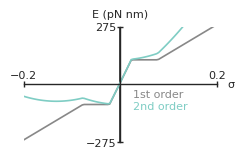

In [16]:
model_palette = {
    'gray': main_palette['gray'],
    'light_gray': main_palette['light_gray'],
    'axis_gray': main_palette['axis_gray'],
    '0th_order': main_palette['light_gray'],
    '1st_order': main_palette['light_gray'],
    '2nd_order': main_palette['polymerase_color'],
    'black': main_palette['black']
    }
# Plot three desired energy curves
fig_energy_curves = plt.figure(figsize=(2.5,1.5))
fig_energy_ax = fig_energy_curves.gca()

fig_energy_ax.axvline(0, color=main_palette['axis_gray'])

for alpha, color in zip([0.0, 0.025], [model_palette['1st_order'], model_palette['2nd_order']]):
    closest_alpha_df = alpha_sweep_df[
        np.abs(alpha_sweep_df.alpha - alpha) == min(np.abs(alpha_sweep_df.alpha - alpha))
    ].copy()
    closest_alpha_df['energy'] += 10
    fig_energy_ax.plot(closest_alpha_df['sigma'], closest_alpha_df['energy'], color=color)
fig_energy_ax.set_xlim([-0.2,0.2])
fig_energy_ax.set_ylim([-250,250])
sns.despine(ax=fig_energy_ax, left=False, bottom=True, top=False, right=True)
fig_energy_ax.set_xticks([-0.2,0.2])
fig_energy_ax.set_yticks([-275,275])
fig_energy_ax.tick_params(direction='inout', length=4, pad=1, labelsize=8)
fig_energy_ax.yaxis.tick_left()
fig_energy_ax.xaxis.tick_top()
fig_energy_ax.spines['top'].set_position('zero')
fig_energy_ax.spines['left'].set_position('zero')
fig_energy_ax.text(0.22, 0, 'σ', fontsize=8, verticalalignment='center')
fig_energy_ax.text(0, 320, 'E (pN nm)', fontsize=8, horizontalalignment='center')
fig_energy_ax.text(0.025, -60, '1st order', fontsize=8, color=model_palette['1st_order'])
fig_energy_ax.text(0.025, -120, '2nd order', fontsize=8, color=model_palette['2nd_order'])
fig_energy_curves.savefig('test.svg')
fig_energy_curves.savefig(rd.outfile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/'energy_curves.svg'), bbox_inches='tight')
fig_energy_curves.savefig(rd.outfile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/'energy_curves.pdf'), bbox_inches='tight')

## Base model behavior figure

In [17]:
# Create the overall figure, gridspec, and add subfigure labels.
fig_bm = plt.figure(figsize=(6.30,8.2))
fig_bm_gridspec = gridspec.GridSpec(5, 2, figure=fig_bm,
    wspace=0.1, hspace=0.15, height_ratios=[0.5, 0.7, 1.4, 0.8, 0.8])
fig_bm_subfigures = {
    'A': fig_bm.add_subfigure(fig_bm_gridspec[0,:]),
    'B': fig_bm.add_subfigure(fig_bm_gridspec[1,:]),
    'C': fig_bm.add_subfigure(fig_bm_gridspec[2,0]),
    'D': fig_bm.add_subfigure(fig_bm_gridspec[2,1]),
    'E': fig_bm.add_subfigure(fig_bm_gridspec[3,:]),
    'F': fig_bm.add_subfigure(fig_bm_gridspec[4,:]),
}
for label, subfig in fig_bm_subfigures.items():
    subfig.add_artist(matplotlib.text.Text(x=0, y=1, text=f'{label}.', fontsize=font_sizes['subpanel_label'], fontweight='bold', verticalalignment='top',transform=subfig.transSubfigure))
fig_bm_palette = {
    'fig.bm.tandem_reporter_upstream': main_palette['tandem'],
    'fig.bm.tandem_reporter_downstream': main_palette['tandem_alt'],
    'fig.bm.convergent': main_palette['convergent'],
    'fig.bm.divergent': main_palette['divergent'],
    'fig.bm.sc_bursts.tandem_reporter_upstream': main_palette['tandem'],
    'fig.bm.sc_bursts.tandem_reporter_downstream': main_palette['tandem_alt'],
    'fig.bm.sc_bursts.convergent': main_palette['convergent'],
    'fig.bm.sc_bursts.divergent': main_palette['divergent'],
    'independent': main_palette['light_gray'],
    'dependent': main_palette['gray'],
    'gray': main_palette['gray'],
    'light_gray': main_palette['light_gray'],
    'axis_gray': main_palette['axis_gray'],
    '0th_order': main_palette['light_gray'],
    '1st_order': main_palette['light_gray'],
    '2nd_order': 'k',
    'reporter_only': main_palette['reporter_only'],
    'black': main_palette['black']
    }

<Figure size 630x820 with 0 Axes>

In [18]:
# Plot BCs
df_bm_bcs = base_model_df[
    (
        (np.abs(base_model_df['coeff.sigma_squared'] - 0.025) < 0.001) &
        (base_model_df['rates.sc_dependent'] == 1.0)
    ) & (
        (base_model_df['condition'] == 'fig.bm.tandem_reporter_upstream') |
        (base_model_df['condition'] == 'fig.bm.tandem_reporter_downstream') |
        (base_model_df['condition'] == 'fig.bm.convergent') |
        (base_model_df['condition'] == 'fig.bm.divergent')
    )
].copy()
df_bm_bcs['condition'] = df_bm_bcs['condition'].cat.remove_unused_categories()
df_bm_bcs['norm_induction'] = df_bm_bcs['induction'] / (1.0 / 120.0)
df_bm_bcs.loc[df_bm_bcs.is_plasmid==0.0, 'constant_mRNA'] /= 250.0
df_bm_bcs.loc[df_bm_bcs.is_plasmid==1.0, 'constant_mRNA'] /= 10.0
#df_bm_bcs['constant_mRNA'] = df_bm_bcs['constant_mRNA'] / 250.0
fig_bm_subfigures['B'].subplots_adjust(left=0.35, bottom=0.36, right=0.9, top=0.8)
fig_bm_bcs_axes = fig_bm_subfigures['B'].subplots(ncols=2, gridspec_kw={'wspace': 0.5})
for ax in fig_bm_bcs_axes:
    ax.axvline(1.0, ymax=0.9, ls=':', color=main_palette['gray'])
sns.lineplot(data=df_bm_bcs[df_bm_bcs['is_plasmid']==0.0],
             x='norm_induction', y='constant_mRNA', hue='condition',
             palette=fig_bm_palette, legend=False, linewidth=1,
             ax=fig_bm_bcs_axes[1])
sns.despine(ax=fig_bm_bcs_axes[1])
sns.lineplot(data=df_bm_bcs[df_bm_bcs['is_plasmid']==1.0],
             x='norm_induction', y='constant_mRNA', hue='condition',
             palette=fig_bm_palette, legend=False, linewidth=1,
             ax=fig_bm_bcs_axes[0])
sns.despine(ax=fig_bm_bcs_axes[0])
for ax in fig_bm_bcs_axes:
    ax.set_xlabel('Fold induction')
    ax.set_ylabel('Fold reporter\noutput')
    ax.set_xlim([0.0, 2.0])
    ax.set_xticks([0.0, 1.0, 2.0])
    ax.set_xticklabels(['0x', '1x', '2x'])
fig_bm_bcs_axes[0].set_ylim([0.0, 30.0])
fig_bm_bcs_axes[0].set_yticks([1.0, 15.0, 30.0])
fig_bm_bcs_axes[0].yaxis.set_major_formatter(fold_nf_formatter(0))
fig_bm_bcs_axes[1].set_ylim([0.0, 1.4])
fig_bm_bcs_axes[1].set_yticks([0.0, 0.5, 1.0])
fig_bm_bcs_axes[1].yaxis.set_major_formatter(fold_nf_formatter(1))

fig_bm_subfigures['B'].text(0.79, 0.85, 'Linear', ha='center', fontsize=font_sizes['base_size'])
fig_bm_subfigures['B'].text(0.46, 0.85, 'Circular', ha='center', fontsize=font_sizes['base_size'])
fig_bm.savefig('test.svg')
del df_bm_bcs

In [19]:
# Plot distribution data
fig_bm_noise_axes = []
for is_plasmid, subfig, noise_offset, noise_scale in zip(
        [0,1],
        [fig_bm_subfigures[x] for x in 'DC'],
        [[-0.04,0], [18,0]],
        [1.0, 26.0]):
    df_bm_dist = base_model_df[
        (
            base_model_df['is_plasmid'] == is_plasmid
        ) & (
            (base_model_df['condition'] == 'fig.bm.tandem_reporter_upstream') |
            (base_model_df['condition'] == 'fig.bm.tandem_reporter_downstream') |
            (base_model_df['condition'] == 'fig.bm.convergent') |
            (base_model_df['condition'] == 'fig.bm.divergent')
        ) & (
            np.abs(base_model_df['induction'] - 8.0e-3) < 1e-4
        ) & (
            (base_model_df['rates.sc_dependent'] == 1.0) &
            (np.abs(base_model_df['coeff.sigma_squared'] - 0.025) < 0.001)
        )
    ].copy()
    df_bm_dist['condition'] = df_bm_dist['condition'].cat.remove_unused_categories()
    df_bm_dist['norm_reporter'] = df_bm_dist.constant_mRNA
    df_bm_dist['norm_inducible'] = df_bm_dist.inducible_mRNA
    df_bm_dist.loc[df_bm_dist.is_plasmid==0.0, 'norm_reporter'] /= 250.0
    df_bm_dist.loc[df_bm_dist.is_plasmid==0.0, 'norm_inducible'] /= 250.0
    df_bm_dist.loc[df_bm_dist.is_plasmid==1.0, 'norm_reporter'] /= 10.0
    df_bm_dist.loc[df_bm_dist.is_plasmid==1.0, 'norm_inducible'] /= 10.0
    subfig.subplots_adjust(left=0.2, bottom=0.25, right=0.9, top=0.8)
    fig_bm_dist_axes = subfig.subplots(ncols=2, sharey=False, gridspec_kw={'wspace': 0.5, 'width_ratios':[5, 1]})
    for condition, noise_yloc in zip(['fig.bm.convergent', 'fig.bm.divergent', 'fig.bm.tandem_reporter_downstream', 'fig.bm.tandem_reporter_upstream'], [1,1,0.9,1.1]):
        df_plot_dist = df_bm_dist[df_bm_dist.condition == condition]
        # Compute distribution noise
        ext_noise = np.var((df_plot_dist.norm_inducible + df_plot_dist.norm_reporter) / 2.0)
        int_noise = np.var((df_plot_dist.norm_inducible - df_plot_dist.norm_reporter) / 2.0)
        fig_bm_dist_axes[1].plot(noise_yloc, int_noise / ext_noise, 'o', color=fig_bm_palette[condition])
        sns.kdeplot(data=df_plot_dist,
                    x='norm_inducible', y='norm_reporter', color=fig_bm_palette[condition], alpha=0.9, linewidths=0.8,
                    ax=fig_bm_dist_axes[0], levels=5 if is_plasmid else 8)
    sns.despine(ax=fig_bm_dist_axes[0])
    fig_bm_dist_axes[0].set_aspect('equal')
    sns.despine(ax=fig_bm_dist_axes[1], bottom=True)
    # Configure the noise ratio plot
    fig_bm_dist_axes[1].xaxis.set_visible(False)
    fig_bm_dist_axes[1].text(0.5, 0.95, 'Noise\nratio', ha='center', ma='center', fontsize=font_sizes['data_annotation'], transform=fig_bm_dist_axes[1].transAxes)
    fig_bm_dist_axes[1].set_xlim([0.8,1.2])
    fig_bm_dist_axes[1].set_yscale('log')
    #fig_bm_dist_axes[0].set_xlim([0.0, 1.0])
    #fig_bm_dist_axes[0].set_ylim([0.0, 1.0])
    #fig_bm_dist_axes[0].set_xticks(np.linspace(0.0,1.0,5))
    #fig_bm_dist_axes[0].set_yticks(np.linspace(0.0,1.0,5))

    if is_plasmid:
        fig_bm_dist_axes[0].set_xlim([0.0,35.0])
        fig_bm_dist_axes[0].set_ylim([0.0,35.0])
        fig_bm_dist_axes[0].set_xticks([1,15,30])
        fig_bm_dist_axes[0].set_yticks([1,15,30])
        fig_bm_dist_axes[0].xaxis.set_major_formatter(fold_nf_formatter(0))
        fig_bm_dist_axes[0].yaxis.set_major_formatter(fold_nf_formatter(0))
    else:
        fig_bm_dist_axes[0].set_xlim([0.0,1.4])
        fig_bm_dist_axes[0].set_ylim([0.0,1.4])
        fig_bm_dist_axes[0].set_xticks(np.linspace(0.0,1.0,3))
        fig_bm_dist_axes[0].set_yticks(np.linspace(0.0,1.0,3))
        fig_bm_dist_axes[0].xaxis.set_major_formatter(fold_nf_formatter(1))
        fig_bm_dist_axes[0].yaxis.set_major_formatter(fold_nf_formatter(1))

    fig_bm_dist_axes[0].set_xlabel('Inducible gene output')
    fig_bm_dist_axes[0].set_ylabel('Reporter output')

    o_x = noise_offset[0]
    o_y = noise_offset[1]
    o_s = noise_scale
    fig_bm_dist_axes[0].annotate(text='', xytext=((o_s * 0.25) + o_x, (o_s * 0.05) + o_y), xy=((o_s * 0.1) + o_x, (o_s * 0.2) + o_y),
        arrowprops={'facecolor': 'black', 'edgecolor': '#000000ff', 'width': 0.8, 'headwidth': 5.0, 'headlength': 5.0, 'shrink': 0.0, 'capstyle': 'round'})
    fig_bm_dist_axes[0].annotate(text='', xytext=((o_s * 0.25) + o_x, (o_s * 0.05) + o_y), xy=((o_s * 0.4) + o_x, (o_s * 0.2) + o_y),
        arrowprops={'facecolor': 'black', 'edgecolor': '#000000ff', 'width': 0.8, 'headwidth': 5.0, 'headlength': 5.0, 'shrink': 0.0, 'capstyle': 'round'})
    fig_bm_dist_axes[0].text((o_s * 0.18) + o_x, (o_s * 0.05) + o_y, 'int.', horizontalalignment='right', transform=fig_bm_dist_axes[0].transData, fontsize=font_sizes['data_annotation'], fontstyle='italic')
    fig_bm_dist_axes[0].text((o_s * 0.32) + o_x, (o_s * 0.05) + o_y, 'ext.', horizontalalignment='left', transform=fig_bm_dist_axes[0].transData, fontsize=font_sizes['data_annotation'], fontstyle='italic')
    subfig.text((o_s * 0.25) + o_x, (o_s * 0.20) + o_y, 'noise', horizontalalignment='center', transform=fig_bm_dist_axes[0].transData, fontsize=font_sizes['data_annotation'], fontstyle='italic')
    fig_bm_noise_axes.append(fig_bm_dist_axes[1])
fig_bm_subfigures['D'].text(0.5, 0.85, 'Linear boundary conditions', fontsize=font_sizes['base_size'], ha='center')
fig_bm_subfigures['C'].text(0.5, 0.85, 'Circular boundary conditions', fontsize=font_sizes['base_size'], ha='center')
fig_bm_noise_axes[0].set_ylim((0.1, 50))
fig_bm_noise_axes[0].set_yticks([0.1,1.0,10.0])
fig_bm_noise_axes[0].set_yticklabels(['0.1','1.0', '10.0'])
fig_bm_noise_axes[1].set_ylim((0.01, 0.5))
fig_bm_noise_axes[1].set_yticks([0.01,0.1])
fig_bm_noise_axes[1].set_yticklabels(['0.01','0.1'])
fig_bm.savefig('test.svg')


In [20]:
# Plot overall sc density as a function of induction
fig_bm_subfigures['E'].subplots_adjust(left=0.1, bottom=0.35, right=0.85, top=0.75)
fig_sc_density_axes = fig_bm_subfigures['E'].subplots(nrows=1, ncols=4, sharey=True, sharex=True, gridspec_kw={'hspace': 0.5})
conditions = [f'fig.bm.sc_bursts.{x}' for x in ['convergent', 'divergent', 'tandem_reporter_upstream', 'tandem_reporter_downstream']]
induction_levels = [0.0, 1.0]
for cond_idx, induction_idx in itertools.product(range(len(conditions)), range(len(induction_levels))):
    ax = fig_sc_density_axes[cond_idx]
    cond = conditions[cond_idx]
    induction = induction_levels[induction_idx]
    ax.axhline(y=0, color=main_palette['axis_gray'])
    if induction_idx == 1:
        sns.lineplot(data=sc_density_df[
            (sc_density_df.condition == cond) &
            (sc_density_df.norm_induction == induction) &
            (sc_density_df.alpha == 0.025) &
            (np.abs(sc_density_df.time - 15000) < 1)
        ], x='distance', y='sc_density',
        color=fig_bm_palette[cond],
        ls='-',
        ax=ax, legend=None)
    else:
        #sns.lineplot(data=sc_density_df[
        #    (sc_density_df.condition == cond) &
        #    (sc_density_df.norm_induction == induction) &
        #    (sc_density_df.alpha == 0.025) &
        #    (np.abs(sc_density_df.time - 15000) < 1)
        #], x='distance', y='sc_density',
        #color=fig_bm_palette[cond],
        #ls='-', alpha=0.5,
        #ax=ax, legend=None)
        sns.lineplot(data=sc_density_df[
            (sc_density_df.condition == cond) &
            (sc_density_df.norm_induction == induction) &
            (sc_density_df.alpha == 0.025) &
            (np.abs(sc_density_df.time - 15000) < 1)
        ], x='distance', y='sc_density',
        color=fig_bm_palette['reporter_only'],
        ls=':',
        ax=ax, legend=None)
    ax.set_xlim([0,3400])
    ax.set_yticks([-0.3,0.0, 0.3])
    ax.set_xticks([x * 0.34 for x in [0,5000,10000]])
    ax.set_xticklabels(['0', '5', '10'])
    ax.set_xlabel('')
    ax.text(100, 0.39, 'Uninduced', color=fig_bm_palette['reporter_only'], fontsize=font_sizes['data_annotation'])
    ax.text(100, 0.27, 'Induced', color=fig_bm_palette[cond], fontsize=font_sizes['data_annotation'])
    xax_transform = ax.get_xaxis_transform()
    if induction_idx == 0:
        if cond.endswith('tandem_reporter_upstream'):
            plot_genes_unified(ax, [(3000 * 0.34, 4000 * 0.34), (6000 * 0.34, 7000 * 0.34)], [fig_bm_palette[cond], fig_bm_palette['gray']], plot_gene_body=True, units='xaxis', plot_inducible=1)
        if cond.endswith('tandem_reporter_downstream'):
            plot_genes_unified(ax, [(3000 * 0.34, 4000 * 0.34), (6000 * 0.34, 7000 * 0.34)], [fig_bm_palette['gray'], fig_bm_palette[cond]], plot_gene_body=True, units='xaxis', plot_inducible=0)
        if cond.endswith('convergent'):
            plot_genes_unified(ax, [(3000 * 0.34, 4000 * 0.34), (7000 * 0.34, 6000 * 0.34)], [fig_bm_palette['gray'], fig_bm_palette[cond]], plot_gene_body=True, units='xaxis', plot_inducible=0)
        if cond.endswith('divergent'):
            plot_genes_unified(ax, [(4000 * 0.34, 3000 * 0.34), (6000 * 0.34, 7000 * 0.34)], [fig_bm_palette['gray'], fig_bm_palette[cond]], plot_gene_body=True, units='xaxis', plot_inducible=0)
    sns.despine(ax=ax)

fig_sc_density_axes[0].set_ylabel("Supercoiling density")
fig_bm_subfigures['E'].text(0.5, 0.13, 'Genomic distance (kb)', ha='center')
fig_bm.savefig('test.svg')

In [21]:
# Plot delta spacing subfigure
df_bm_spacing = spacing_sweep_df[
    (
        spacing_sweep_df['is_plasmid'] == 0
    ) & (
        (spacing_sweep_df['condition'] == 'fig.bm.spacing.tandem_reporter_upstream') |
        (spacing_sweep_df['condition'] == 'fig.bm.spacing.tandem_reporter_downstream') |
        (spacing_sweep_df['condition'] == 'fig.bm.spacing.convergent') |
        (spacing_sweep_df['condition'] == 'fig.bm.spacing.divergent')
    ) & (
        (spacing_sweep_df['rates.sc_dependent'] == 1.0) &
        (spacing_sweep_df['coeff.sigma_squared'] == 0.025)
    ) & (
        (np.abs(spacing_sweep_df['induction'] - 0.0221 / 120.0) < 0.001 / 120.0)|
        (np.abs(spacing_sweep_df['induction'] - 0.3562 / 120.0) < 0.001 / 120.0)|
        (np.abs(spacing_sweep_df['induction'] - 1.172 / 120.0) < 0.001 / 120.0) |
        (np.abs(spacing_sweep_df['induction'] - 1.429 / 120.0) < 0.001 / 120.0) |
        (np.abs(spacing_sweep_df['induction'] - 2.592 / 120.0) < 0.001 / 120.0)
    )
].copy()
df_bm_spacing['kb_spacing'] = df_bm_spacing['spacing'] / 1000
df_bm_spacing['norm_induction'] = df_bm_spacing['induction'] / (1.0 / 120.0)
df_bm_spacing['norm_reporter']  = df_bm_spacing['constant_mRNA'] / 300.0
df_bm_spacing['condition'] = df_bm_spacing['condition'].cat.remove_unused_categories()
max_spacing_mean = df_bm_spacing.groupby(
    ['condition', 'norm_induction', 'spacing']
).mean()['norm_reporter'].xs(10000, level='spacing')
df_bm_spacing['delta_reporter'] = df_bm_spacing.groupby(
    ['condition', 'norm_induction', 'spacing']
    )['norm_reporter'].transform(
        lambda col: col - max_spacing_mean.xs(col.name[0], level='condition').xs(col.name[1])
    )

fig_bm_subfigures['F'].subplots_adjust(left=0.1, bottom=0.35, right=0.85, top=0.75)
fig_bm_spacing_axes = fig_bm_subfigures['F'].subplots(ncols=4, sharey=True)
for condition, ax in zip(['fig.bm.spacing.convergent', 'fig.bm.spacing.divergent', 'fig.bm.spacing.tandem_reporter_upstream', 'fig.bm.spacing.tandem_reporter_downstream'], fig_bm_spacing_axes):
    sns.lineplot(data=df_bm_spacing[df_bm_spacing['condition']==condition], x='kb_spacing', y='norm_reporter', hue='norm_induction',
        palette='coolwarm', hue_norm=matplotlib.colors.Normalize(vmin=0, vmax=2),
        legend=False, ax=ax, ci=None)
    #ax.set_facecolor(light_palette[condition.replace('_','.').split('.')[2]])
    sns.despine(ax=ax)
    ax.set_xscale('log')
    ax.set_xlabel('')
    ax.set_xlim([0.5,10])
    ax.set_yticks([0, 0.5, 1.0])
    ax.set_ylim([-0.05, 1.2])

plot_genes_unified(fig_bm_spacing_axes[0], [(0.3, 0.4), (0.7, 0.6)], [fig_bm_palette[c] for c in ['gray', 'fig.bm.convergent']], base_line_extents=(0.1,0.9), plot_dx=(0,1), plot_inducible=0)
plot_genes_unified(fig_bm_spacing_axes[1], [(0.4, 0.3), (0.6, 0.7)], [fig_bm_palette[c] for c in ['gray', 'fig.bm.divergent']], base_line_extents=(0.1,0.9), plot_dx=(0,1), plot_inducible=0)
plot_genes_unified(fig_bm_spacing_axes[2], [(0.3, 0.4), (0.6, 0.7)], [fig_bm_palette[c] for c in ['fig.bm.tandem_reporter_upstream', 'gray']], base_line_extents=(0.1,0.9), plot_dx=(0,1), plot_inducible=1)
plot_genes_unified(fig_bm_spacing_axes[3], [(0.3, 0.4), (0.6, 0.7)], [fig_bm_palette[c] for c in ['gray', 'fig.bm.tandem_reporter_downstream']], base_line_extents=(0.1,0.9), plot_dx=(0,1), plot_inducible=0)
    
# Add colorbar
fig_bm_spacing_cbar = fig_bm_subfigures['F'].add_axes([0.87, 0.35, 0.02, 0.4])
fig_bm_subfigures['F'].colorbar(cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0, vmax=2), cmap='coolwarm'), cax=fig_bm_spacing_cbar)
fig_bm_spacing_cbar.set_yticks([0,1,2])
fig_bm_spacing_cbar.yaxis.set_major_formatter(fold_formatter)
fig_bm_spacing_cbar.set_title('Fold\ninduction', fontsize=font_sizes['colorbar_title'], loc='left')
fig_bm_spacing_axes[0].set_ylabel('Reporter output')
fig_bm_subfigures['F'].text(0.5, 0.12, 'Inter-gene spacing (kb)', ha='center')
fig_bm.savefig('test.svg')

In [22]:
# Add external images
fig_bm.savefig(rd.outfile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/'fig_base_model_mpl.svg','fig_base_model'))
fig_bm.savefig(rd.outfile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/'fig_base_model_mpl.pdf','fig_base_model'))
#add_external_svgs(
#    rd.outfile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/'fig_base_model.svg', 'fig_base_model_assemble'),
#    rd.infile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/'fig_base_model_mpl.svg', 'fig_base_model_assemble'), fig_bm_subfigures, [
#    ('A', {
#        'filename': rd.infile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/'fig_1a.svg', 'fig_base_model_assemble'),
#        'extents': (0.05, 0.05, 0.5, 0.9)
#    }),
#])

## Supplemental figure - torque and energy response, hyperparameter sweep

In [ ]:
def hyper_extract_df(base_df, drag_coeff=1/20, drag_exp=1, stall_torque=12, stall_width=3):
    result = base_df[
        (base_df['coeff.mRNA_drag_coeff'] == drag_coeff) &
        (base_df['coeff.mRNA_drag_exponent'] == drag_exp) &
        (base_df['rnap.stall_torque'] == stall_torque) &
        (base_df['rnap.stall_width'] == stall_width)
    ].copy()
    result['norm_induction'] = result['induction'] / (1.0 / 120.0)
    result['constant_mRNA'] = result['constant_mRNA'] / 250.0
    return result

In [10]:
if (rd.datadir/'projects'/'tangles'/'simulations'/'fig_supp_hyperparams.gzip').exists():
    hyperparameters_df = pd.read_parquet(
        rd.infile(rd.datadir/'projects'/'tangles'/'simulations'/'fig_supp_hyperparams.gzip', 'fig_supp_hyperparams')
    )
    print(f'Loaded {len(hyperparameters_df)} total simulation runs from Parquet cached file')
else:
    hyperparameters_df = []
    with h5py.File(
        rd.infile(rd.datadir/'projects'/'tangles'/'simulations'/'modeling_hyperparameters_summaries.h5', 'fig_supp_hyperparams_cache'), 'r') as summaries:
        for group in summaries.keys():
            group_df = []
            for run in summaries[group].values():
                group_df.append(pd.DataFrame(data={
                    'inducible_mRNA': run['final_mRNA'][0,:],
                    'constant_mRNA': run['final_mRNA'][1,:]}))
                group_df[-1]['induction'] = run.attrs['gene.base_rate'][0]
                group_df[-1]['condition'] = run.attrs['comment'].decode('utf-8')
                group_df[-1]['is_plasmid'] = run.attrs['bcs.is_circular']
                for term in [
                    'rates.sc_dependent', 'coeff.sigma_squared',
                    'coeff.mRNA_drag_exponent', 'coeff.mRNA_drag_coeff',
                    'rnap.max_velocity', 'rnap.stall_torque', 'rnap.stall_width']:
                    group_df[-1][term] = run.attrs[term]
                gene_endpoints = sorted(np.concatenate((
                    run.attrs['gene.start'],
                    run.attrs['gene.end'])))
                group_df[-1]['spacing'] = int((gene_endpoints[2] - gene_endpoints[1]) / 0.34)
            hyperparameters_df.append(pd.concat(group_df, ignore_index=True))
            print(f'Loaded {len(hyperparameters_df[-1])} simulations...')
    hyperparameters_df = pd.concat(hyperparameters_df, ignore_index=True)
    print(f'Loaded {len(hyperparameters_df)} total simulation runs!')
    hyperparameters_df['condition'] = pd.Categorical(hyperparameters_df['condition'])
    hyperparameters_df.to_parquet(rd.outfile(rd.datadir/'projects'/'tangles'/'simulations'/'fig_supp_hyperparams.gzip', 'fig_supp_hyperparams_cache'), compression='gzip')

Loaded 78435160 total simulation runs from Parquet cached file


In [32]:
fig_supp_hyper_torque = plt.figure(figsize=(5.5,7))
fig_supp_hyper_torque_gridspec = gridspec.GridSpec(5, 2, figure=fig_supp_hyper_torque,
    wspace=0.1, hspace=0.15, height_ratios=[1,1.2,1,1,1])
fig_supp_hyper_torque_subfigures = {
    'A': fig_supp_hyper_torque.add_subfigure(fig_supp_hyper_torque_gridspec[0,0]),
    'B': fig_supp_hyper_torque.add_subfigure(fig_supp_hyper_torque_gridspec[0,1]),
    'C': fig_supp_hyper_torque.add_subfigure(fig_supp_hyper_torque_gridspec[1,:]),
    'D': fig_supp_hyper_torque.add_subfigure(fig_supp_hyper_torque_gridspec[2,:]),
    'E': fig_supp_hyper_torque.add_subfigure(fig_supp_hyper_torque_gridspec[3,:]),
    'F': fig_supp_hyper_torque.add_subfigure(fig_supp_hyper_torque_gridspec[4,:]),
}
for label, subfig in fig_supp_hyper_torque_subfigures.items():
    subfig.add_artist(matplotlib.text.Text(x=0, y=1, text=f'{label}.', fontsize=font_sizes['subpanel_label'], fontweight='bold', verticalalignment='top',transform=subfig.transSubfigure))
    subfig.subplots_adjust(left=0.1, bottom=0.3, right=0.95, top=0.7)
fig_supp_hyper_torque_palette = {
    'hyperparams.tandem_reporter_upstream': main_palette['tandem'],
    'hyperparams.tandem_reporter_downstream': main_palette['tandem_alt'],
    'hyperparams.convergent': main_palette['convergent'],
    'hyperparams.divergent': main_palette['divergent'],
    }

<Figure size 550x700 with 0 Axes>

In [33]:
energy_df = pd.read_csv(rd.infile(rd.rootdir/'data'/'rnap_delta_bubble_energy.csv', 'fig_supp_torque_energy'), names=['sigma','energy_bubble', 'energy_nobubble'])
energy_df['raw_torque'] = energy_df.energy_nobubble / (1.2 * 2 * np.pi)
fig_supp_hyper_torque_subfigures['A'].subplots_adjust(left=0.25, bottom=0.3, right=0.8, top=0.85)
torque_ax = fig_supp_hyper_torque_subfigures['A'].subplots(ncols=1)
fig_supp_hyper_torque_subfigures['B'].subplots_adjust(left=0.25, bottom=0.3, right=0.8, top=0.85)
energy_ax = fig_supp_hyper_torque_subfigures['B'].subplots(ncols=1)

energy_ax.axvline(x=0, color=main_palette['gray'], label='_')
energy_ax.axhline(y=0, color=main_palette['gray'], label='_')
torque_ax.axvline(x=0, color=main_palette['gray'], label='_')
torque_ax.axhline(y=0, color=main_palette['gray'], label='_')
sns.lineplot(data=energy_df, x='sigma', y='raw_torque', ax=torque_ax, color='k')
sns.lineplot(data=energy_df, x='sigma', y='energy_nobubble', ax=energy_ax, color=main_palette['gray'])
sns.lineplot(data=energy_df, x='sigma', y='energy_bubble', ax=energy_ax, color=main_palette['polymerase_color'])
#energy_ax.legend(['Unwinding only', 'Unwinding\n+ local melting'])
energy_ax.text(-0.18, 240, 'Unwinding only', color=main_palette['gray'], fontsize=font_sizes['data_annotation'])
energy_ax.text(-0.18, 80, 'Unwinding and\nlocal melting', color=main_palette['polymerase_color'], fontsize=font_sizes['data_annotation'])
energy_ax.set_xlabel('Supercoilng density, σ')
energy_ax.set_ylabel('Energy (pN nm)')
energy_ax.set_xlim([-0.2,0.2])
torque_ax.set_xlabel('Supercoiling density, σ')
torque_ax.set_ylabel('Torque (pN nm)')
torque_ax.set_xlim([-0.2,0.2])
sns.despine(ax=energy_ax)
sns.despine(ax=torque_ax)
fig_supp_hyper_torque.savefig('test.svg')

In [34]:
drag_coeffs = [1/50, 1/20, 1/10, 1/5]
drag_exp = [1.0, 2.0, 3.0]
stall_torque = [8, 10, 12, 14, 16]
stall_width = [1,3,5]
fig_supp_hyper_torque_subfigures['C'].subplots_adjust(left=0.1, bottom=0.3, right=0.95, top=0.65)
fig_hyper_dcoeff_axes = fig_supp_hyper_torque_subfigures['C'].subplots(ncols=len(drag_coeffs), sharex=True, sharey=True)
fig_supp_hyper_torque_subfigures['D'].subplots_adjust(left=0.1, bottom=0.3, right=0.95, top=0.7)
fig_hyper_dexp_axes = fig_supp_hyper_torque_subfigures['D'].subplots(ncols=len(drag_exp), sharex=True, sharey=True)
fig_hyper_storque_axes = fig_supp_hyper_torque_subfigures['E'].subplots(ncols=len(stall_torque), sharex=True, sharey=True)
fig_hyper_swidth_axes = fig_supp_hyper_torque_subfigures['F'].subplots(ncols=len(stall_width), sharex=True, sharey=True)
for ax, dcoeff in zip(fig_hyper_dcoeff_axes,drag_coeffs):
    sns.lineplot(data=hyper_extract_df(hyperparameters_df, drag_coeff=dcoeff),
            x='norm_induction', y='constant_mRNA', hue='condition', palette=fig_supp_hyper_torque_palette,
            ax=ax, legend=None)
    sns.despine(ax=ax)
    ax.set_xlabel('')
    ax.text(0.5, 1.0, f'η={dcoeff} (pN nm^(β - 1))', ha='center', fontsize=font_sizes['data_annotation'],
            transform=ax.transAxes)
diagram_axes = fig_supp_hyper_torque_subfigures['C'].add_axes([0.1,0.8,0.85,0.001])
diagram_axes.set_axis_off()
diagram_axes.text(0.125, 0, 'Upstream Tandem', ha='center', color=main_palette['tandem'], transform=diagram_axes.transAxes)
diagram_axes.text(0.375, 0, 'Downstream Tandem', ha='center', color=main_palette['tandem_alt'], transform=diagram_axes.transAxes)
diagram_axes.text(0.625, 0, 'Convergent', ha='center', color=main_palette['convergent'], transform=diagram_axes.transAxes)
diagram_axes.text(0.875, 0, 'Divergent', ha='center', color=main_palette['divergent'], transform=diagram_axes.transAxes)
plot_genes_unified(diagram_axes, [(0.1, 0.11), (0.15, 0.16)], [main_palette['tandem'], main_palette['gray']], base_line_extents=(0.05,0.2), plot_gene_body=False, plot_inducible=1)
plot_genes_unified(diagram_axes, [(0.35, 0.36), (0.40, 0.41)], [main_palette['gray'], main_palette['tandem_alt']], base_line_extents=(0.3,0.45), plot_gene_body=False, plot_inducible=0)
plot_genes_unified(diagram_axes, [(0.6, 0.61), (0.65, 0.64)], [main_palette['gray'], main_palette['convergent']], base_line_extents=(0.55,0.7), plot_gene_body=False, plot_inducible=0)
plot_genes_unified(diagram_axes, [(0.86, 0.85), (0.90, 0.91)], [main_palette['gray'], main_palette['divergent']], base_line_extents=(0.8,0.95), plot_gene_body=False, plot_inducible=0)
fig_supp_hyper_torque_subfigures['C'].text(0.53, 0.7, "mRNA drag coefficent", ha='center', fontsize=font_sizes['subaxis_title'])
for ax, dexp in zip(fig_hyper_dexp_axes,drag_exp):
    sns.lineplot(data=hyper_extract_df(hyperparameters_df, drag_exp=dexp),
            x='norm_induction', y='constant_mRNA', hue='condition', palette=fig_supp_hyper_torque_palette,
            ax=ax, legend=None)
    sns.despine(ax=ax)
    ax.set_xlabel('')
    ax.text(0.5, 1.0, f'β={dexp}', ha='center', transform=ax.transAxes)
fig_supp_hyper_torque_subfigures['D'].text(0.53, 0.85, "mRNA drag exponent", ha='center', fontsize=font_sizes['subaxis_title'])
for ax, storque in zip(fig_hyper_storque_axes,stall_torque):
    sns.lineplot(data=hyper_extract_df(hyperparameters_df, stall_torque=storque),
            x='norm_induction', y='constant_mRNA', hue='condition', palette=fig_supp_hyper_torque_palette,
            ax=ax, legend=None)
    sns.despine(ax=ax)
    ax.set_xlabel('')
    ax.text(0.5, 1.0, f'τ_s={storque} (pN nm)', ha='center',
            fontsize=font_sizes['data_annotation'], transform=ax.transAxes)
fig_supp_hyper_torque_subfigures['E'].text(0.53, 0.85, "Stall torque", ha='center', fontsize=font_sizes['subaxis_title'])
for ax, swidth in zip(fig_hyper_swidth_axes,stall_width):
    sns.lineplot(data=hyper_extract_df(hyperparameters_df, stall_width=swidth),
            x='norm_induction', y='constant_mRNA', hue='condition', palette=fig_supp_hyper_torque_palette,
            ax=ax, legend=None)
    sns.despine(ax=ax)
    ax.set_xlabel('')
    ax.text(0.5, 1.0, f'τ_w={swidth} (pN nm)', ha='center',
            fontsize=font_sizes['data_annotation'], transform=ax.transAxes)
fig_supp_hyper_torque_subfigures['F'].text(0.53, 0.85, "Stall width", ha='center', fontsize=font_sizes['subaxis_title'])
fig_hyper_dcoeff_axes[0].set_ylabel('Reporter output')
fig_hyper_dexp_axes[0].set_ylabel('Reporter output')
fig_hyper_storque_axes[0].set_ylabel('Reporter output')
fig_hyper_swidth_axes[0].set_ylabel('Reporter output')
fig_supp_hyper_torque_subfigures['C'].text(0.53, 0.06, 'Fold induction', ha='center')
fig_supp_hyper_torque_subfigures['D'].text(0.53, 0.06, 'Fold induction', ha='center')
fig_supp_hyper_torque_subfigures['E'].text(0.53, 0.06, 'Fold induction', ha='center')
fig_supp_hyper_torque_subfigures['F'].text(0.53, 0.06, 'Fold induction', ha='center')
fig_supp_hyper_torque.savefig('test.svg')

In [ ]:
fig_supp_hyper_torque.savefig(rd.outfile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/'fig_supp_hyper_torque.svg', 'fig_supp_hyper_torque'))
fig_supp_hyper_torque.savefig(rd.outfile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/'fig_supp_hyper_torque.pdf', 'fig_supp_hyper_torque'))

## Supplemental Figure - Alpha sweep

Shows how the behavior of the base model changes as we change the value of $\alpha$

In [ ]:
# Plot sweeping alpha
df_alpha_sweep = base_model_df[
    (
        base_model_df.is_plasmid == 0.0
    ) & (
        (base_model_df['condition'] == 'fig.bm.tandem_reporter_upstream') |
        (base_model_df['condition'] == 'fig.bm.tandem_reporter_downstream') |
        (base_model_df['condition'] == 'fig.bm.convergent') |
        (base_model_df['condition'] == 'fig.bm.divergent')
    ) & (
        base_model_df['rates.sc_dependent'] == 1.0
    ) & (
        base_model_df['coeff.sigma_squared'] > 0
    )
].copy()
df_alpha_sweep['condition'] = df_alpha_sweep['condition'].cat.remove_unused_categories()
df_alpha_sweep['norm_induction'] = df_alpha_sweep['induction'] / (1.0 / 120.0)

In [ ]:
alpha_values = [0.0, 0.01, 0.02, 0.025, 0.03, 0.0316, 0.05]

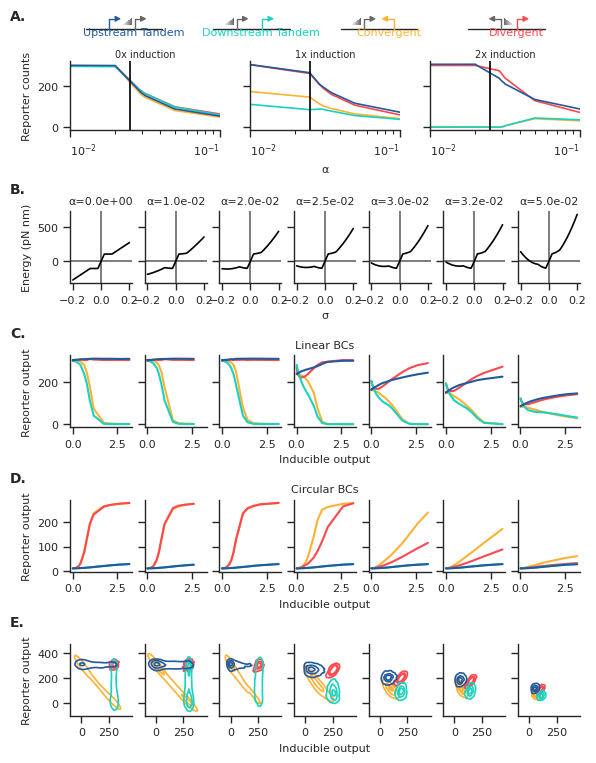

In [ ]:
fig_supp_alpha = plt.figure(figsize=(6,7.5))
fig_supp_alpha_gridspec = gridspec.GridSpec(5, 1, figure=fig_supp_alpha,
    wspace=0.1, hspace=0.15, height_ratios=[1.2,1,1,1,1])
fig_supp_alpha_subfigures = {
    'A': fig_supp_alpha.add_subfigure(fig_supp_alpha_gridspec[0,:]),
    'B': fig_supp_alpha.add_subfigure(fig_supp_alpha_gridspec[1,:]),
    'C': fig_supp_alpha.add_subfigure(fig_supp_alpha_gridspec[2,:]),
    'D': fig_supp_alpha.add_subfigure(fig_supp_alpha_gridspec[3,:]),
    'E': fig_supp_alpha.add_subfigure(fig_supp_alpha_gridspec[4,:]),
}
for label, subfig in fig_supp_alpha_subfigures.items():
    subfig.add_artist(matplotlib.text.Text(x=0, y=1, text=f'{label}.', fontsize=font_sizes['subpanel_label'], fontweight='bold', verticalalignment='top',transform=subfig.transSubfigure))
    subfig.subplots_adjust(left=0.1, bottom=0.3, right=0.95, top=0.8)
unique_alphas = sorted(base_model_df['coeff.sigma_squared'].unique())
fig_supp_alpha_subfigures['A'].subplots_adjust(left=0.1, bottom=0.3, right=0.95, top=0.7)
fig_supp_alpha_induction = fig_supp_alpha_subfigures['A'].subplots(ncols=3, sharey=True)

diagram_axes = fig_supp_alpha_subfigures['A'].add_axes([0.1,0.85,0.85,0.001])
diagram_axes.set_axis_off()
diagram_axes.text(0.125, 0, 'Upstream Tandem', ha='center', color=main_palette['tandem'], transform=diagram_axes.transAxes)
diagram_axes.text(0.375, 0, 'Downstream Tandem', ha='center', color=main_palette['tandem_alt'], transform=diagram_axes.transAxes)
diagram_axes.text(0.625, 0, 'Convergent', ha='center', color=main_palette['convergent'], transform=diagram_axes.transAxes)
diagram_axes.text(0.875, 0, 'Divergent', ha='center', color=main_palette['divergent'], transform=diagram_axes.transAxes)
plot_genes_unified(diagram_axes, [(0.1, 0.11), (0.15, 0.16)], [main_palette['tandem'], main_palette['gray']], base_line_extents=(0.05,0.2), plot_gene_body=False, plot_inducible=1)
plot_genes_unified(diagram_axes, [(0.35, 0.36), (0.40, 0.41)], [main_palette['gray'], main_palette['tandem_alt']], base_line_extents=(0.3,0.45), plot_gene_body=False, plot_inducible=0)
plot_genes_unified(diagram_axes, [(0.6, 0.61), (0.65, 0.64)], [main_palette['gray'], main_palette['convergent']], base_line_extents=(0.55,0.7), plot_gene_body=False, plot_inducible=0)
plot_genes_unified(diagram_axes, [(0.86, 0.85), (0.90, 0.91)], [main_palette['gray'], main_palette['divergent']], base_line_extents=(0.8,0.95), plot_gene_body=False, plot_inducible=0)
fig_supp_alpha_subfigures['B'].subplots_adjust(left=0.1, bottom=0.3, right=0.95, top=0.8)
for ax, induction in zip(fig_supp_alpha_induction,[0.1, 1.0, 2.0]):
    df_at_induction = df_alpha_sweep[np.abs(df_alpha_sweep.norm_induction - induction) == min(np.abs(df_alpha_sweep.norm_induction - induction))]
    sns.lineplot(data=df_at_induction, x='coeff.sigma_squared', y='constant_mRNA', hue='condition',
                palette=fig_bm_palette, ci=None, ax=ax, legend=None)
    sns.despine(ax=ax)
    ax.set_xlim([0.01, 0.1])
    ax.set_xscale('log')
    ax.set_xticks([0.01,0.1])
    ax.xaxis.set_minor_formatter('')
    ax.set_xlabel('')
    for tick, align in zip(ax.xaxis.get_major_ticks(), ['left', 'right']):
        tick.label1.set_horizontalalignment(align)
    
    ax.axvline(0.025, color=fig_bm_palette['2nd_order'])
    ax.text(0.5, 1.05, f'{induction:0.0f}x induction', transform=ax.transAxes, fontsize=font_sizes['subaxis_title'], ha='center')
fig_supp_alpha_induction[1].set_xlabel('α')
fig_supp_alpha_induction[0].set_ylabel('Reporter counts')
fig_supp_energy_axes = fig_supp_alpha_subfigures['B'].subplots(ncols=len(alpha_values), sharex=True, sharey=True)
fig_supp_linear_axes = fig_supp_alpha_subfigures['C'].subplots(ncols=len(alpha_values), sharex=True, sharey=True)
fig_supp_circular_axes = fig_supp_alpha_subfigures['D'].subplots(ncols=len(alpha_values), sharex=True, sharey=True)
fig_supp_dist_axes = fig_supp_alpha_subfigures['E'].subplots(ncols=len(alpha_values), sharex=True, sharey=True)
# Plot Fig1b
for alpha, e_ax, linear_ax, circular_ax, dist_ax in zip(
    alpha_values,
    fig_supp_energy_axes,
    fig_supp_linear_axes,
    fig_supp_circular_axes,
    fig_supp_dist_axes
):
    df_supp_alpha = base_model_df[
        (
            base_model_df['rates.sc_dependent'] == 1.0
        ) & (
            (base_model_df['condition'] == 'fig.bm.tandem_reporter_downstream') |
            (base_model_df['condition'] == 'fig.bm.tandem_reporter_upstream') |
            (base_model_df['condition'] == 'fig.bm.convergent') |
            (base_model_df['condition'] == 'fig.bm.divergent')
        ) & (
            (np.abs(base_model_df['coeff.sigma_squared'] - alpha) < 0.0001)
        )
    ].copy()
    e_ax.axhline(0, color=main_palette['gray'])
    e_ax.axvline(0, color=main_palette['gray'])

    closest_alpha_df = alpha_sweep_df[
        np.abs(alpha_sweep_df.alpha - alpha) == min(np.abs(alpha_sweep_df.alpha - alpha))
    ]
    
    e_ax.plot(closest_alpha_df['sigma'], closest_alpha_df['energy'], color='k')
    e_ax.text(x=0.5, y=1.1, s=f'α={alpha:0.1e}', horizontalalignment='center', transform=e_ax.transAxes)

    df_supp_alpha['condition'] = df_supp_alpha['condition'].cat.remove_unused_categories()
    df_supp_alpha['norm_induction'] = df_supp_alpha['induction'] / (1.0 / 120.0)
    sns.lineplot(data=df_supp_alpha[df_supp_alpha.is_plasmid == 0.0],
                x='norm_induction', y='constant_mRNA', hue='condition', palette=fig_bm_palette, linewidth=1.5,
                legend=False, ax=linear_ax, ci=None)
    sns.lineplot(data=df_supp_alpha[df_supp_alpha.is_plasmid == 1.0],
                x='norm_induction', y='constant_mRNA', hue='condition', palette=fig_bm_palette, linewidth=1.5,
                legend=False, ax=circular_ax, ci=None)
    sns.kdeplot(data=df_supp_alpha[(df_supp_alpha.is_plasmid == 0.0) & (np.abs(df_supp_alpha.induction - 8.0e-3) == np.min(np.abs(df_supp_alpha.induction - 8.0e-3)))],
                x='inducible_mRNA', y='constant_mRNA', hue='condition', palette=fig_bm_palette, ax=dist_ax, levels=4, legend=None)
    linear_ax.set_xlabel('')
    circular_ax.set_xlabel('')
    dist_ax.set_xlabel('')
    sns.despine(ax=e_ax)
    sns.despine(ax=linear_ax)
    sns.despine(ax=circular_ax)
    sns.despine(ax=dist_ax)
fig_supp_energy_axes[3].set_xlabel('σ')
fig_supp_linear_axes[3].set_xlabel('Inducible output')
fig_supp_circular_axes[3].set_xlabel('Inducible output')
fig_supp_dist_axes[3].set_xlabel('Inducible output')
fig_supp_energy_axes[0].set_ylabel('Energy (pN nm)')
fig_supp_linear_axes[0].set_ylabel('Reporter output')
fig_supp_circular_axes[0].set_ylabel('Reporter output')
fig_supp_dist_axes[0].set_ylabel('Reporter output')
fig_supp_linear_axes[3].text(x=0.5, y=1.1, s='Linear BCs', horizontalalignment='center', transform=fig_supp_linear_axes[3].transAxes)
fig_supp_circular_axes[3].text(x=0.5, y=1.1, s='Circular BCs', horizontalalignment='center', transform=fig_supp_circular_axes[3].transAxes)
fig_supp_alpha.savefig('test.svg')
fig_supp_alpha.savefig(rd.outfile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/'fig_supp_alpha_sweep.svg', 'fig_supp_alpha'))
fig_supp_alpha.savefig(rd.outfile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/'fig_supp_alpha_sweep.pdf', 'fig_supp_alpha'))

## Supplemental figure - Zero, first, second order model comparison with alpha sweep

In [ ]:
# Create the overall figure, gridspec, and add subfigure labels.
fig_order_model_comparison = plt.figure(figsize=(6.30,1.7))
fig_order_model_comparison_gridspec = gridspec.GridSpec(1, 2, figure=fig_order_model_comparison,
    wspace=0.1, hspace=0.15)
fig_order_model_comparison_subfigures = {
    'A': fig_order_model_comparison.add_subfigure(fig_order_model_comparison_gridspec[0,0]),
    'B': fig_order_model_comparison.add_subfigure(fig_order_model_comparison_gridspec[0,1]),
}
for label, subfig in fig_order_model_comparison_subfigures.items():
    subfig.add_artist(matplotlib.text.Text(x=0, y=1, text=f'{label}.', fontsize=font_sizes['subpanel_label'],
        fontweight='bold', verticalalignment='top',transform=subfig.transSubfigure))
fig_order_model_comparison_palette = {
    'fig.bm.tandem_reporter_upstream': main_palette['tandem'],
    'fig.bm.tandem_reporter_downstream': main_palette['tandem_alt'],
    'fig.bm.convergent': main_palette['convergent'],
    'fig.bm.divergent': main_palette['divergent'],
    'independent': main_palette['light_gray'],
    'dependent': main_palette['gray'],
    'gray': main_palette['gray'],
    'light_gray': main_palette['light_gray'],
    'axis_gray': main_palette['axis_gray'],
    '0th_order': main_palette['light_gray'],
    '1st_order': main_palette['light_gray'],
    '2nd_order': 'k'
    }

<Figure size 630x170 with 0 Axes>

In [ ]:
fig_order_model_comparison_subfigures['B'].subplots_adjust(left=0.2, bottom=0.3, right=0.95, top=0.90)
fig_supp_bm_alpha_ax = fig_order_model_comparison_subfigures['B'].subplots(ncols=1, sharey=True)
df_at_induction = df_alpha_sweep[np.abs(df_alpha_sweep.norm_induction - 1.0) == min(np.abs(df_alpha_sweep.norm_induction - 1.0))]
sns.lineplot(data=df_at_induction, x='coeff.sigma_squared', y='constant_mRNA', hue='condition',
            palette=fig_bm_palette, ci=None, ax=fig_supp_bm_alpha_ax, legend=None)
sns.despine(ax=fig_supp_bm_alpha_ax)
fig_supp_bm_alpha_ax.set_xlim([0.01, 0.1])
fig_supp_bm_alpha_ax.set_xscale('log')
fig_supp_bm_alpha_ax.set_xticks([0.01,0.1])
fig_supp_bm_alpha_ax.xaxis.set_minor_formatter('')
fig_supp_bm_alpha_ax.set_xlabel('')
for tick, align in zip(fig_supp_bm_alpha_ax.xaxis.get_major_ticks(), ['left', 'right']):
    tick.label1.set_horizontalalignment(align)

fig_supp_bm_alpha_ax.axvline(0.025, color=main_palette['light_gray'], linestyle=':')
fig_supp_bm_alpha_ax.set_xlabel('α')
fig_supp_bm_alpha_ax.set_ylabel('Reporter counts')
fig_order_model_comparison.savefig('test.svg')

In [ ]:
# Plot output by alpha value
df_supp_bm_order = base_model_df[
    (
        base_model_df['is_plasmid'] == 0
    ) & (
        (base_model_df['condition'] == 'fig.bm.tandem_reporter_upstream') |
        (base_model_df['condition'] == 'fig.bm.tandem_reporter_downstream') |
        (base_model_df['condition'] == 'fig.bm.convergent') |
        (base_model_df['condition'] == 'fig.bm.divergent')
    ) & (
        (base_model_df['rates.sc_dependent'] == 0.0) |
        (
            (base_model_df['rates.sc_dependent'] == 1.0) &
            (
                (base_model_df['coeff.sigma_squared'] == 0.0) |
                (np.abs(base_model_df['coeff.sigma_squared'] - 0.025) < 0.001)
            )
        )
    )
].copy()
df_supp_bm_order['sc_condition'] = 'independent'
df_supp_bm_order.loc[
    (df_supp_bm_order['rates.sc_dependent'] == 1.0) &
    (df_supp_bm_order['coeff.sigma_squared'] == 0.0), 'sc_condition'] = 'dependent'
df_supp_bm_order.loc[
    (df_supp_bm_order['rates.sc_dependent'] == 1.0) &
    (np.abs(df_supp_bm_order['coeff.sigma_squared'] - 0.025) < 0.001), 'sc_condition'] = 'dependent_squared'
df_supp_bm_order['condition'] = df_supp_bm_order['condition'].cat.remove_unused_categories()
df_supp_bm_order_normed = (
    df_supp_bm_order.set_index(
        [
            'condition',
            'sc_condition',
            'induction'
        ])['constant_mRNA'] # Select the constant_mRNA column
    / df_supp_bm_order.groupby([
        'condition',
        'sc_condition',
        'induction']).mean().xs( # Divide by the zero-induction, tandem case
            sorted(df_supp_bm_order['induction'].unique())[1], level='induction')['constant_mRNA']).reset_index()
df_supp_bm_order_normed['norm_induction'] = df_supp_bm_order_normed['induction'] / (1.0 / 120.0)
# Tweak subplot layout
fig_order_model_comparison_subfigures['A'].subplots_adjust(left=0.2, bottom=0.25, right=0.95, top=0.8)
fig_order_compare_axes = fig_order_model_comparison_subfigures['A'].subplots(ncols=4, sharey=True)
dashes = {'independent': (2.8,1.2), 'dependent': '', 'dependent_squared': ''}
for ax, condition in zip(fig_order_compare_axes, ['fig.bm.tandem_reporter_upstream', 'fig.bm.tandem_reporter_downstream', 'fig.bm.convergent', 'fig.bm.divergent']):
    fig_order_model_comparison_palette['dependent_squared'] = fig_order_model_comparison_palette[condition]
    sns.lineplot(data=df_supp_bm_order_normed[df_supp_bm_order_normed.condition == condition],
                x='norm_induction', y='constant_mRNA', style='sc_condition', hue='sc_condition', dashes=dashes, palette=fig_order_model_comparison_palette, linewidth=1.5,
                legend=False, ax=ax, ci=None)
    sns.despine(ax=ax)
    ax.set_xlim([0.0, 2.5])
    ax.set_xticks([0.0, 1.0, 2.0])
    ax.set_xticklabels(['0', '1', '2'])
    #ax.set_ylim([0.0, 1.4])
# Set labels
fig_order_compare_axes[0].set_ylabel('Relative\nreporter output')
fig_order_compare_axes[0].set_xlabel('')
fig_order_compare_axes[1].set_xlabel('Fold induction')
fig_order_compare_axes[2].set_xlabel('')
fig_order_compare_axes[3].set_xlabel('')

for ax, cond, locs in zip(fig_order_compare_axes,
        ['fig.bm.tandem_reporter_upstream', 'fig.bm.tandem_reporter_downstream','fig.bm.convergent', 'fig.bm.divergent'],
        [(1.8,0.85,1.8, 0.7,0.2,1.15),
         (1.8,0.85,0.55,0.8,0.2, 0.25),
         (1.8,0.85,0.8,0.8,0.4, 0.25),
         (1.8,0.85,1.8,0.7,0.15,0.65)]):
    ax.text(locs[0], locs[1], '0°', color=fig_order_model_comparison_palette['independent'], fontsize=font_sizes['line_annotation'])
    ax.text(locs[2], locs[3], '1°', color=fig_order_model_comparison_palette['dependent'], fontsize=font_sizes['line_annotation'])
    ax.text(locs[4], locs[5], '2°', color=fig_order_model_comparison_palette[cond], fontsize=font_sizes['line_annotation'])
# Add annotations
fig_order_model_comparison_subfigures['A'].text(0.5, 1, 'Upstream\nTandem', horizontalalignment='center', transform=fig_order_compare_axes[0].transAxes, fontsize=font_sizes['subaxis_title'])
fig_order_model_comparison_subfigures['A'].text(0.5, 1, 'Downstream\nTandem', horizontalalignment='center', transform=fig_order_compare_axes[1].transAxes, fontsize=font_sizes['subaxis_title'])
fig_order_model_comparison_subfigures['A'].text(0.5, 1, 'Convergent', horizontalalignment='center', transform=fig_order_compare_axes[2].transAxes, fontsize=font_sizes['subaxis_title'])
fig_order_model_comparison_subfigures['A'].text(0.5, 1, 'Divergent', horizontalalignment='center', transform=fig_order_compare_axes[3].transAxes, fontsize=font_sizes['subaxis_title'])
plot_genes_unified(fig_order_compare_axes[0], [(0.3, 0.4), (0.6, 0.7)], [fig_order_model_comparison_palette[c] for c in ['fig.bm.tandem_reporter_upstream', 'gray']], base_line_extents=(0.1,0.9), base_offset_inches=0.2)
plot_genes_unified(fig_order_compare_axes[1], [(0.3, 0.4), (0.6, 0.7)], [fig_order_model_comparison_palette[c] for c in ['gray', 'fig.bm.tandem_reporter_downstream']], base_line_extents=(0.1,0.9), base_offset_inches=0.2)
plot_genes_unified(fig_order_compare_axes[2], [(0.3, 0.4), (0.7, 0.6)], [fig_order_model_comparison_palette[c] for c in ['gray', 'fig.bm.convergent']], base_line_extents=(0.1,0.9), base_offset_inches=0.2)
plot_genes_unified(fig_order_compare_axes[3], [(0.4, 0.3), (0.6, 0.7)], [fig_order_model_comparison_palette[c] for c in ['gray', 'fig.bm.divergent']], base_line_extents=(0.1,0.9), base_offset_inches=0.2)

fig_order_model_comparison.savefig('test.svg')
#del df_supp_bm_order

In [ ]:
fig_order_model_comparison.savefig(rd.outfile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/'fig_supp_order_model_comparison.svg', 'fig_base_model'))
fig_order_model_comparison.savefig(rd.outfile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/'fig_supp_order_model_comparison.pdf', 'fig_base_model'))

## Supplemental figure - modifying burst threshold

In [ ]:
# Create the overall figure, gridspec, and add subfigure labels.
fig_supp_burst_threshold = plt.figure(figsize=(7.5,4))
fig_supp_burst_threshold_gridspec = gridspec.GridSpec(2, 1, figure=fig_supp_burst_threshold,
    wspace=0.1, hspace=0.1, height_ratios=[1.4, 1.0])
fig_supp_burst_threshold_subfigures = {
    'A': fig_supp_burst_threshold.add_subfigure(fig_supp_burst_threshold_gridspec[0,:]),
    'B': fig_supp_burst_threshold.add_subfigure(fig_supp_burst_threshold_gridspec[1,:]),
}
for label, subfig in fig_supp_burst_threshold_subfigures.items():
    subfig.add_artist(matplotlib.text.Text(x=0, y=1, text=f'{label}.', fontsize=font_sizes['subpanel_label'], fontweight='bold', verticalalignment='top',transform=subfig.transSubfigure))
fig_supp_burst_threshold_palette = {
    'fig.bm.sc_bursts.tandem_reporter_upstream': main_palette['tandem'],
    'fig.bm.sc_bursts.tandem_reporter_downstream': main_palette['tandem_alt'],
    'fig.bm.sc_bursts.convergent': main_palette['convergent'],
    'fig.bm.sc_bursts.divergent': main_palette['divergent'],
    'gray': main_palette['gray'],
    'background_gray': '#DDDDDD'
    }

In [ ]:
# Plot overall burst duration as a function of induction and condition
conditions = [f'fig.bm.sc_bursts.{x}' for x in ['tandem_reporter_upstream', 'tandem_reporter_downstream', 'convergent', 'divergent']]
fig_supp_burst_threshold_subfigures['A'].subplots_adjust(left=0.08, bottom=0.29, right=0.95, top=0.8)
fig_burst_threshold_size_axes = fig_supp_burst_threshold_subfigures['A'].subplots(ncols=4, sharey=True, sharex=True)
diagram_axes = fig_supp_burst_threshold_subfigures['A'].add_axes([0.2,0.88,0.6,0.001])
diagram_axes.set_axis_off()
diagram_axes.text(0.125, 0, 'Upstream Tandem', ha='center', color=main_palette['tandem'], transform=diagram_axes.transAxes)
diagram_axes.text(0.375, 0, 'Downstream Tandem', ha='center', color=main_palette['tandem_alt'], transform=diagram_axes.transAxes)
diagram_axes.text(0.625, 0, 'Convergent', ha='center', color=main_palette['convergent'], transform=diagram_axes.transAxes)
diagram_axes.text(0.875, 0, 'Divergent', ha='center', color=main_palette['divergent'], transform=diagram_axes.transAxes)
plot_genes_unified(diagram_axes, [(0.1, 0.11), (0.15, 0.16)], [main_palette['tandem'], main_palette['gray']], base_line_extents=(0.05,0.2), plot_gene_body=False, plot_inducible=1)
plot_genes_unified(diagram_axes, [(0.35, 0.36), (0.40, 0.41)], [main_palette['gray'], main_palette['tandem_alt']], base_line_extents=(0.3,0.45), plot_gene_body=False, plot_inducible=0)
plot_genes_unified(diagram_axes, [(0.6, 0.61), (0.65, 0.64)], [main_palette['gray'], main_palette['convergent']], base_line_extents=(0.55,0.7), plot_gene_body=False, plot_inducible=0)
plot_genes_unified(diagram_axes, [(0.86, 0.85), (0.90, 0.91)], [main_palette['gray'], main_palette['divergent']], base_line_extents=(0.8,0.95), plot_gene_body=False, plot_inducible=0)
bm_supp_bursting_df = bursting_df_selected[
    (bursting_df_selected.inter_rnap_gene == 2) &
    (bursting_df_selected.burst_size > 0) &
    (bursting_df_selected.burst_duration > 0) &
    (bursting_df_selected.inter_burst_time > 0) &
    (bursting_df_selected.alpha == 0.025) &
    (
        ((bursting_df_selected.condition) == conditions[0]) |
        ((bursting_df_selected.condition) == conditions[1]) |
        ((bursting_df_selected.condition) == conditions[2]) |
        ((bursting_df_selected.condition) == conditions[3]) 
    ) & (
        bursting_df_selected.induction == selected_induction[1]
    )
].copy()
bm_supp_bursting_df.condition = bm_supp_bursting_df.condition.cat.remove_unused_categories()
for ax, threshold in zip(fig_burst_threshold_size_axes, [10,20,30,60]):
    sns.kdeplot(data=bm_supp_bursting_df[bm_supp_bursting_df.burst_threshold == threshold], x='burst_size', hue='condition',
        common_norm=False,
        palette=fig_supp_burst_threshold_palette, ax=ax, legend=None, log_scale=True)
    ax.set_xlim([1, 3e3])
    ax.set_xlabel('')
    ax.text(0.5, 0.98, f'{threshold}s threshold', ha='center', fontsize=font_sizes['subaxis_title'], transform=ax.transAxes)
    sns.despine(ax=ax)
fig_supp_burst_threshold_subfigures['A'].text(0.5, 0.06, 'Burst size', ha='center')
fig_supp_burst_threshold.savefig('test.svg')

In [ ]:
# Plot inter-burst time as a function of induction
fig_supp_burst_threshold_subfigures['B'].subplots_adjust(left=0.08, bottom=0.29, right=0.95, top=0.9)
fig_burst_threshold_interburst_axes = fig_supp_burst_threshold_subfigures['B'].subplots(ncols=4, sharey=True, sharex=True)
for ax, threshold in zip(fig_burst_threshold_interburst_axes, [10,20,30,60]):
    sns.kdeplot(data=bm_supp_bursting_df[bm_supp_bursting_df.burst_threshold == threshold], x='inter_burst_time', hue='condition',
    common_norm=False,
    palette=fig_supp_burst_threshold_palette, ax=ax, legend=None, log_scale=True)
    #ax.set_xticklabels(['0x', '1x', '2x'])
    ax.set_xlim([1,5e3])
    ax.set_xlabel('')
    ax.text(0.5, 0.98, f'{threshold}s threshold', ha='center', fontsize=font_sizes['subaxis_title'], transform=ax.transAxes)
    sns.despine(ax=ax)
fig_supp_burst_threshold_subfigures['B'].text(0.5, 0.06, 'Inter-burst time (s)', ha='center')
fig_supp_burst_threshold.savefig('test.svg')

In [ ]:
fig_supp_burst_threshold.savefig(rd.outfile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/'fig_supp_burst_threshold.svg', 'fig_sc_bursting'))
fig_supp_burst_threshold.savefig(rd.outfile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/'fig_supp_burst_threshold.pdf', 'fig_sc_bursting'))

## Supplemental figure - sc density as a function of induction

In [ ]:
# Plot overall sc density as a function of induction
fig_supp_sc_density = plt.figure(figsize=(6.5,4.5))
fig_supp_sc_density.subplots_adjust(left=0.1, bottom=0.12, right=0.85, top=0.92)
induction_levels = [0.0, 0.1, 0.5, 1.0, 1.5, 2.0]
fig_supp_sc_density_axes = fig_supp_sc_density.subplots(nrows=len(induction_levels), ncols=4, sharey=True, sharex=True, gridspec_kw={'hspace': 0.3})
conditions = [f'fig.bm.sc_bursts.{x}' for x in ['tandem_reporter_upstream', 'tandem_reporter_downstream', 'convergent', 'divergent']]
for cond_idx, induction_idx in itertools.product(range(len(conditions)), range(len(induction_levels))):
    ax = fig_supp_sc_density_axes[induction_idx, cond_idx]
    cond = conditions[cond_idx]
    induction = induction_levels[induction_idx]
    sns.lineplot(data=sc_density_df[
        (sc_density_df.condition == cond) &
        (sc_density_df.norm_induction == induction) &
        (sc_density_df.alpha == 0.025) &
        (np.abs(sc_density_df.time - 15000) < 1)
    ], x='distance', y='sc_density',
       color=fig_bm_palette[cond],
       ax=ax, legend=None)
    ax.axhline(y=0, color=main_palette['axis_gray'])
    ax.set_xlim([0,3400])
    ax.set_yticks([-0.2,0.2])
    ax.set_xticks([x * 0.34 for x in [0,5000,10000]])
    ax.set_xticklabels(['0', '5', '10'])
    ax.set_xlabel('')
    sns.despine(ax=ax)
    if induction_idx == 0:
        if cond.endswith('tandem_reporter_upstream'):
            plot_genes_unified(ax, [(3000 * 0.34, 4000 * 0.34), (6000 * 0.34, 7000 * 0.34)], [fig_bm_palette[cond], fig_bm_palette['gray']], plot_gene_body=True, units='xaxis', plot_inducible=1)
        if cond.endswith('tandem_reporter_downstream'):
            plot_genes_unified(ax, [(3000 * 0.34, 4000 * 0.34), (6000 * 0.34, 7000 * 0.34)], [fig_bm_palette['gray'], fig_bm_palette[cond]], plot_gene_body=True, units='xaxis', plot_inducible=0)
        if cond.endswith('convergent'):
            plot_genes_unified(ax, [(3000 * 0.34, 4000 * 0.34), (7000 * 0.34, 6000 * 0.34)], [fig_bm_palette['gray'], fig_bm_palette[cond]], plot_gene_body=True, units='xaxis', plot_inducible=0)
        if cond.endswith('divergent'):
            plot_genes_unified(ax, [(4000 * 0.34, 3000 * 0.34), (6000 * 0.34, 7000 * 0.34)], [fig_bm_palette['gray'], fig_bm_palette[cond]], plot_gene_body=True, units='xaxis', plot_inducible=0)
for ax, induction in zip(fig_supp_sc_density_axes[:,-1], induction_levels):
    ax.text(1.05, 0.5, f'{induction}x induction', va='center', transform=ax.transAxes, fontsize=font_sizes['data_annotation'])
for ax in fig_supp_sc_density_axes[:,0]:
    ax.set_ylabel("σ")
    ax.set_ylabel("σ")
fig_supp_sc_density.text(0.5, 0.03, 'Genomic distance (kb)', ha='center')
fig_supp_sc_density.savefig('test.svg')
fig_supp_sc_density.savefig(rd.outfile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/'fig_supp_sc_density_induction.svg', 'fig_sc_bursting'))
fig_supp_sc_density.savefig(rd.outfile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/'fig_supp_sc_density_induction.pdf', 'fig_sc_bursting'))

## Single-cell behavior figure 

In [ ]:
if (rd.datadir/'projects'/'tangles'/'simulations'/'fig_single_cell_behavior.gzip').exists():
    fig_sc_behavior_df = pd.read_parquet(rd.infile(rd.datadir/'projects'/'tangles'/'simulations'/'fig_single_cell_behavior.gzip', 'fig_single_cell_behavior'), memory_map=True)
    print(f'Loaded {len(fig_sc_behavior_df)} total datapoints from Parquet cached file')
else:
    with h5py.File(
        rd.infile(rd.datadir/'projects'/'tangles'/'simulations'/'modeling_bm_examples_combined.h5', 'fig_single_cell_behavior_cache'), 'r') as fig2_raw:
        fig_sc_behavior_df = []
        i = 0
        for group in fig2_raw.keys():
            group_df = []
            for run in fig2_raw[group].values():
                run_shape = run['mRNA'].shape
                for subrun in range(run_shape[2]):
                    # downsample
                    if subrun % 3 != 0:
                        continue
                    inducible = run['mRNA'][:,0,:]
                    constant  = run['mRNA'][:,1,:]
                    group_df.append(pd.DataFrame(data={
                        'inducible_mRNA': inducible[:,subrun],
                        'constant_mRNA':  constant[:,subrun],
                        'time': run['time']}))
                    group_df[-1]['induction'] = run.attrs['step_induction']
                    group_df[-1]['condition'] = run.attrs['comment'].decode('utf-8')
                    group_df[-1]['idx'] = i
                    i += 1
                    gene_endpoints = sorted(np.concatenate((
                        run.attrs['gene.start'],
                        run.attrs['gene.end'])))
                    group_df[-1]['spacing'] = int((gene_endpoints[2] - gene_endpoints[1]) / 0.34)
                    for term in [
                        'step_time', 'coeff.sigma_squared',]:
                        group_df[-1][term] = run.attrs[term]
            fig_sc_behavior_df.append(pd.concat(group_df, ignore_index=True))
            if len(fig_sc_behavior_df) > 10:
                fig_sc_behavior_df = [pd.concat(fig_sc_behavior_df, ignore_index=True)]
            print(f'Loaded {len(fig_sc_behavior_df[-1])} datapoints...')
        fig_sc_behavior_df = pd.concat(fig_sc_behavior_df, ignore_index=True)
        print(f'Loaded {len(fig_sc_behavior_df)} total datapoints!')
        fig_sc_behavior_df.to_parquet(rd.outfile(rd.datadir/'projects'/'tangles'/'simulations'/'fig_single_cell_behavior.gzip', 'fig_single_cell_behavior_cache'), compression='gzip')

In [ ]:
# Prep fig_sc_behavior
# For fig_sc_behavior, find three single runs (tandem, convergent, divergent) at maximum induction
run_ids = {condition: fig_sc_behavior_df[
    (fig_sc_behavior_df['condition']==condition)
    & (np.abs(fig_sc_behavior_df['induction'] - 1.0) < 0.01)
    & (fig_sc_behavior_df['coeff.sigma_squared'] == 0.025)]['idx'].iloc[0] for condition in fig_sc_behavior_df['condition'].unique()}

In [ ]:
def df_crosscorr(df):
    constant_normed  = (df['constant_mRNA'] - df['constant_mRNA'].mean())
    inducible_normed = (df['inducible_mRNA'] - df['inducible_mRNA'].mean())
    geom_norm = np.sqrt(
        scipy.signal.correlate(constant_normed, constant_normed, mode='valid') *
        scipy.signal.correlate(inducible_normed, inducible_normed, mode='valid'))
    geom_norm = geom_norm if geom_norm > 1e-10 else 1.0
    return pd.DataFrame({
        'lags':scipy.signal.correlation_lags(len(constant_normed), len(inducible_normed)),
        'cross_corr':scipy.signal.correlate(inducible_normed, constant_normed) / geom_norm
    })
fig_sc_behavior_convolutions = fig_sc_behavior_df[
    (fig_sc_behavior_df.time > 15000)
    & (
        (np.abs(fig_sc_behavior_df.induction - 0.464) < 0.01) |
        (np.abs(fig_sc_behavior_df.induction - 1.0) < 0.01) |
        (np.abs(fig_sc_behavior_df.induction - 2.61) < 0.01)
    )
    & (fig_sc_behavior_df['coeff.sigma_squared'] == 0.025)].groupby([
        'condition', 'coeff.sigma_squared', 'induction', 'idx'
    ]).apply(df_crosscorr).reset_index().groupby([
        'condition', 'induction', 'lags']).mean().reset_index()
time_delta = np.diff(fig_sc_behavior_df['time'].unique())[0]
fig_sc_behavior_convolutions['time'] = fig_sc_behavior_convolutions['lags'] * time_delta

In [ ]:
# Create the overall figure, gridspec, and add subfigure labels.
fig_sc_behavior = plt.figure(figsize=(6.2,7.0))
fig_sc_behavior_gridspec = gridspec.GridSpec(3, 2, figure=fig_sc_behavior,
    wspace=0.1, hspace=0.1, height_ratios=[1.1, 1.0, 1.0], width_ratios=[1.5, 1])
fig_sc_behavior_subfigures = {
    'A': fig_sc_behavior.add_subfigure(fig_sc_behavior_gridspec[0,0]),
    'B': fig_sc_behavior.add_subfigure(fig_sc_behavior_gridspec[1,0]),
    'C': fig_sc_behavior.add_subfigure(fig_sc_behavior_gridspec[0,1]),
    'D': fig_sc_behavior.add_subfigure(fig_sc_behavior_gridspec[1,1]),
    'E': fig_sc_behavior.add_subfigure(fig_sc_behavior_gridspec[2,0]),
    'F': fig_sc_behavior.add_subfigure(fig_sc_behavior_gridspec[2,1])
}
for label, subfig in fig_sc_behavior_subfigures.items():
    subfig.add_artist(matplotlib.text.Text(x=0, y=1, text=f'{label}.', fontsize=font_sizes['subpanel_label'], fontweight='bold', verticalalignment='top',transform=subfig.transSubfigure))
fig_sc_behavior_palette = {
    'fig.bm_examples.sc_bursts.tandem_reporter_upstream': main_palette['tandem'],
    'fig.bm_examples.sc_bursts.tandem_reporter_downstream': main_palette['tandem_alt'],
    'fig.bm_examples.sc_bursts.convergent': main_palette['convergent'],
    'fig.bm_examples.sc_bursts.divergent': main_palette['divergent'],
    'fig.bm_examples.tandem_reporter_upstream': main_palette['tandem'],
    'fig.bm_examples.tandem_reporter_downstream': main_palette['tandem_alt'],
    'fig.bm_examples.convergent': main_palette['convergent'],
    'fig.bm_examples.divergent': main_palette['divergent'],
    'fig.bm.sc_bursts.tandem_reporter_upstream': main_palette['tandem'],
    'fig.bm.sc_bursts.tandem_reporter_downstream': main_palette['tandem_alt'],
    'fig.bm.sc_bursts.convergent': main_palette['convergent'],
    'fig.bm.sc_bursts.divergent': main_palette['divergent'],
    'gray': main_palette['gray'],
    'background_gray': '#DDDDDD',
    'black': main_palette['black'],
    'reporter_only': main_palette['reporter_only']
    }

In [ ]:
# Plot single-cell example behavior and SC density
fig_sc_behavior_subfigures['A'].subplots_adjust(left=0.15, bottom=0.17, right=0.9, top=0.85)
fig_scb_example_axes = fig_sc_behavior_subfigures['A'].subplots(ncols=2, nrows=2, sharey=True, sharex=True, gridspec_kw={'hspace':0.97}).flatten()
for ax, (cond, id) in zip(np.concatenate((fig_scb_example_axes[2:], fig_scb_example_axes[:2])), run_ids.items()):
    run = fig_sc_behavior_df[fig_sc_behavior_df.idx == id].copy()
    run['normed_constant'] = run['constant_mRNA'] / 300
    run['normed_inducible']= run['inducible_mRNA'] / 300
    ax.axvspan(10000, max(run['time']), color=fig_sc_behavior_palette['background_gray'])
    sns.lineplot(data=run, x='time', y='normed_constant', color=fig_sc_behavior_palette[cond], linewidth=1, legend=False, ax=ax)
    sns.lineplot(data=run, x='time', y='normed_inducible', color=fig_sc_behavior_palette['gray'], linewidth=1, legend=False, ax=ax)
    sns.despine(ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xlim([0,40000])
    ax.set_xticks([0, 10000, 3600*5, 3600*10])
    ax.xaxis.set_major_formatter(hours_1f_formatter)
    ax.text(10000, 1.2, 'Induced', fontsize=font_sizes['data_annotation'])
    ax.set_ylim([-0.02,1.4])
    if cond.endswith('tandem_reporter_upstream'):
        plot_genes_unified(ax, [(0.3, 0.4), (0.6, 0.7)], [fig_sc_behavior_palette[cond], fig_sc_behavior_palette['gray']], plot_inducible=1)
    if cond.endswith('tandem_reporter_downstream'):
        plot_genes_unified(ax, [(0.3, 0.4), (0.6, 0.7)], [fig_sc_behavior_palette['gray'], fig_sc_behavior_palette[cond]], plot_inducible=0)
    if cond.endswith('convergent'):
        plot_genes_unified(ax, [(0.3, 0.4), (0.7, 0.6)], [fig_sc_behavior_palette['gray'], fig_sc_behavior_palette[cond]], plot_inducible=0)
    if cond.endswith('divergent'):
        plot_genes_unified(ax, [(0.4, 0.3), (0.6, 0.7)], [fig_sc_behavior_palette['gray'], fig_sc_behavior_palette[cond]], plot_inducible=0)
    ax.yaxis.labelpad=12
fig_scb_example_axes[0].set_ylabel('Gene output')
fig_scb_example_axes[2].set_ylabel('Gene output')
fig_sc_behavior_subfigures['A'].text(0.5, 0.03, "Time (hr)", horizontalalignment='center')

fig_sc_behavior.savefig('test.svg')

In [ ]:
# Plot sc-density behavior-cell example behavior
fig_sc_behavior_subfigures['B'].subplots_adjust(left=0.15, bottom=0.19, right=0.9, top=0.8)
fig_sc_density_axes = fig_sc_behavior_subfigures['B'].subplots(nrows=2, ncols=2, sharey=True, gridspec_kw={'hspace':0.97}).flatten()
conditions = [f'fig.bm_examples.sc_bursts.{x}' for x in ['convergent', 'divergent', 'tandem_reporter_upstream', 'tandem_reporter_downstream']]
times = [8421, 40000.0]
for t_idx, cond_idx in itertools.product(range(len(times)), range(len(conditions))):
    ax = fig_sc_density_axes[cond_idx]
    cond = conditions[cond_idx]
    ax.axhline(y=0, color=main_palette['axis_gray'])
    sns.lineplot(data=sc_density_df[
        (sc_density_df.condition == cond) &
        (sc_density_df.alpha == 0.025) &
        (sc_density_df.induction == 1.0) &
        (np.abs(sc_density_df.time - times[t_idx]) < 1)
    ], x='distance', y='sc_density', ax=ax,
    color=fig_sc_behavior_palette[cond if t_idx == 1 else 'reporter_only'],
    linestyle='-' if t_idx == 1 else ':')
    ax.set_xlim([0,3400])
    ax.set_xticks([x * 0.34 for x in [0,5000,10000]])
    ax.set_yticks([-0.3, 0, 0.3])
    ax.text(100, 0.35, 'Uninduced', color=fig_sc_behavior_palette['reporter_only'], fontsize=font_sizes['data_annotation'])
    ax.text(1300, 0.35, 'Induced', color=fig_sc_behavior_palette[cond], fontsize=font_sizes['data_annotation'])
    ax.set_xticklabels(['0', '5', '10'])
    xax_transform = ax.get_xaxis_transform()
    if t_idx == 0:
        if cond.endswith('tandem_reporter_upstream'):
            plot_genes_unified(ax, [(3000 * 0.34, 4000 * 0.34), (6000 * 0.34, 7000 * 0.34)], [fig_sc_behavior_palette[cond], fig_sc_behavior_palette['gray']], plot_gene_body=True, units='xaxis', plot_inducible=1)
        if cond.endswith('tandem_reporter_downstream'):
            plot_genes_unified(ax, [(3000 * 0.34, 4000 * 0.34), (6000 * 0.34, 7000 * 0.34)], [fig_sc_behavior_palette['gray'], fig_sc_behavior_palette[cond]], plot_gene_body=True, units='xaxis', plot_inducible=0)
        if cond.endswith('convergent'):
            plot_genes_unified(ax, [(3000 * 0.34, 4000 * 0.34), (7000 * 0.34, 6000 * 0.34)], [fig_sc_behavior_palette['gray'], fig_sc_behavior_palette[cond]], plot_gene_body=True, units='xaxis', plot_inducible=0)
        if cond.endswith('divergent'):
            plot_genes_unified(ax, [(4000 * 0.34, 3000 * 0.34), (6000 * 0.34, 7000 * 0.34)], [fig_sc_behavior_palette['gray'], fig_sc_behavior_palette[cond]], plot_gene_body=True, units='xaxis', plot_inducible=0)
    sns.despine(ax=ax, bottom=True if t_idx == 0 else False)
    ax.set_xlabel('')
    ax.set_ylabel('')
for ax in fig_sc_density_axes[:2]:
    ax.set_xticklabels([])
fig_sc_behavior_subfigures['B'].text(0.05, 0.5, "Supercoiling density", rotation=90, va='center', horizontalalignment='center')
fig_sc_behavior_subfigures['B'].text(0.5, 0.05, "Genomic distance (kb)", va='center', horizontalalignment='center')
fig_sc_behavior.savefig('test.svg')

In [ ]:
# Plot single-cell cross correlation
# Calculate average convolution
fig_sc_behavior_subfigures['D'].subplots_adjust(left=0.2, bottom=0.19, right=0.9, top=0.8)
fig_sc_crosscorr_ax = fig_sc_behavior_subfigures['D'].subplots(ncols=1)
fig_sc_crosscorr_ax.axhline(y=0, color='k')
fig_sc_crosscorr_ax.axvline(x=0, color='#888888', linestyle=':')
sns.lineplot(data=fig_sc_behavior_convolutions[fig_sc_behavior_convolutions.induction == 1.0],
    x='time', y='cross_corr', linewidth=1.5,
    hue='condition', palette=fig_sc_behavior_palette,
    legend=None, ax=fig_sc_crosscorr_ax)
sns.despine(ax=fig_sc_crosscorr_ax)
fig_sc_crosscorr_ax.set_xlabel('Time offset (hr)')
fig_sc_crosscorr_ax.set_ylabel('Cross-correlation')
fig_sc_crosscorr_ax.set_xlim([-3600*4,3600*4])
fig_sc_crosscorr_ax.set_xticks([-3600*4,0,3600*4])
fig_sc_crosscorr_ax.xaxis.set_major_formatter(hours_formatter)
fig_sc_crosscorr_ax.set_ylim([-1.0,0.6])
fig_sc_behavior.savefig('test.svg')

In [ ]:
# Plot reporter distribution plots
fig_sc_noise_df = fig_sc_behavior_df[
    (fig_sc_behavior_df['coeff.sigma_squared'] == 0.025) &
    (np.abs(fig_sc_behavior_df['induction'] - 1.0) < 0.01)
].copy()
fig_sc_noise_df['normed_constant'] = fig_sc_noise_df['constant_mRNA'] / 300
fig_sc_noise_std = fig_sc_noise_df.groupby(['condition', 'time']).std().reset_index()
fig_sc_noise_mean = fig_sc_noise_df.groupby(['condition', 'time']).mean().reset_index()
pre_induction_noise = fig_sc_noise_std[
    (fig_sc_noise_mean.time < 10000) &
    (fig_sc_noise_mean.time > 1000)]['normed_constant'].mean()
fig_sc_behavior_subfigures['E'].subplots_adjust(left=0.15, bottom=0.19, right=0.9, top=0.75)
fig_sc_noise_dist_axes = fig_sc_behavior_subfigures['E'].subplots(ncols=2, nrows=2, sharex=False, sharey=True, gridspec_kw={'hspace': 0.97}).flatten()
for condition, ax in zip(
        ['fig.bm_examples.convergent', 'fig.bm_examples.divergent', 'fig.bm_examples.tandem_reporter_upstream', 'fig.bm_examples.tandem_reporter_downstream'],
        fig_sc_noise_dist_axes):
    dist_df = fig_sc_noise_df[(fig_sc_noise_df.condition == condition)]
    for t, ls, color in zip([5000, 35000], [':', '-'], ['reporter_only', condition]):
        min_sep = min(np.abs(dist_df.time - t))
        sns.kdeplot(data=dist_df[np.abs(dist_df.time - t) == min_sep], x='normed_constant', ax=ax,
            color=fig_sc_behavior_palette[color], legend=None, linestyle=ls)
    sns.despine(ax=ax)
    ax.set_xlabel('')
    ax.set_xlim([0,1.2])
    if condition.endswith('tandem_reporter_upstream'):
        plot_genes_unified(ax, [(0.35, 0.45), (0.65, 0.75)], [fig_sc_behavior_palette[c] for c in [condition, 'gray']], base_line_extents=(0.1,0.9), base_offset_inches=0.07, plot_inducible=1)
    if condition.endswith('tandem_reporter_downstream'):
        plot_genes_unified(ax, [(0.35, 0.45), (0.65, 0.75)], [fig_sc_behavior_palette[c] for c in ['gray', condition]], base_line_extents=(0.1,0.9), base_offset_inches=0.07, plot_inducible=0)
    if condition.endswith('convergent'):
        plot_genes_unified(ax, [(0.25, 0.38), (0.75, 0.62)], [fig_sc_behavior_palette[c] for c in ['gray', condition]], base_line_extents=(0.1,0.9), base_offset_inches=0.07, plot_inducible=0)
    if condition.endswith('divergent'):
        plot_genes_unified(ax, [(0.4, 0.3), (0.6, 0.7)], [fig_sc_behavior_palette[c] for c in ['gray', condition]], base_line_extents=(0.1,0.9), base_offset_inches=0.07, plot_inducible=0)
for ax in fig_sc_noise_dist_axes[:2]:
    ax.set_xticklabels([])
fig_sc_behavior_subfigures['E'].text(0.55, 0.05, "Reporter output", horizontalalignment='center')
fig_sc_noise_dist_axes[0].plot([0.32, 0.36], [0.9, 0.9], ls=':', color=main_palette['reporter_only'], transform=fig_sc_behavior_subfigures['E'].transSubfigure, clip_on=False)
for i, c in enumerate([f'fig.bm_examples.{x}' for x in ['convergent', 'divergent', 'tandem_reporter_upstream', 'tandem_reporter_downstream']]):
    fig_sc_noise_dist_axes[0].plot([0.6, 0.64], [0.93 - (0.02 * i)] * 2, ls='-', color=fig_sc_behavior_palette[c], transform=fig_sc_behavior_subfigures['E'].transSubfigure, clip_on=False)
fig_sc_behavior_subfigures['E'].text(0.37, 0.9, 'Uninduced', ha='left', va='center')
fig_sc_behavior_subfigures['E'].text(0.65, 0.9,  'Induced', ha='left', va='center')
fig_sc_behavior.savefig('test.svg')

In [ ]:
# Plot overall noise behavior
fig_sc_behavior_subfigures['F'].subplots_adjust(left=0.2, bottom=0.19, right=0.9, top=0.75)
fig_sc_noise_ax = fig_sc_behavior_subfigures['F'].subplots(ncols=1)
fig_sc_noise_ax.axvspan(10000, max(fig_sc_noise_df['time']), color=fig_sc_behavior_palette['background_gray'])
fig_sc_noise_ax.axhline(y=pre_induction_noise, color=fig_sc_behavior_palette['gray'], linestyle=':')
sns.lineplot(data=fig_sc_noise_std, x='time', y='normed_constant', hue='condition',
    palette=fig_sc_behavior_palette, linewidth=1, estimator=None, ax=fig_sc_noise_ax, legend=None)
sns.despine(ax=fig_sc_noise_ax)
fig_sc_noise_ax.text(10000, 0.25, 'Induced', fontsize=font_sizes['data_annotation'])
fig_sc_noise_ax.set_ylabel('Standard deviation')
fig_sc_noise_ax.set_xlabel('Time (hr)')
fig_sc_noise_ax.set_xlim([0, 40000])
fig_sc_noise_ax.set_xticks([0,10000,3600*5, 3600*10])
fig_sc_noise_ax.xaxis.set_major_formatter(hours_1f_formatter)
fig_sc_noise_ax.set_ylim([0, 0.28])
fig_sc_behavior.savefig('test.svg')

In [ ]:
fig_sc_behavior.savefig(rd.outfile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/'fig_sc_behavior_mpl.svg', 'fig_single_cell_behavior'))
fig_sc_behavior.savefig(rd.outfile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/'fig_sc_behavior_mpl.pdf', 'fig_single_cell_behavior'))

## Dynamics figure

In [ ]:
with h5py.File(rd.infile(rd.rootdir/'output'/'energy_perturbation_plots.h5'), 'r') as perturb_h5:
    perturbation_energy_df = []
    for group in perturb_h5.keys():
        perturbation_energy_df.append(pd.concat([
            pd.DataFrame({
                'sigma': perturb_h5[group]['sigma'],
                'alpha': perturb_h5[group]['s2_coeff'][a_idx],
                'energy': perturb_h5[group]['initiation_energy'][a_idx,:],
                'torque': perturb_h5[group]['torque'][a_idx,:],
                'torque_perturb_type': perturb_h5[group].attrs['torque_perturb'].decode(),
                'rnap_perturb': perturb_h5[group].attrs['rnap_perturb'].decode()
            }) for a_idx in range(len(perturb_h5[group]['s2_coeff']))
        ]))
    perturbation_energy_df = pd.concat(perturbation_energy_df, ignore_index=True)
if (rd.datadir/'projects'/'tangles'/'simulations'/'perturbation_summaries.gzip').exists():
    perturbation_df = pd.read_parquet(
        rd.infile(rd.datadir/'projects'/'tangles'/'simulations'/'perturbation_summaries.gzip', 'fig_perturbations'), memory_map=True
    )
    print(f'Loaded {len(perturbation_df)} total simulation runs from Parquet cached file')
else:
    perturbation_df = []
    with h5py.File(
        rd.infile(rd.datadir/'projects'/'tangles'/'simulations'/'energy_torque_perturbations.h5', 'fig_perturbations_cache'), 'r') as summaries:
        for group in summaries.keys():
            group_df = []
            for type, run in summaries[group].items():
                if not type.startswith('tangles_summarized_run'):
                    continue
                if not run.attrs['comment'].decode('utf-8').startswith('fig.perturb'):
                    continue
                group_df.append(pd.DataFrame(data={
                    'inducible_mRNA': run['final_mRNA'][0,:],
                    'constant_mRNA': run['final_mRNA'][1,:]}))
                group_df[-1]['induction'] = run.attrs['gene.base_rate'][0]
                group_df[-1]['condition'] = run.attrs['comment'].decode('utf-8')
                group_df[-1]['torque_perturb_type'] = run.attrs['perturbation.torque.type'].decode('utf-8')
                group_df[-1]['energy_perturb_type'] = run.attrs['perturbation.rnap.type'].decode('utf-8')
                group_df[-1]['is_plasmid'] = run.attrs['bcs.is_circular']
                for term in [
                    'rates.sc_dependent', 'coeff.sigma_squared',
                    'coeff.mRNA_drag_exponent', 'coeff.mRNA_drag_coeff',
                    'rnap.max_velocity', 'rnap.stall_torque', 'rnap.stall_width']:
                    group_df[-1][term] = run.attrs[term]
                gene_endpoints = sorted(np.concatenate((
                    run.attrs['gene.start'],
                    run.attrs['gene.end'])))
                group_df[-1]['spacing'] = int((gene_endpoints[2] - gene_endpoints[1]) / 0.34)
            perturbation_df.append(pd.concat(group_df, ignore_index=True))
            print(f'Loaded {len(perturbation_df[-1])} simulations...')
    perturbation_df = pd.concat(perturbation_df, ignore_index=True)
    print(f'Loaded {len(perturbation_df)} total simulation runs!')
    perturbation_df['condition'] = pd.Categorical(perturbation_df.condition)
    perturbation_df['torque_perturb_type'] = pd.Categorical(perturbation_df.torque_perturb_type)
    perturbation_df['energy_perturb_type'] = pd.Categorical(perturbation_df.energy_perturb_type)
    perturbation_df.to_parquet(rd.outfile(rd.datadir/'projects'/'tangles'/'simulations'/'perturbation_summaries.gzip', 'fig_perturbations_cache'), compression='gzip')
if (rd.datadir/'projects'/'tangles'/'simulations'/'perturbation_sc_density.gzip').exists() and (rd.datadir/'projects'/'tangles'/'simulations'/'perturbation_bursting.gzip').exists():
    perturbation_sc_df = pd.read_parquet(
        rd.infile(rd.datadir/'projects'/'tangles'/'simulations'/'perturbation_sc_density.gzip', 'fig_perturbations'), memory_map=True
    )
    print(f'Loaded {len(perturbation_sc_df)} total simulation runs from Parquet cached file')
    perturbation_bursting_df = pd.read_parquet(
        rd.infile(rd.datadir/'projects'/'tangles'/'simulations'/'perturbation_bursting.gzip', 'fig_perturbations'), memory_map=True
    )
    print(f'Loaded {len(perturbation_bursting_df)} total simulation runs from Parquet cached file')
else:
    perturbation_sc_df = []
    perturbation_bursting_df = []
    sc_examples = {}
    sc_burst_condition_dtype = CategoricalDtype([
    "fig.perturb.sc_bursts.tandem_reporter_upstream",
    "fig.perturb.sc_bursts.tandem_reporter_downstream",
    "fig.perturb.sc_bursts.convergent",
    "fig.perturb.sc_bursts.divergent",
    ])
    with h5py.File(
        rd.infile(rd.datadir/'projects'/'tangles'/'simulations'/'energy_torque_perturbations.h5', 'fig_perturbations_cache'), 'r') as summaries:
        for group in summaries.keys():
            group_df = []
            for type, run in summaries[group].items():
                if not type.startswith('tangles_sc_event_run'):
                    continue
                condition = run.attrs['comment'].decode('utf-8')
                bcs_length = run.attrs['bcs.length']
                is_plasmid = run.attrs['bcs.is_circular']
                alpha = run.attrs['coeff.sigma_squared']
                sc_dependent = run.attrs['rates.sc_dependent']
                induction = run.attrs['gene.base_rate'][0]
                torque_perturb = run.attrs['perturbation.torque.type'].decode('utf-8')
                rnap_perturb = run.attrs['perturbation.rnap.type'].decode('utf-8')

                data_dict = {
                    'condition': condition,
                    'bcs_length': bcs_length,
                    'is_plasmid': is_plasmid,
                    'alpha': alpha,
                    'sc_dependent': sc_dependent,
                    'induction': induction,
                    'torque_perturb_type': torque_perturb,
                    'energy_perturb_type': rnap_perturb
                }

                # Save the average supercoiling density per condition
                frozen_meta = tuple(sorted(data_dict.items()))
                if frozen_meta not in sc_examples:
                    sc_examples[frozen_meta] = {
                        'sc_density': np.array(run['sc_density']),
                        'sc_time': np.array(run['sc_times']),
                        'count': 1
                    }
                else:
                    sc_examples[frozen_meta]['sc_density'] += np.array(run['sc_density'])
                    sc_examples[frozen_meta]['count'] += 1
                
                if sc_examples[frozen_meta]['count'] > 20:
                    continue
                
                raw_events = pd.DataFrame({
                    'event_type': run['event_type'],
                    'event_time': run['event_times'],
                    'event_gene': run['event_genes']
                })
                intergene_1_time = np.diff(raw_events[(raw_events.event_gene == 1) & (raw_events.event_type == 1)].event_time)
                intergene_2_time = np.diff(raw_events[(raw_events.event_gene == 2) & (raw_events.event_type == 1)].event_time)
                for burst_threshold in [10, 20, 30, 60]:
                    if len(intergene_1_time) > 0:
                        group_df.append(pd.DataFrame({
                            **data_dict,
                            'inter_rnap_gene': 1,
                            'burst_threshold': burst_threshold,
                            **calculate_burst_dynamics(intergene_1_time, burst_threshold),
                        }))
                        group_df[-1]['condition'] = pd.Categorical(group_df[-1]['condition'], dtype=sc_burst_condition_dtype)
                    if len(intergene_2_time) > 0:
                        group_df.append(pd.DataFrame({
                            **data_dict,
                            'inter_rnap_gene': 2,
                            'burst_threshold': burst_threshold,
                            **calculate_burst_dynamics(intergene_2_time, burst_threshold),
                        }))
                        group_df[-1]['condition'] = pd.Categorical(group_df[-1]['condition'], dtype=sc_burst_condition_dtype)
            if len(group_df) > 0:
                perturbation_bursting_df.append(pd.concat(group_df, ignore_index=True))
            print(f'Loaded {len(perturbation_bursting_df[-1])} simulations...')
    perturbation_bursting_df = pd.concat(perturbation_bursting_df, ignore_index=True)
    perturbation_bursting_df['torque_perturb_type'] = pd.Categorical(perturbation_bursting_df.torque_perturb_type)
    perturbation_bursting_df['energy_perturb_type'] = pd.Categorical(perturbation_bursting_df.energy_perturb_type)
    print(f'Loaded {len(perturbation_bursting_df)} total simulation runs!')
    perturbation_sc_df = pd.concat([
        pd.DataFrame({
            **{k:v for k,v in meta},
            'sc_density': sc['sc_density'][time_idx,:] / sc['count'],
            'distance': np.linspace(0, dict(meta)['bcs_length'], sc['sc_density'].shape[1]),
            'time': time
        })
    for meta, sc in sc_examples.items() for time_idx, time in enumerate(sc['sc_time'])], ignore_index=True)
    perturbation_sc_df.condition = pd.Categorical(perturbation_sc_df.condition, dtype=sc_burst_condition_dtype)
    perturbation_sc_df['torque_perturb_type'] = pd.Categorical(perturbation_sc_df.torque_perturb_type)
    perturbation_sc_df['energy_perturb_type'] = pd.Categorical(perturbation_sc_df.energy_perturb_type)
    print(f'Loaded {len(perturbation_sc_df)} total simulation runs!')
    perturbation_sc_df.to_parquet(rd.outfile(rd.datadir/'projects'/'tangles'/'simulations'/'perturbation_sc_density.gzip', 'fig_perturbations_cache'), compression='gzip')
    perturbation_bursting_df.to_parquet(rd.outfile(rd.datadir/'projects'/'tangles'/'simulations'/'perturbation_bursting.gzip', 'fig_perturbations_cache'), compression='gzip')


In [ ]:
# Create the overall figure, gridspec, and add subfigure labels.
fig_bursts = plt.figure(figsize=(6,6.5))
fig_bursts_gridspec = gridspec.GridSpec(4, 1, figure=fig_bursts,
    wspace=0.1, hspace=0.1, height_ratios=[1.3, 0.5, 0.7, 0.7])
fig_bursts_subfigures = {
    'A': fig_bursts.add_subfigure(fig_bursts_gridspec[0,0]),
    'B': fig_bursts.add_subfigure(fig_bursts_gridspec[1,0]),
    'C': fig_bursts.add_subfigure(fig_bursts_gridspec[2,0]),
    'D': fig_bursts.add_subfigure(fig_bursts_gridspec[3,0]),
}
for label, subfig in fig_bursts_subfigures.items():
    subfig.add_artist(matplotlib.text.Text(x=0, y=1, text=f'{label}.', fontsize=font_sizes['subpanel_label'], fontweight='bold', verticalalignment='top',transform=subfig.transSubfigure))
fig_bursts_palette = {
    'fig.bm_examples.sc_bursts.tandem_reporter_upstream': main_palette['tandem'],
    'fig.bm_examples.sc_bursts.tandem_reporter_downstream': main_palette['tandem_alt'],
    'fig.bm_examples.sc_bursts.convergent': main_palette['convergent'],
    'fig.bm_examples.sc_bursts.divergent': main_palette['divergent'],
    'fig.bm_examples.tandem_reporter_upstream': main_palette['tandem'],
    'fig.bm_examples.tandem_reporter_downstream': main_palette['tandem_alt'],
    'fig.bm_examples.convergent': main_palette['convergent'],
    'fig.bm_examples.divergent': main_palette['divergent'],
    'fig.bm.sc_bursts.tandem_reporter_upstream': main_palette['tandem'],
    'fig.bm.sc_bursts.tandem_reporter_downstream': main_palette['tandem_alt'],
    'fig.bm.sc_bursts.convergent': main_palette['convergent'],
    'fig.bm.sc_bursts.divergent': main_palette['divergent'],
    'fig.perturb.sc_bursts.tandem_reporter_upstream': main_palette['tandem'],
    'fig.perturb.sc_bursts.tandem_reporter_downstream': main_palette['tandem_alt'],
    'fig.perturb.sc_bursts.convergent': main_palette['convergent'],
    'fig.perturb.sc_bursts.divergent': main_palette['divergent'],
    'gray': main_palette['gray'],
    'background_gray': '#DDDDDD',
    'black': main_palette['black'],
    'reporter_only': main_palette['reporter_only']
    }

In [ ]:
fig_bursts_subfigures['A'].subplots_adjust(left=0.12, bottom=0.15, right=0.95, top=0.6)
torque_energy_axes = fig_bursts_subfigures['A'].subplots(nrows=2, ncols=3, sharex=True, sharey=False, gridspec_kw={'hspace':0.4, 'wspace':0.6})
plot_alpha = 0.025

# Draw axes lines
for ax in torque_energy_axes.flatten():
    ax.axhline(0, color=main_palette['gray'])
    ax.axvline(0, color=main_palette['gray'])
    sns.despine(ax=ax)

# Plot regions of change
for ax in torque_energy_axes[:,2]:
    ax.axvspan(0,0.031, color=fig_bursts_palette['background_gray'])
for ax in [torque_energy_axes[1,1]]:
    ax.axvspan(-0.15, -0.06, color=fig_bursts_palette['background_gray'])
    ax.axvspan(0.125, 0.15, color=fig_bursts_palette['background_gray'])

torque_df = perturbation_energy_df[
    (perturbation_energy_df.alpha == 0.0) & (perturbation_energy_df.torque_perturb_type=='original') & (perturbation_energy_df.rnap_perturb=='original')
]
torque_energy_axes[0,0].plot(torque_df.sigma, torque_df.torque, color='k')
torque_df = perturbation_energy_df[
    (perturbation_energy_df.alpha == 0.0) & (perturbation_energy_df.torque_perturb_type=='original') & (perturbation_energy_df.rnap_perturb=='energy_well')
]
torque_energy_axes[0,1].plot(torque_df.sigma, torque_df.torque, color='k')
torque_df = perturbation_energy_df[
    (perturbation_energy_df.alpha == 0.0) & (perturbation_energy_df.torque_perturb_type=='buffering') & (perturbation_energy_df.rnap_perturb=='original')
]
torque_energy_axes[0,2].plot(torque_df.sigma, torque_df.torque, color='k')

alpha_df = perturbation_energy_df[np.abs(perturbation_energy_df.alpha - plot_alpha) == min(np.abs(perturbation_energy_df.alpha - plot_alpha))]
original_df = alpha_df[(alpha_df.torque_perturb_type=='original')&(alpha_df.rnap_perturb=='original')]
well_df = alpha_df[(alpha_df.torque_perturb_type=='original')&(alpha_df.rnap_perturb=='energy_well')]
buffer_df = alpha_df[(alpha_df.torque_perturb_type=='buffering')&(alpha_df.rnap_perturb=='original')]

torque_energy_axes[1,0].plot(original_df.sigma, original_df.energy, color='k')
torque_energy_axes[1,1].plot(well_df.sigma, well_df.energy, color='k')
torque_energy_axes[1,2].plot(buffer_df.sigma, buffer_df.energy, color='k')

for ax in torque_energy_axes.flatten():
    ax.set_xlim([-0.15,0.15])
for t_ax in torque_energy_axes[0,:]:
    t_ax.set_ylim(-30,30)
for e_ax in torque_energy_axes[1,:]:
    e_ax.set_ylim(-150,320)
    e_ax.set_yticks([-0, 100, 200])

for ax in torque_energy_axes[1,:]:
    ax.set_xlabel('Supercoiling density σ')
torque_energy_axes[0,0].set_ylabel('Torque\n(pN nm)')
torque_energy_axes[1,0].set_ylabel('$E_{\\mathrm{init}}$\n(pN nm)')

fig_bursts.savefig('test.svg', bbox_inches='tight')

In [ ]:
# Plot overall burst duration as a function of induction and condition
conditions = ['tandem_reporter_upstream', 'tandem_reporter_downstream', 'convergent', 'divergent']
fig_bursts_subfigures['C'].subplots_adjust(left=0.12, bottom=0.27, right=0.95, top=0.9)
fig_bursts_burst_size_axes = fig_bursts_subfigures['C'].subplots(nrows=2, ncols=3, sharey=False, gridspec_kw={'wspace': 0.6})
fig_bursts_subfigures['D'].subplots_adjust(left=0.12, bottom=0.27, right=0.95, top=0.9)
fig_bursts_interburst_time_axes = fig_bursts_subfigures['D'].subplots(nrows=2, ncols=3, sharey=False, gridspec_kw={'wspace': 0.6})

for scenario_label, torque_type, rnap_type, axes in zip(
    ["Base model", "Extreme σ penalty", "Nucleosome buffering"],
    ["none", "none", "positive_buffer"],
    ["none", "energy_well", "none"],
    [
        np.concatenate((fig_bursts_burst_size_axes[:,0].flatten(), fig_bursts_interburst_time_axes[:,0].flatten())),
        np.concatenate((fig_bursts_burst_size_axes[:,1].flatten(), fig_bursts_interburst_time_axes[:,1].flatten())),
        np.concatenate((fig_bursts_burst_size_axes[:,2].flatten(), fig_bursts_interburst_time_axes[:,2].flatten()))]
):
    axes[0].text(x=0.5, y=1.2, s=scenario_label, ha='center', transform=axes[0].transAxes)
    if torque_type == 'none' and rnap_type == 'none':
        prefix = 'fig.bm.sc_bursts.'
        plot_burst_df = bursting_df_selected[
            (bursting_df_selected.burst_threshold == 30) &
            (bursting_df_selected.inter_rnap_gene == 2) &
            (bursting_df_selected.burst_size > 0) &
            (bursting_df_selected.burst_duration > 0) &
            (bursting_df_selected.inter_burst_time > 0) &
            (bursting_df_selected.alpha == 0.025) &
            (
                ((bursting_df_selected.condition) == f'{prefix}{conditions[0]}') |
                ((bursting_df_selected.condition) == f'{prefix}{conditions[1]}') |
                ((bursting_df_selected.condition) == f'{prefix}{conditions[2]}') |
                ((bursting_df_selected.condition) == f'{prefix}{conditions[3]}') 
            )
        ].copy()
    else:
        prefix = 'fig.perturb.sc_bursts.'
        plot_burst_df = perturbation_bursting_df[
            (
                (perturbation_bursting_df.induction == 1.0/120.0) |
                (perturbation_bursting_df.induction == 0.0)
            ) &
            (perturbation_bursting_df.torque_perturb_type == torque_type) &
            (perturbation_bursting_df.energy_perturb_type == rnap_type) &
            (perturbation_bursting_df.burst_threshold == 30) &
            (perturbation_bursting_df.inter_rnap_gene == 2) &
            (perturbation_bursting_df.burst_size > 0) &
            (perturbation_bursting_df.burst_duration > 0) &
            (perturbation_bursting_df.inter_burst_time > 0) &
            (perturbation_bursting_df.alpha == 0.025) &
            (
                ((perturbation_bursting_df.condition) == f'{prefix}{conditions[0]}') |
                ((perturbation_bursting_df.condition) == f'{prefix}{conditions[1]}') |
                ((perturbation_bursting_df.condition) == f'{prefix}{conditions[2]}') |
            ((perturbation_bursting_df.condition) == f'{prefix}{conditions[3]}') 
            )
        ].copy()
    plot_burst_df.condition = plot_burst_df.condition.cat.remove_unused_categories()
    sns.kdeplot(data=plot_burst_df[
            (plot_burst_df.condition == f'{prefix}tandem_reporter_upstream') &
            (plot_burst_df.induction == 0.0)], x='burst_size', bw_adjust=1.5,
        common_norm=False, color=fig_bursts_palette['reporter_only'], linestyle=':',
        ax=axes[1], legend=None, log_scale=True)
    sns.kdeplot(data=plot_burst_df[
            (plot_burst_df.condition == f'{prefix}tandem_reporter_upstream') &
            (plot_burst_df.induction == 0.0)], x='inter_burst_time',
        common_norm=False, color=fig_bursts_palette['reporter_only'], linestyle=':',
        ax=axes[3], legend=None, log_scale=True)
    sns.kdeplot(data=plot_burst_df[
            (plot_burst_df.condition == f'{prefix}tandem_reporter_upstream') &
            (plot_burst_df.induction == 1.0/120.0)], x='burst_size', bw_adjust=1.5,
        common_norm=False, color=fig_bursts_palette[f'{prefix}tandem_reporter_upstream'],
        ax=axes[1], legend=None, log_scale=True)
    sns.kdeplot(data=plot_burst_df[
            (plot_burst_df.condition == f'{prefix}tandem_reporter_upstream') &
            (plot_burst_df.induction == 1.0/120.0)], x='inter_burst_time',
        common_norm=False, color=fig_bursts_palette[f'{prefix}tandem_reporter_upstream'],
        ax=axes[3], legend=None, log_scale=True)
    sns.kdeplot(data=plot_burst_df[
            (plot_burst_df.condition == f'{prefix}tandem_reporter_downstream')
            & (plot_burst_df.induction == 1.0/120.0)], x='burst_size', bw_adjust=1.5,
        common_norm=False, color=fig_bursts_palette[f'{prefix}tandem_reporter_downstream'],
        ax=axes[1], legend=None, log_scale=True)
    sns.kdeplot(data=plot_burst_df[
            (plot_burst_df.condition == f'{prefix}tandem_reporter_downstream') &
            (plot_burst_df.induction == 1.0/120.0)], x='inter_burst_time',
        common_norm=False, color=fig_bursts_palette[f'{prefix}tandem_reporter_downstream'],
        ax=axes[3], legend=None, log_scale=True)
    sns.kdeplot(data=plot_burst_df[
            (plot_burst_df.condition == f'{prefix}convergent') &
            (plot_burst_df.induction == 0.0)], x='burst_size', bw_adjust=1.5,
        common_norm=False, color=fig_bursts_palette['reporter_only'], linestyle=':',
        ax=axes[0], legend=None, log_scale=True)
    sns.kdeplot(data=plot_burst_df[
            (plot_burst_df.condition == f'{prefix}convergent') &
            (plot_burst_df.induction == 0.0)], x='inter_burst_time',
        common_norm=False, color=fig_bursts_palette['reporter_only'], linestyle=':',
        ax=axes[2], legend=None, log_scale=True)
    sns.kdeplot(data=plot_burst_df[
            (plot_burst_df.condition == f'{prefix}convergent') & 
            (plot_burst_df.induction == 1.0/120.0)], x='burst_size', bw_adjust=1.5,
        common_norm=False, color=fig_bursts_palette[f'{prefix}convergent'],
        ax=axes[0], legend=None, log_scale=True)
    sns.kdeplot(data=plot_burst_df[
            (plot_burst_df.condition == f'{prefix}convergent') & 
            (plot_burst_df.induction == 1.0/120.0)], x='inter_burst_time',
        common_norm=False, color=fig_bursts_palette[f'{prefix}convergent'],
        ax=axes[2], legend=None, log_scale=True)
    sns.kdeplot(data=plot_burst_df[
            (plot_burst_df.condition == f'{prefix}divergent') &
            (plot_burst_df.induction == 1.0/120.0)], x='burst_size', bw_adjust=1.5,
        common_norm=False, color=fig_bursts_palette[f'{prefix}divergent'],
        ax=axes[0], legend=None, log_scale=True)
    sns.kdeplot(data=plot_burst_df[
            (plot_burst_df.condition == f'{prefix}divergent') &
            (plot_burst_df.induction == 1.0/120.0)], x='inter_burst_time',
        common_norm=False, color=fig_bursts_palette[f'{prefix}divergent'],
        ax=axes[2], legend=None, log_scale=True)
    for ax in axes:
        sns.despine(ax=ax)
        ax.set_ylabel('Density')
        ax.set_xlabel('')
        ax.set_xticks([])
for ax in fig_bursts_burst_size_axes[1,:]:
    ax.set_xlabel('Burst size (mRNA counts)')
    ax.xaxis.labelpad = 1
for ax in fig_bursts_burst_size_axes.flatten():
    ax.set_xlim([0.8, 1e3])
for ax in fig_bursts_burst_size_axes[1,:].flatten():
    ax.set_xticks([1,10,100,1000])
    ax.set_xticklabels([1,10,100,1000])
for ax in fig_bursts_interburst_time_axes.flatten():
    ax.set_xlim([15, 8.5e3])
for ax in fig_bursts_interburst_time_axes[1,:].flatten():
    ax.set_xticks([100,1000])
    ax.set_xticklabels([100,1000])
for ax in fig_bursts_interburst_time_axes[1,:]:
    ax.set_xlabel('Inter-burst time (s)')
    ax.xaxis.labelpad = 1
ax = fig_bursts_burst_size_axes[0,1]
ax.text(20,0.8,'Reporter only', color=main_palette['reporter_only'], fontsize=font_sizes['line_annotation'], transform=ax.get_xaxis_transform())
ax.text(20,0.6,'Convergent', color=main_palette['convergent'], fontsize=font_sizes['line_annotation'], transform=ax.get_xaxis_transform())
ax.text(20,0.4,'Divergent', color=main_palette['divergent'], fontsize=font_sizes['line_annotation'], transform=ax.get_xaxis_transform())
ax = fig_bursts_burst_size_axes[1,1]
ax.text(20,0.8,'Reporter only', color=main_palette['reporter_only'], fontsize=font_sizes['line_annotation'], transform=ax.get_xaxis_transform())
ax.text(20,0.6,'Upstream Tandem', color=main_palette['tandem'], fontsize=font_sizes['line_annotation'], transform=ax.get_xaxis_transform())
ax.text(20,0.4,'Downstream Tandem', color=main_palette['tandem_alt'], fontsize=font_sizes['line_annotation'], transform=ax.get_xaxis_transform())
ax = fig_bursts_interburst_time_axes[0,1]
ax.text(400,0.8,'Reporter only', color=main_palette['reporter_only'], fontsize=font_sizes['line_annotation'], transform=ax.get_xaxis_transform())
ax.text(400,0.6,'Convergent', color=main_palette['convergent'], fontsize=font_sizes['line_annotation'], transform=ax.get_xaxis_transform())
ax.text(400,0.4,'Divergent', color=main_palette['divergent'], fontsize=font_sizes['line_annotation'], transform=ax.get_xaxis_transform())
ax = fig_bursts_interburst_time_axes[1,1]
ax.text(400,0.8,'Reporter only', color=main_palette['reporter_only'], fontsize=font_sizes['line_annotation'], transform=ax.get_xaxis_transform())
ax.text(400,0.6,'Upstream Tandem', color=main_palette['tandem'], fontsize=font_sizes['line_annotation'], transform=ax.get_xaxis_transform())
ax.text(400,0.4,'Downstream Tandem', color=main_palette['tandem_alt'], fontsize=font_sizes['line_annotation'], transform=ax.get_xaxis_transform())
fig_bursts.savefig('test.svg')
fig_bursts.savefig(rd.rootdir/'writeups'/'figures'/'modeling_paper'/'fig_bursts.svg', bbox_inches='tight')
fig_bursts.savefig(rd.rootdir/'writeups'/'figures'/'modeling_paper'/'fig_bursts.pdf', bbox_inches='tight')

## Supplemental figure - Distribution of final states with single-cell examples

In [ ]:
example_dist_supp_fig = plt.figure(figsize=(3,3.2))
example_dist_supp_ax = example_dist_supp_fig.add_axes([0.17,0.15,0.7,0.6])
diagram_axes = example_dist_supp_fig.add_axes([0.02,0.88,0.96,0.001])
diagram_axes.set_axis_off()
diagram_axes.text(0.125, 0, 'Upstream\nTandem', ha='center', va='top', color=main_palette['tandem'], transform=diagram_axes.transAxes)
diagram_axes.text(0.375, 0, 'Downstream\nTandem', ha='center', va='top', color=main_palette['tandem_alt'], transform=diagram_axes.transAxes)
diagram_axes.text(0.625, 0, 'Convergent', ha='center', va='top', color=main_palette['convergent'], transform=diagram_axes.transAxes)
diagram_axes.text(0.875, 0, 'Divergent', ha='center', va='top', color=main_palette['divergent'], transform=diagram_axes.transAxes)
plot_genes_unified(diagram_axes, [(0.1, 0.11), (0.15, 0.16)], [main_palette['tandem'], main_palette['gray']], base_line_extents=(0.05,0.2), base_offset_inches=0.02, plot_gene_body=False)
plot_genes_unified(diagram_axes, [(0.35, 0.36), (0.40, 0.41)], [main_palette['gray'], main_palette['tandem_alt']], base_line_extents=(0.3,0.45), base_offset_inches=0.02, plot_gene_body=False)
plot_genes_unified(diagram_axes, [(0.58, 0.59), (0.68, 0.67)], [main_palette['gray'], main_palette['convergent']], base_line_extents=(0.55,0.7), base_offset_inches=0.02, plot_gene_body=False)
plot_genes_unified(diagram_axes, [(0.86, 0.85), (0.90, 0.91)], [main_palette['gray'], main_palette['divergent']], base_line_extents=(0.8,0.95), base_offset_inches=0.02, plot_gene_body=False)
g = sns.kdeplot(data=fig_sc_behavior_df[
    (fig_sc_behavior_df['coeff.sigma_squared'] == 0.025) &
    (fig_sc_behavior_df['time'] == 40000) &
    (fig_sc_behavior_df['induction'] == 1.0)
], x='inducible_mRNA', y='constant_mRNA', hue='condition', palette=fig_sc_behavior_palette, ax=example_dist_supp_ax, legend=None)
sns.despine(ax=example_dist_supp_ax)
example_dist_supp_ax.set_xlim([0,350])
example_dist_supp_ax.set_ylim([0,350])
example_dist_supp_ax.set_xlabel('Inducible gene counts')
example_dist_supp_ax.set_ylabel('Reporter gene counts')
example_dist_supp_fig.savefig('test.svg')
example_dist_supp_fig.savefig(rd.outfile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/'fig_supp_example_distributions.svg', 'fig_single_cell_behavior'))
example_dist_supp_fig.savefig(rd.outfile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/'fig_supp_example_distributions.pdf', 'fig_single_cell_behavior'))

## Supplemental figure - Reporter distributions for different alpha, induction value

In [ ]:
# Plot reporter distribution plots
reporter_high_alpha_supp_fig = plt.figure(figsize=(3, 2))
fig_sc_noise_supp_alpha_df = fig_sc_behavior_df[
    (fig_sc_behavior_df['coeff.sigma_squared'] == 0.03) &
    (np.abs(fig_sc_behavior_df['induction'] - 1.77) < 0.01)
].copy()
fig_sc_noise_supp_alpha_df['normed_constant'] = fig_sc_noise_supp_alpha_df['constant_mRNA'] / 300
pre_induction_noise = fig_sc_noise_std[
    (fig_sc_noise_mean.time < 10000) &
    (fig_sc_noise_mean.time > 1000)]['normed_constant'].mean()
reporter_high_alpha_supp_fig.subplots_adjust(left=0.2, bottom=0.2, right=0.93, top=0.65)
fig_sc_noise_dist_axes = reporter_high_alpha_supp_fig.subplots(ncols=2, nrows=2, sharex=False, sharey=True, gridspec_kw={'hspace': 0.97}).flatten()
for condition, ax in zip(
        ['fig.bm_examples.convergent', 'fig.bm_examples.divergent', 'fig.bm_examples.tandem_reporter_upstream', 'fig.bm_examples.tandem_reporter_downstream'],
        fig_sc_noise_dist_axes):
    dist_df = fig_sc_noise_supp_alpha_df[(fig_sc_noise_supp_alpha_df.condition == condition)]
    for t, ls, color in zip([5000, 35000], [':', '-'], ['reporter_only', condition]):
        min_sep = min(np.abs(dist_df.time - t))
        sns.kdeplot(data=dist_df[np.abs(dist_df.time - t) == min_sep], x='normed_constant', ax=ax,
            color=fig_sc_behavior_palette[color], legend=None, linestyle=ls)
    sns.despine(ax=ax)
    ax.set_xlabel('')
    ax.set_xlim([0,1.2])
    if condition.endswith('tandem_reporter_upstream'):
        plot_genes_unified(ax, [(0.35, 0.45), (0.65, 0.75)], [fig_sc_behavior_palette[c] for c in [condition, 'gray']], base_line_extents=(0.1,0.9), base_offset_inches=0.1, plot_inducible=1)
    if condition.endswith('tandem_reporter_downstream'):
        plot_genes_unified(ax, [(0.35, 0.45), (0.65, 0.75)], [fig_sc_behavior_palette[c] for c in ['gray', condition]], base_line_extents=(0.1,0.9), base_offset_inches=0.1, plot_inducible=0)
    if condition.endswith('convergent'):
        plot_genes_unified(ax, [(0.25, 0.38), (0.75, 0.62)], [fig_sc_behavior_palette[c] for c in ['gray', condition]], base_line_extents=(0.1,0.9), base_offset_inches=0.1, plot_inducible=0)
    if condition.endswith('divergent'):
        plot_genes_unified(ax, [(0.4, 0.3), (0.6, 0.7)], [fig_sc_behavior_palette[c] for c in ['gray', condition]], base_line_extents=(0.1,0.9), base_offset_inches=0.1, plot_inducible=0)
for ax in fig_sc_noise_dist_axes[:2]:
    ax.set_xticklabels([])
reporter_high_alpha_supp_fig.text(0.55, 0.05, "Reporter output", horizontalalignment='center')
fig_sc_noise_dist_axes[0].plot([0.32, 0.36], [0.84, 0.84], ls=':', color=main_palette['reporter_only'], transform=reporter_high_alpha_supp_fig.transSubfigure, clip_on=False)
for i, c in enumerate([f'fig.bm_examples.{x}' for x in ['convergent', 'divergent', 'tandem_reporter_upstream', 'tandem_reporter_downstream']]):
    fig_sc_noise_dist_axes[0].plot([0.6, 0.64], [0.87 - (0.02 * i)] * 2, ls='-', color=fig_sc_behavior_palette[c], transform=reporter_high_alpha_supp_fig.transSubfigure, clip_on=False)
reporter_high_alpha_supp_fig.text(0.37, 0.84, 'Uninduced', ha='left', va='center')
reporter_high_alpha_supp_fig.text(0.65, 0.84,  'Induced', ha='left', va='center')
reporter_high_alpha_supp_fig.text(0.55, 0.95,  'α=0.03, 1.8x induction', ha='center', va='center')
reporter_high_alpha_supp_fig.savefig('test.svg')
reporter_high_alpha_supp_fig.savefig(rd.outfile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/'fig_supp_sc_reporter_output_high_alpha_induction.svg', 'fig_single_cell_behavior'))
reporter_high_alpha_supp_fig.savefig(rd.outfile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/'fig_supp_sc_reporter_output_high_alpha_induction.pdf', 'fig_single_cell_behavior'))

## Toggle switch behavior figure

In [ ]:
# Load toggle examples dataset
if (rd.datadir/'projects'/'tangles'/'simulations'/'fig_toggles_examples.gzip').exists():
    fig_toggles_examples = pd.read_parquet(rd.infile(rd.datadir/'projects'/'tangles'/'simulations'/'fig_toggles_examples.gzip', 'fig3'))
    print(f'Loaded {len(fig_toggles_examples)} total example datapoints from Parquet cached file')
else:
    with h5py.File(
        rd.infile(rd.datadir/'projects'/'tangles'/'simulations'/'modeling_toggles_combined.h5', 'fig_toggles_examples_cache'), 'r') as fig3_raw:
        n_examples = 5
        example_counts = {}
        fig_toggles_examples = []
        i = 1
        for group in fig3_raw.keys():
            for run in fig3_raw[group].values():
                run_shape = run['mRNA'].shape
                condition = run.attrs['comment'].decode('utf-8')
                if not condition.startswith('fig.toggles'):
                    continue
                sc_dependent = run.attrs['rates.sc_dependent']
                is_plasmid = run.attrs['bcs.is_circular']
                hill_n     = run.attrs['hill_coeff']
                mRNA_deg_factor = run.attrs['mRNA_deg_factor']
                alpha = run.attrs['coeff.sigma_squared']
                k_val      = run.attrs['K_val']
                k_factor   = run.attrs['K_factor']
                mRNA_deg_rate = run.attrs['rates.mRNA_degradation']
                if 'time' in run.keys():
                    time = run['time']
                else:
                    time = np.linspace(0.0, 50000.0, 500)
                c_tup = (condition, alpha, hill_n, k_val, k_factor, sc_dependent, is_plasmid, mRNA_deg_rate)
                if c_tup not in example_counts or example_counts[c_tup] < n_examples:
                    fig_toggles_examples.append(pd.DataFrame(data={
                        'condition': condition,
                        'sc_dependent': sc_dependent,
                        'is_plasmid': is_plasmid,
                        'alpha': alpha,
                        'mRNA_deg_rate': mRNA_deg_rate,
                        'mRNA_deg_factor': mRNA_deg_factor,
                        'hill_n': hill_n,
                        'k_val': k_val,
                        'k_factor': k_factor,
                        'time': time,
                        'mRNA_1': run['mRNA'][:,0,0],
                        'mRNA_2': run['mRNA'][:,1,0],
                        'idx': i
                    }))
                    i += 1
                    if c_tup not in example_counts:
                        example_counts[c_tup] = 1
                    else:
                        example_counts[c_tup] += 1
        fig_toggles_examples = pd.concat(fig_toggles_examples)
        print(f'Loaded {len(fig_toggles_examples)} example datapoints!')
        fig_toggles_examples.to_parquet(rd.outfile(rd.datadir/'projects'/'tangles'/'simulations'/'fig_toggles_examples.gzip', 'fig_toggle_examples_cache'), compression='gzip')

In [ ]:
if (rd.datadir/'projects'/'tangles'/'simulations'/'fig_toggles_basin_examples.gzip').exists():
    fig_toggles_basin_examples = pd.read_parquet(rd.infile(rd.datadir/'projects'/'tangles'/'simulations'/'fig_toggles_basin_examples.gzip', 'fig_toggles'))
    print(f'Loaded {len(fig_toggles_basin_examples)} total example datapoints from Parquet cached file')
else:
    with h5py.File(
        rd.infile(rd.datadir/'projects'/'tangles'/'simulations'/'modeling_toggles_combined.h5', 'fig_toggles_basin_examples_cache'), 'r') as fig_toggles_raw:
        n_examples = 1000
        example_counts = {}
        fig_toggles_basin_examples = []
        i = 1
        for group in fig_toggles_raw.keys():
            group_dfs = []
            for run in fig_toggles_raw[group].values():
                run_shape = run['mRNA'].shape
                condition = run.attrs['comment'].decode('utf-8')
                if not condition.startswith('fig.toggles'):
                    continue
                sc_dependent = run.attrs['rates.sc_dependent']
                is_plasmid = run.attrs['bcs.is_circular']
                alpha = run.attrs['coeff.sigma_squared']
                hill_n     = run.attrs['hill_coeff']
                mRNA_deg_factor = run.attrs['mRNA_deg_factor']
                k_val      = run.attrs['K_val']
                k_factor   = run.attrs['K_factor']
                mRNA_deg_rate = run.attrs['rates.mRNA_degradation']
                if 'time' in run.keys():
                    time = run['time']
                else:
                    time = np.linspace(0.0, 50000.0, 500)
                c_tup = (condition, hill_n, alpha, k_val, k_factor, sc_dependent, is_plasmid, mRNA_deg_rate)
                mRNA = run['mRNA'][:,:,:]
                if c_tup not in example_counts or example_counts[c_tup] < n_examples:
                    mRNA_1 = scipy.interpolate.interp1d(time, mRNA[:,0,:], axis=0)
                    mRNA_2 = scipy.interpolate.interp1d(time, mRNA[:,1,:], axis=0)
                    mRNA_1_points = mRNA_1([10200, 12500, 17500, 25000])
                    mRNA_2_points = mRNA_2([10200, 12500, 17500, 25000])
                    group_dfs.append(pd.DataFrame(data={
                        'condition': condition,
                        'sc_dependent': sc_dependent,
                        'is_plasmid': is_plasmid,
                        'alpha': alpha,
                        'mRNA_deg_rate': mRNA_deg_rate,
                        'mRNA_deg_factor': mRNA_deg_factor,
                        'hill_n': hill_n,
                        'k_val': k_val,
                        'k_factor': k_factor,
                        'mRNA_1_at_10200': mRNA_1_points[0,:],
                        'mRNA_2_at_10200': mRNA_2_points[0,:],
                        'mRNA_1_at_12500': mRNA_1_points[1,:],
                        'mRNA_2_at_12500': mRNA_2_points[1,:],
                        'mRNA_1_at_17500': mRNA_1_points[2,:],
                        'mRNA_2_at_17500': mRNA_2_points[2,:],
                        'mRNA_1_at_25000': mRNA_1_points[3,:],
                        'mRNA_2_at_25000': mRNA_2_points[3,:],
                    }))
                    i += 1
                    if c_tup not in example_counts:
                        example_counts[c_tup] = run_shape[2]
                    else:
                        example_counts[c_tup] += run_shape[2]
            fig_toggles_basin_examples.append(pd.concat(group_dfs, ignore_index=True))
            print(f'Loaded {len(fig_toggles_basin_examples[-1])} examples from group')
        fig_toggles_basin_examples = pd.concat(fig_toggles_basin_examples, ignore_index=True)
        print(f'Loaded {len(fig_toggles_basin_examples)} example datapoints!')
        fig_toggles_basin_examples.to_parquet(rd.outfile(rd.datadir/'projects'/'tangles'/'simulations'/'fig_toggles_basin_examples.gzip', 'fig_toggles_basin_examples_cache'), compression='gzip')

In [ ]:
if (rd.datadir/'projects'/'tangles'/'simulations'/'fig_toggles_summaries.gzip').exists():
    fig_toggles_df = pd.read_parquet(rd.infile(rd.datadir/'projects'/'tangles'/'simulations'/'fig_toggles_summaries.gzip', 'fig_toggles'))
    print(f'Loaded {len(fig_toggles_df)} simulation runs from Parquet cached file')
else:
    pass
    with h5py.File(
        rd.infile(rd.datadir/'projects'/'tangles'/'simulations'/'modeling_toggles_combined.h5', 'fig_toggles_cache'), 'r') as fig_toggles_raw:
        fig_toggles_df = []
        i = 0
        # Extract the Spearman correlation between the two mRNA values
        # alongside storing the mean-centered correlation and auto-correlation
        # of the two.
        for group in fig_toggles_raw.keys():
            group_df = []
            for run in fig_toggles_raw[group].values():
                run_shape = run['mRNA'].shape
                condition = run.attrs['comment'].decode('utf-8')
                if not condition.startswith('fig.toggles'):
                    continue
                hill_n    = run.attrs['hill_coeff']
                alpha     = run.attrs['coeff.sigma_squared']
                k_val     = run.attrs['K_val']
                k_factor  = run.attrs['K_factor']
                mRNA_deg_factor = run.attrs['mRNA_deg_factor']
                sc_dependent = run.attrs['rates.sc_dependent']
                is_plasmid = run.attrs['bcs.is_circular']
                mRNA_deg_rate = run.attrs['rates.mRNA_degradation']
                if 'time' in run.keys():
                    time = run['time']
                else:
                    time = np.linspace(0.0, 50000.0, 500)
                escape_times = np.zeros(run_shape[2])
                mRNA = run['mRNA'][:,:,:]
                for subrun in range(run_shape[2]):
                    mRNA_1 = mRNA[:,0,subrun]
                    mRNA_2 = mRNA[:,1,subrun]
                    basin_escape = np.nonzero(mRNA_2 > mRNA_1)[0]
                    if len(basin_escape) > 0:
                        escape_times[subrun] = time[basin_escape[0]]
                    else:
                        escape_times[subrun] = np.inf
                group_df.append(pd.DataFrame(data={
                    'condition': condition,
                    'sc_dependent': sc_dependent,
                    'is_plasmid': is_plasmid,
                    'alpha': alpha,
                    'mRNA_deg_rate': mRNA_deg_rate,
                    'hill_n': hill_n,
                    'k_val': k_val,
                    'k_factor': k_factor,
                    'mRNA_deg_factor': mRNA_deg_factor,
                    'escape_time': escape_times}))
            fig_toggles_df.append(pd.concat(group_df, ignore_index=True))
            print(f'Loaded {len(fig_toggles_df[-1])} simulations...')
        fig_toggles_df = pd.concat(fig_toggles_df, ignore_index=True)
        print(f'Loaded {len(fig_toggles_df)} total simulations!')
        fig_toggles_df.to_parquet(rd.outfile(rd.datadir/'projects'/'tangles'/'simulations'/'fig_toggles_summaries.gzip', 'fig_toggles_cache'), compression='gzip')

In [ ]:
# Summarize escapes
fig_toggles_escapes = fig_toggles_df.groupby([
    'condition', 'alpha', 'mRNA_deg_factor', 'k_factor', 'hill_n']).apply(
        summarize_escape_times).reset_index()

In [ ]:
# Summarize half-lives
def summarize_half_lives(df, offset=0.0):
    half_life_times = sorted(df[df.escape_fraction > 0.5]['time'])
    return half_life_times[0]  - offset if len(half_life_times) != 0 else max(df['time']) - offset

In [ ]:
fig_toggles_halflives = fig_toggles_escapes.groupby(['condition', 'alpha', 'mRNA_deg_factor', 'k_factor', 'hill_n']).apply(lambda df: summarize_half_lives(df, 10000.0)).reset_index()

In [ ]:
# Identify examples
toggle_examples_available = fig_toggles_examples[
    (fig_toggles_examples.time == 25000.0) &
    (fig_toggles_examples.alpha == 0.025) &
    (np.abs(fig_toggles_examples.mRNA_deg_factor - 10) < 0.001) &
    (np.abs(fig_toggles_examples.k_factor - 1.0) < 0.01) &
    (fig_toggles_examples.hill_n==2.0)
]
print(toggle_examples_available)
toggle_example_mapping = {k: toggle_examples_available[toggle_examples_available.condition == k]['idx'].iloc[0]
    for k in toggle_examples_available.condition.unique()}

In [ ]:
# Print output for claims made in main text
escape_percent_df = fig_toggles_escapes[
    (fig_toggles_escapes.alpha == 0.025) &
    (np.abs(fig_toggles_escapes.mRNA_deg_factor - 10) < 0.001) &
    (np.abs(fig_toggles_escapes.k_factor - 1.0) < 0.01) &
    (fig_toggles_escapes.hill_n == 1.0) &
    (np.abs(fig_toggles_escapes.time - 11800) == np.min(np.abs(fig_toggles_escapes.time - 11800)))
]
print(escape_percent_df)

In [ ]:
# Create the overall figure, gridspec, and add subfigure labels.
fig_toggles = plt.figure(figsize=(6.0,7.7))
fig_toggles_gridspec = gridspec.GridSpec(3, 3, figure=fig_toggles,
    wspace=0.1, hspace=0.1, height_ratios=[1,4.0,1.0])
fig_toggles_subfigures = {
    'A': fig_toggles.add_subfigure(fig_toggles_gridspec[0,:]),
    'B': fig_toggles.add_subfigure(fig_toggles_gridspec[1,:]),
    'C': fig_toggles.add_subfigure(fig_toggles_gridspec[2,0]),
    'D': fig_toggles.add_subfigure(fig_toggles_gridspec[2,1]),
    'E': fig_toggles.add_subfigure(fig_toggles_gridspec[2,2]),
}
for label, subfig in fig_toggles_subfigures.items():
    subfig.add_artist(matplotlib.text.Text(x=0, y=1,
        text=f'{label}.', fontsize=font_sizes['subpanel_label'], fontweight='bold', verticalalignment='top',transform=subfig.transSubfigure))
fig_toggles_palette = {
    'fig.toggles.tandem_reporter_upstream': main_palette['tandem'],
    'fig.toggles.tandem_reporter_downstream': main_palette['tandem_alt'],
    'fig.toggles.convergent': main_palette['convergent'],
    'fig.toggles.divergent': main_palette['divergent'],
    'fig.toggles.topo.tandem_reporter_upstream': main_palette['tandem'],
    'fig.toggles.topo.tandem_reporter_downstream': main_palette['tandem_alt'],
    'fig.toggles.topo.convergent': main_palette['convergent'],
    'fig.toggles.topo.divergent': main_palette['divergent'],
    'fig.toggles.sc_bursts.tandem_reporter_upstream': main_palette['tandem'],
    'fig.toggles.sc_bursts.tandem_reporter_downstream': main_palette['tandem_alt'],
    'fig.toggles.sc_bursts.convergent': main_palette['convergent'],
    'fig.toggles.sc_bursts.divergent': main_palette['divergent'],
    'gray': main_palette['gray'],
    'background_gray': '#DDDDDD'
}

In [ ]:
# Plot basin examples
fig_toggle_basins_df = fig_toggles_basin_examples[
    (fig_toggles_basin_examples.alpha == 0.025) &
    (np.abs(fig_toggles_basin_examples.mRNA_deg_factor - 10) < 0.001) &
    (np.abs(fig_toggles_basin_examples.k_factor - 1.0) < 0.01) &
    (fig_toggles_basin_examples.hill_n==2.0)
].copy()
fig_toggles_subfigures['B'].subplots_adjust(left=0.1, bottom=0.1, right=0.85, top=0.9)
fig_toggles_basins_axes = fig_toggles_subfigures['B'].subplots(nrows=4, ncols=4)
basin_times = [10200,12500,17500,25000]
conditions = ['fig.toggles.convergent', 'fig.toggles.divergent', 'fig.toggles.tandem_reporter_upstream', 'fig.toggles.tandem_reporter_downstream']
for t_idx, cond_idx in itertools.product(range(len(basin_times)), range(len(conditions))):
    t = basin_times[t_idx]
    cond = conditions[cond_idx]
    ax = fig_toggles_basins_axes[cond_idx, t_idx]
    sub_df = fig_toggle_basins_df[fig_toggle_basins_df.condition == cond]
    # Count the amount of mRNA in each state
    mean_state = np.mean(sub_df[f'mRNA_1_at_{t}'] > sub_df[f'mRNA_2_at_{t}'])
    sns.kdeplot(data=sub_df,x=f'mRNA_1_at_{t}', y=f'mRNA_2_at_{t}', cmap=custom_cmap_from_base(fig_toggles_palette[cond], (1.1, 0.8), (0.9, 1.4)),
        cut=0, clip=[0,40],fill=True, levels=30, ax=ax, bw_adjust=1.8)
    ax.axline((0,0), slope=1, linestyle=':', color=main_palette['gray'])
    sns.despine(ax=ax)
    ax.set_aspect('equal')
    ax.set_xlim([-2,40])
    ax.set_ylim([-2,40])
    ax.set_xticks([0,25])
    ax.set_yticks([0,25])
    ax.set_xlabel('')
    ax.set_ylabel('')
    if t_idx != 0:
        ax.set_yticklabels([])
    if cond_idx != 3:
        ax.set_xticklabels([])
    ax.text(0.25, 0.65, f'{(1.0 - mean_state) * 100:.1f}%', transform=ax.transAxes, fontsize=font_sizes['data_annotation'])
    ax.text(0.65, 0.25, f'{mean_state * 100:.1f}%', transform=ax.transAxes, fontsize=font_sizes['data_annotation'])

    if t_idx == 3:
        if cond.endswith('tandem_reporter_upstream'):
            plot_genes_unified(ax, [(1.2, 1.3), (1.5, 1.6)], [fig_toggles_palette[cond], fig_toggles_palette['gray']], base_line_extents=(1.1, 1.7), base_offset_inches=-0.4)
            ax.text(1.2, 0.47, 'Upstream\nTandem', va='top', fontsize=font_sizes['subaxis_title'], transform=ax.transAxes)
            ax.text(1.15, 0.68, 'A', va='top', color=fig_toggles_palette[cond], fontsize=font_sizes['subaxis_title'], transform=ax.transAxes)
            ax.text(1.72, 0.68, 'B', va='top', color=fig_toggles_palette['gray'], fontsize=font_sizes['subaxis_title'], transform=ax.transAxes)
        if cond.endswith('tandem_reporter_downstream'):
            plot_genes_unified(ax, [(1.2, 1.3), (1.5, 1.6)], [fig_toggles_palette['gray'], fig_toggles_palette[cond]], base_line_extents=(1.1, 1.7), base_offset_inches=-0.4)
            ax.text(1.2, 0.47, 'Downstream\nTandem', va='top', fontsize=font_sizes['subaxis_title'], transform=ax.transAxes)
            ax.text(1.72, 0.68, 'A', va='top', color=fig_toggles_palette[cond], fontsize=font_sizes['subaxis_title'], transform=ax.transAxes)
            ax.text(1.15, 0.68, 'B', va='top', color=fig_toggles_palette['gray'], fontsize=font_sizes['subaxis_title'], transform=ax.transAxes)
        if cond.endswith('convergent'):
            plot_genes_unified(ax, [(1.2, 1.3), (1.6, 1.5)], [fig_toggles_palette['gray'], fig_toggles_palette[cond]], base_line_extents=(1.1, 1.7), base_offset_inches=-0.4)
            ax.text(1.2, 0.47, 'Convergent', va='top', fontsize=font_sizes['subaxis_title'], transform=ax.transAxes)
            ax.text(1.75, 0.68, 'A', va='top', color=fig_toggles_palette[cond], fontsize=font_sizes['subaxis_title'], transform=ax.transAxes)
            ax.text(1.15, 0.68, 'B', va='top', color=fig_toggles_palette['gray'], fontsize=font_sizes['subaxis_title'], transform=ax.transAxes)
        if cond.endswith('divergent'):
            plot_genes_unified(ax, [(1.3, 1.2), (1.5, 1.6)], [fig_toggles_palette['gray'], fig_toggles_palette[cond]], base_line_extents=(1.1, 1.7), base_offset_inches=-0.4)
            ax.text(1.2, 0.47, 'Divergent', va='top', fontsize=font_sizes['subaxis_title'], transform=ax.transAxes)
            ax.text(1.72, 0.68, 'A', va='top', color=fig_toggles_palette[cond], fontsize=font_sizes['subaxis_title'], transform=ax.transAxes)
            ax.text(1.18, 0.68, 'B', va='top', color=fig_toggles_palette['gray'], fontsize=font_sizes['subaxis_title'], transform=ax.transAxes)

fig_toggles_subfigures['B'].text(0.5, 0.04, "Gene A mRNA count", horizontalalignment='center')
fig_toggles_subfigures['B'].text(0.05, 0.5, "Gene B mRNA count", horizontalalignment='center', verticalalignment='center', rotation=90)

fig_toggles_basin_time_ax = fig_toggles_subfigures['B'].add_axes((0.1, 0.93, 0.75, 0.1))
fig_toggles_basin_time_ax.yaxis.set_visible(False)
fig_toggles_basin_time_ax.set_xlim([0,8])
fig_toggles_basin_time_ax.set_xticks([0.8, 1, 3, 5, 7])
fig_toggles_basin_time_ax.set_xticklabels(['Induction\n2.8 hr', '2.83 hr', '3.5 hr', '5.0 hr', '7.0 hr'])
fig_toggles_basin_time_ax.xaxis.get_major_ticks()[0]._apply_params(tickdir='in')
basin_time_old_tick_loc = fig_toggles_basin_time_ax.xaxis.get_majorticklabels()[0].get_position()
fig_toggles_basin_time_ax.xaxis.get_majorticklabels()[0].set_position((basin_time_old_tick_loc[0], basin_time_old_tick_loc[1] + 0.75))
fig_toggles_subfigures['B'].text(0.5, 0.96, "Time", horizontalalignment='center')
fig_toggles_basin_time_ax.plot(1, 0, ">k", transform=fig_toggles_basin_time_ax.transAxes, clip_on=False)
sns.despine(ax=fig_toggles_basin_time_ax, left=True)

fig_toggles.savefig('test.svg')

In [ ]:
# Plot average escape percentage
fig_toggle_escapes_df = fig_toggles_escapes[
    (fig_toggles_escapes.alpha == 0.025) &
    (np.abs(fig_toggles_escapes.mRNA_deg_factor - 10) < 0.001) &
    (np.abs(fig_toggles_escapes.k_factor - 1.0) < 0.01) &
    (fig_toggles_escapes.hill_n == 2.0)
]
fig_toggles_subfigures['C'].subplots_adjust(left=0.35, bottom=0.35, right=0.95, top=0.9)
fig_toggle_escapes_ax = fig_toggles_subfigures['C'].subplots(ncols=1)
sns.lineplot(data=fig_toggle_escapes_df, x='time', y='stable_fraction', hue='condition', palette=fig_toggles_palette, linewidth=1.5, ax=fig_toggle_escapes_ax, legend=None)
sns.despine(ax=fig_toggle_escapes_ax)
fig_toggle_escapes_ax.set_xlabel('Time (hr)')
fig_toggle_escapes_ax.set_ylabel('Stable percent')
fig_toggle_escapes_ax.set_xlim([9000,25000])
fig_toggle_escapes_ax.set_xticks([10000,20000])
fig_toggle_escapes_ax.set_xticklabels(['3','6'])
fig_toggle_escapes_ax.set_yticks([0,0.5,1.0])
fig_toggle_escapes_ax.set_yticklabels(['0%', '50%', '100%'])
fig_toggle_escapes_ax.xaxis.labelpad = 2
fig_toggles.savefig('test.svg')

In [ ]:
# Plot burst dynamics
fig_toggles_subfigures['D'].subplots_adjust(left=0.35, bottom=0.35, right=0.95, top=0.9)
fig_toggles_burst_size_ax = fig_toggles_subfigures['D'].subplots(ncols=1)
burst_df = bursting_df[
    (bursting_df.alpha == 0.025) &
    (bursting_df.burst_threshold == 30) &
    (bursting_df.inter_rnap_gene == 1) &
    (np.abs(bursting_df.mRNA_deg_factor - 10) < 0.001) &
    (np.abs(bursting_df.k_factor - 1.0) < 0.01) &
    (bursting_df.hill_n == 2.0) &
    (bursting_df.burst_size > 0) &
    (bursting_df.inter_burst_time > 0) &
    (
        (bursting_df.condition == 'fig.toggles.sc_bursts.tandem_reporter_upstream') |
        (bursting_df.condition == 'fig.toggles.sc_bursts.tandem_reporter_downstream') |
        (bursting_df.condition == 'fig.toggles.sc_bursts.convergent') |
        (bursting_df.condition == 'fig.toggles.sc_bursts.divergent')
    )
].copy()
burst_df.condition = burst_df.condition.cat.remove_unused_categories()

sns.kdeplot(data=burst_df, x='burst_size', hue='condition', palette=fig_toggles_palette, common_norm=False, log_scale=True,
        legend=None, ax=fig_toggles_burst_size_ax)
sns.despine(ax=fig_toggles_burst_size_ax)
fig_toggles_burst_size_ax.set_xlim([0.5,1500])
fig_toggles_burst_size_ax.set_xticks([1, 10, 100, 1000])
fig_toggles_burst_size_ax.xaxis.labelpad = 2
#fig_toggles_burst_size_ax.set_xticks([1,100])
fig_toggles_burst_size_ax.set_xlabel('Gene A burst size')
fig_toggles.savefig('test.svg')

In [ ]:
# Plot half lives as a function of mRNA degradation rate
fig_toggles_deg_rate_df = fig_toggles_halflives[
    (fig_toggles_halflives.alpha == 0.025) &
    (np.abs(fig_toggles_halflives.k_factor - 1.0) < 0.01) &
    (fig_toggles_halflives.hill_n == 2.0)
].copy()
fig_toggles_subfigures['E'].subplots_adjust(left=0.35, bottom=0.35, right=0.95, top=0.9)
fig_toggles_deg_rate_ax = fig_toggles_subfigures['E'].subplots(ncols=1)
fig_toggles_deg_rate_df['rel_mRNA_deg_factor'] = fig_toggles_deg_rate_df.mRNA_deg_factor / 10.0
lp_3e = sns.lineplot(data=fig_toggles_deg_rate_df, x='rel_mRNA_deg_factor', y=0, hue='condition', palette=fig_toggles_palette, legend=None, ax=fig_toggles_deg_rate_ax)
lp_3e.set(xscale='log')
sns.despine(ax=fig_toggles_deg_rate_ax)
fig_toggles_deg_rate_ax.xaxis.labelpad = 2
fig_toggles_deg_rate_ax.set_xlim([.1,10])
fig_toggles_deg_rate_ax.set_ylim([0, 15500])
fig_toggles_deg_rate_ax.set_xticks([0.1,1,10])
fig_toggles_deg_rate_ax.yaxis.set_major_formatter(k_formatter)
fig_toggles_deg_rate_ax.set_yticks(list(range(0,20000,5000)))
fig_toggles_deg_rate_ax.set_xticklabels(['0.1x', '1x', '10x'])
fig_toggles_deg_rate_ax.set_xlabel('mRNA degradation rate')
fig_toggles_deg_rate_ax.set_ylabel('Half life (s)')
fig_toggles.savefig('test.svg')

In [ ]:
fig_toggles.savefig(rd.outfile(rd.rootdir / 'writeups' / 'figures' / 'modeling_paper' / 'fig_toggles_mpl.svg', 'fig_toggles'))
fig_toggles.savefig(rd.outfile(rd.rootdir / 'writeups' / 'figures' / 'modeling_paper' / 'fig_toggles_mpl.pdf', 'fig_toggles'))

### Supplemental figure - Toggle switch behavior as a function of Hill coefficient

In [ ]:
# Plot toggles over time, as a function of Hill coefficient
fig_toggle_hill = plt.figure(figsize=(5.5, 2))
fig_toggles_n_df = fig_toggles_escapes[
    (fig_toggles_escapes.alpha == 0.025) &
    (np.abs(fig_toggles_escapes.mRNA_deg_factor - 10) < 0.001) &
    (np.abs(fig_toggles_escapes.k_factor - 1.0) < 0.01) &
    ((fig_toggles_escapes.hill_n)  - np.trunc(fig_toggles_escapes.hill_n) == 0.0)
].copy()

fig_toggle_hill.subplots_adjust(left=0.1, bottom=0.35, right=0.9, top=0.8)
fig_toggles_n_axes = fig_toggle_hill.subplots(ncols=3, sharey=True)
diagram_axes = fig_toggle_hill.add_axes([0.05,0.85,0.85,0.001])
diagram_axes.set_axis_off()
diagram_axes.text(0.125, 0, 'Upstream Tandem', ha='center', color=main_palette['tandem'], transform=diagram_axes.transAxes)
diagram_axes.text(0.375, 0, 'Downstream Tandem', ha='center', color=main_palette['tandem_alt'], transform=diagram_axes.transAxes)
diagram_axes.text(0.625, 0, 'Convergent', ha='center', color=main_palette['convergent'], transform=diagram_axes.transAxes)
diagram_axes.text(0.875, 0, 'Divergent', ha='center', color=main_palette['divergent'], transform=diagram_axes.transAxes)
plot_genes_unified(diagram_axes, [(0.1, 0.11), (0.15, 0.16)], [main_palette['tandem'], main_palette['gray']], base_line_extents=(0.05,0.2), plot_gene_body=False, plot_inducible=1)
plot_genes_unified(diagram_axes, [(0.35, 0.36), (0.40, 0.41)], [main_palette['gray'], main_palette['tandem_alt']], base_line_extents=(0.3,0.45), plot_gene_body=False, plot_inducible=0)
plot_genes_unified(diagram_axes, [(0.6, 0.61), (0.65, 0.64)], [main_palette['gray'], main_palette['convergent']], base_line_extents=(0.55,0.7), plot_gene_body=False, plot_inducible=0)
plot_genes_unified(diagram_axes, [(0.86, 0.85), (0.90, 0.91)], [main_palette['gray'], main_palette['divergent']], base_line_extents=(0.8,0.95), plot_gene_body=False, plot_inducible=0)
for hill_n, ax in zip([1, 2, 4], fig_toggles_n_axes):
    sns.lineplot(data=fig_toggles_n_df[fig_toggles_n_df.hill_n == hill_n], x='time', y='stable_fraction', hue='condition',
        palette=fig_toggles_palette, estimator=None, ax=ax, legend=None)
    ax.plot([10000, 10000], [0, 1], color=main_palette['light_gray'], linestyle=':')
    ax.set_xlim([9000,25000])
    ax.set_ylim([0,1])
    ax.set_xticks([10000,20000])
    ax.xaxis.set_major_formatter(hours_formatter)
    ax.set_xlabel('')
    sns.despine(ax=ax)
    ax.text(0.5, 0.9, f'n={hill_n:0.1f}', transform=ax.transAxes, fontsize=font_sizes['subaxis_title'], ha='center')
fig_toggles_n_axes[0].set_ylabel('Stable fraction')
fig_toggle_hill.text(0.55, 0.15, "Time (hr)", horizontalalignment='center')
fig_toggle_hill.savefig('test.svg')
fig_toggle_hill.savefig(rd.outfile(rd.rootdir / 'writeups' / 'figures' / 'modeling_paper' / 'fig_supp_toggles_hill_n.svg', 'fig_toggles'))
fig_toggle_hill.savefig(rd.outfile(rd.rootdir / 'writeups' / 'figures' / 'modeling_paper' / 'fig_supp_toggles_hill_n.pdf', 'fig_toggles'))

## Supplemental figure - Extra toggle switch behavior diagrams

In [ ]:
fig_supp_toggle_sc_palette = {
    'fig.toggles.sc_bursts.tandem_reporter_upstream': main_palette['tandem'],
    'fig.toggles.sc_bursts.tandem_reporter_downstream': main_palette['tandem_alt'],
    'fig.toggles.sc_bursts.convergent': main_palette['convergent'],
    'fig.toggles.sc_bursts.divergent': main_palette['divergent'],
    'gray': main_palette['gray']
}
fig_supp_extra_toggles = plt.figure(figsize=(5.0,3))
fig_supp_extra_toggles_gridspec = gridspec.GridSpec(2, 1, figure=fig_toggles,
    wspace=0.1, hspace=0.1)
fig_supp_extra_toggles_subfigures = {
    'A': fig_supp_extra_toggles.add_subfigure(fig_supp_extra_toggles_gridspec[0,0]),
    'B': fig_supp_extra_toggles.add_subfigure(fig_supp_extra_toggles_gridspec[1,0]),
}
for label, subfig in fig_supp_extra_toggles_subfigures.items():
    subfig.add_artist(matplotlib.text.Text(x=0, y=1,
        text=f'{label}.', fontsize=font_sizes['subpanel_label'], fontweight='bold', verticalalignment='top',transform=subfig.transSubfigure))
# Plot toggles examples
fig_supp_extra_toggles_subfigures['A'].subplots_adjust(left=0.1, bottom=0.3, right=0.98, top=0.8)
fig_toggle_ex_axes = fig_supp_extra_toggles_subfigures['A'].subplots(ncols=4, sharey=True)
for ax, cond in zip(fig_toggle_ex_axes, ['fig.toggles.tandem_reporter_upstream', 'fig.toggles.tandem_reporter_downstream', 'fig.toggles.convergent', 'fig.toggles.divergent']):
    idx = toggle_example_mapping[cond]
    fig_3b_df = fig_toggles_examples[fig_toggles_examples.idx == idx]
    cond = fig_3b_df['condition'].iloc[0]
    sns.lineplot(data=fig_toggles_examples[fig_toggles_examples.idx == idx], x='time', y='mRNA_1', linewidth=0.8, color=fig_toggles_palette[cond], ax=ax)
    sns.lineplot(data=fig_toggles_examples[fig_toggles_examples.idx == idx], x='time', y='mRNA_2', linewidth=0.8, color=fig_toggles_palette['gray'], ax=ax)
    ax.axvspan(10000, 25000, color=fig_toggles_palette['background_gray'])
    ax.set_xlim([0,25000])
    ax.set_xticks([0,3600 * 3,3600 * 6])
    ax.xaxis.set_major_formatter(hours_formatter)
    sns.despine(ax=ax)
    ax.set_xlabel('')
    if cond.endswith('tandem_reporter_upstream'):
        plot_genes_unified(ax, [(0.3, 0.4), (0.6, 0.7)], [fig_toggles_palette[cond], fig_toggles_palette['gray']])
    if cond.endswith('tandem_reporter_downstream'):
        plot_genes_unified(ax, [(0.3, 0.4), (0.6, 0.7)], [fig_toggles_palette['gray'], fig_toggles_palette[cond]])
    if cond.endswith('convergent'):
        plot_genes_unified(ax, [(0.3, 0.4), (0.7, 0.6)], [fig_toggles_palette['gray'], fig_toggles_palette[cond]])
    if cond.endswith('divergent'):
        plot_genes_unified(ax, [(0.4, 0.3), (0.6, 0.7)], [fig_toggles_palette['gray'], fig_toggles_palette[cond]])
fig_toggle_ex_axes[0].set_ylabel('mRNA count')
fig_supp_extra_toggles_subfigures['A'].text(0.53, 0.05, "Time (hr)", horizontalalignment='center')

fig_supp_extra_toggles_subfigures['B'].subplots_adjust(left=0.1, bottom=0.3, right=0.98, top=0.8)
fig_supp_toggle_sc_axes = fig_supp_extra_toggles_subfigures['B'].subplots(ncols=4, sharey=True, sharex=True, gridspec_kw={'hspace': 0.3})
conditions = [f'fig.toggles.sc_bursts.{x}' for x in ['tandem_reporter_upstream', 'tandem_reporter_downstream', 'convergent', 'divergent']]
for ax, cond in zip(fig_supp_toggle_sc_axes, conditions):
    ax.axhline(y=0, color=main_palette['axis_gray'])
    sns.lineplot(data=sc_density_df[
        (sc_density_df.condition == cond) &
        (sc_density_df.induction == 1.0 / 120.0) &
        (np.abs(sc_density_df.mRNA_deg_factor - 10) < 0.001) &
        (np.abs(sc_density_df.k_factor - 1.0) < 0.01) &
        (sc_density_df.hill_n==1.0) &
        (sc_density_df.alpha == 0.025) &
        (np.abs(sc_density_df.time - 20000) < 1)
    ], x='distance', y='sc_density',
       color=fig_supp_toggle_sc_palette[cond],
       ax=ax, legend=None)
    ax.set_yticks([-0.2,0.2])
    ax.set_xticks([x * 0.34 for x in [0,5000,10000]])
    ax.set_xticklabels(['0', '5', '10'])
    ax.set_xlabel('')
    if cond.endswith('tandem_reporter_upstream'):
        plot_genes_unified(ax, [(3000 * 0.34, 4000 * 0.34), (6000 * 0.34, 7000 * 0.34)], [fig_supp_toggle_sc_palette[cond], fig_supp_toggle_sc_palette['gray']], plot_gene_body=True, units='xaxis')
    if cond.endswith('tandem_reporter_downstream'):
        plot_genes_unified(ax, [(3000 * 0.34, 4000 * 0.34), (6000 * 0.34, 7000 * 0.34)], [fig_supp_toggle_sc_palette['gray'], fig_supp_toggle_sc_palette[cond]], plot_gene_body=True, units='xaxis')
    if cond.endswith('convergent'):
        plot_genes_unified(ax, [(3000 * 0.34, 4000 * 0.34), (7000 * 0.34, 6000 * 0.34)], [fig_supp_toggle_sc_palette['gray'], fig_supp_toggle_sc_palette[cond]], plot_gene_body=True, units='xaxis')
    if cond.endswith('divergent'):
        plot_genes_unified(ax, [(4000 * 0.34, 3000 * 0.34), (6000 * 0.34, 7000 * 0.34)], [fig_supp_toggle_sc_palette['gray'], fig_supp_toggle_sc_palette[cond]], plot_gene_body=True, units='xaxis')
    ax.set_xlim([0,3400])
    ax.set_ylim([-0.4, 0.4])
    sns.despine(ax=ax)
fig_supp_toggle_sc_axes[0].set_ylabel('Supercoiling density')
fig_supp_toggle_sc_axes[0].yaxis.labelpad = 0
fig_supp_extra_toggles_subfigures['B'].text(0.5, 0.04, 'Genomic distance (kb)', ha='center')
fig_supp_extra_toggles.savefig('test.svg')
fig_supp_extra_toggles.savefig(rd.outfile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/'fig_supp_extra_toggles.svg', 'fig_toggles'))
fig_supp_extra_toggles.savefig(rd.outfile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/'fig_supp_extra_toggles.pdf', 'fig_toggles'))

In [ ]:
# Plot burst dynamics
fig_supp_interburst_time = plt.figure(figsize=(2.2,2.2))
fig_toggles_interburst_ax = fig_supp_interburst_time.add_subplot()
burst_df = bursting_df[
    (bursting_df.alpha == 0.025) &
    (bursting_df.burst_threshold == 30) &
    (bursting_df.inter_rnap_gene == 1) &
    (np.abs(bursting_df.mRNA_deg_factor - 10) < 0.001) &
    (np.abs(bursting_df.k_factor - 1.0) < 0.01) &
    (bursting_df.hill_n == 2.0) &
    (bursting_df.burst_size > 0) &
    (bursting_df.inter_burst_time > 0) &
    (
        (bursting_df.condition == 'fig.toggles.sc_bursts.tandem_reporter_upstream') |
        (bursting_df.condition == 'fig.toggles.sc_bursts.tandem_reporter_downstream') |
        (bursting_df.condition == 'fig.toggles.sc_bursts.convergent') |
        (bursting_df.condition == 'fig.toggles.sc_bursts.divergent')
    )
].copy()
burst_df.condition = burst_df.condition.cat.remove_unused_categories()

sns.kdeplot(data=burst_df, x='inter_burst_time', hue='condition', palette=fig_toggles_palette, common_norm=False, log_scale=True,
        legend=None, ax=fig_toggles_interburst_ax)
sns.despine(ax=fig_toggles_interburst_ax)
fig_toggles_interburst_ax.set_xlabel('Inter-burst time (s)')
fig_toggles_interburst_ax.text(300, 0.9, 'Upstream Tandem', color=main_palette['tandem'], transform=fig_toggles_interburst_ax.get_xaxis_transform())
fig_toggles_interburst_ax.text(300, 0.83, 'Downstream Tandem', color=main_palette['tandem_alt'], transform=fig_toggles_interburst_ax.get_xaxis_transform())
fig_toggles_interburst_ax.text(300, 0.76, 'Convergent', color=main_palette['convergent'], transform=fig_toggles_interburst_ax.get_xaxis_transform())
fig_toggles_interburst_ax.text(300, 0.69, 'Divergent', color=main_palette['divergent'], transform=fig_toggles_interburst_ax.get_xaxis_transform())
fig_supp_interburst_time.savefig('test.svg', bbox_inches='tight')
fig_supp_interburst_time.savefig(rd.outfile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/'fig_supp_toggles_interburst.svg', 'fig_toggles'), bbox_inches='tight')
fig_supp_interburst_time.savefig(rd.outfile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/'fig_supp_toggles_interburst.pdf', 'fig_toggles'), bbox_inches='tight')

## Supplemental figure - Basin dynamics at n = 1.0

In [ ]:
# Plot basin examples
fig_n1_basins_df = fig_toggles_basin_examples[
    (fig_toggles_basin_examples.alpha == 0.025) &
    (np.abs(fig_toggles_basin_examples.mRNA_deg_factor - 10) < 0.001) &
    (np.abs(fig_toggles_basin_examples.k_factor - 1.0) < 0.01) &
    (fig_toggles_basin_examples.hill_n==1.0)
].copy()
fig_n1_basins = plt.figure(figsize=(5, 4))
fig_n1_basins.subplots_adjust(left=0.08, bottom=0.10, right=0.68, top=0.85)
fig_n1_basins_axes = fig_n1_basins.subplots(nrows=4, ncols=4, sharey=True, sharex=True)
basin_times = [10200,12500,17500,25000]
conditions = ['fig.toggles.tandem_reporter_upstream', 'fig.toggles.tandem_reporter_downstream', 'fig.toggles.convergent', 'fig.toggles.divergent']
for t_idx, cond_idx in itertools.product(range(len(basin_times)), range(len(conditions))):
    t = basin_times[t_idx]
    cond = conditions[cond_idx]
    ax = fig_n1_basins_axes[cond_idx, t_idx]
    sub_df = fig_n1_basins_df[fig_n1_basins_df.condition == cond]
    # Count the amount of mRNA in each state
    mean_state = np.mean(sub_df[f'mRNA_1_at_{t}'] > sub_df[f'mRNA_2_at_{t}'])
    sns.kdeplot(data=sub_df,x=f'mRNA_1_at_{t}', y=f'mRNA_2_at_{t}',
        cmap=custom_cmap_from_base(fig_toggles_palette[cond], (1.1, 0.8), (0.9, 1.4)),
        cut=0, clip=[0,40],fill=True, ax=ax)
    ax.axline((0,0), slope=1, linestyle=':', color=main_palette['gray'])
    sns.despine(ax=ax)
    ax.set_xlim([-2,40])
    ax.set_ylim([-2,40])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.text(0.25, 0.65, f'{(1.0 - mean_state) * 100:.1f}%', transform=ax.transAxes, fontsize=font_sizes['data_annotation'])
    ax.text(0.65, 0.25, f'{mean_state * 100:.1f}%', transform=ax.transAxes, fontsize=font_sizes['data_annotation'])
fig_n1_basins.text(0.4, 0.02, "mRNA 1 count", horizontalalignment='center')
fig_n1_basins.text(0.02, 0.5, "mRNA 2 count", horizontalalignment='center', verticalalignment='center', rotation=90)

for ax, cond in zip(fig_n1_basins_axes[:,-1], conditions):
    ax.text(1.1, 0.5, {
                        'fig.toggles.tandem_reporter_upstream': 'Upstream Tandem',
                        'fig.toggles.tandem_reporter_downstream': 'Downstream Tandem',
                        'fig.toggles.convergent': 'Convergent',
                        'fig.toggles.divergent': 'Divergent'
                      }[cond], transform=ax.transAxes, fontsize=font_sizes['data_annotation'])

fig_n1_basins_time_ax = fig_n1_basins.add_axes((0.08, 0.908, 0.6, 0.1))
fig_n1_basins_time_ax.yaxis.set_visible(False)
fig_n1_basins_time_ax.set_xlim([0,8])
fig_n1_basins_time_ax.set_xticks([1, 3, 5, 7])
fig_n1_basins_time_ax.set_xticklabels(['10.2k', '12.5k', '17.5k', '25k'])
fig_n1_basins.text(0.4, 0.97, "n = 1.0", horizontalalignment='center', fontstyle='italic')
fig_n1_basins.text(0.4, 0.93, "Time (s)", horizontalalignment='center')
fig_n1_basins_time_ax.plot(1, 0, ">k", transform=fig_n1_basins_time_ax.transAxes, clip_on=False)
sns.despine(ax=fig_n1_basins_time_ax, left=True)

fig_n1_basins.savefig('test.svg')
fig_n1_basins.savefig(rd.outfile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/'fig_supp_n1_basins.svg', 'fig_toggles'))
fig_n1_basins.savefig(rd.outfile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/'fig_supp_n1_basins.pdf', 'fig_toggles'))

## Zinani figure

In [ ]:
def mean_amplitude(trace):
    peaks, _ = scipy.signal.find_peaks(trace ,distance=40)
    npeaks, _ = scipy.signal.find_peaks(-trace, distance=40)
    total_peaks = np.sort(np.concatenate((peaks, npeaks)))
    total_peaks = total_peaks[total_peaks > 200]
    return np.mean(np.abs(np.diff(trace[total_peaks])))

In [ ]:
if (rd.datadir/'projects'/'tangles'/'simulations'/'fig_zinani_topo_examples.gzip').exists():
    fig_zinani_topo_examples = pd.read_parquet(rd.infile(rd.datadir/'projects'/'tangles'/'simulations'/'fig_zinani_topo_examples.gzip', 'fig_zinani_topo'))
    print(f'Loaded {len(fig_zinani_topo_examples)} total example datapoints from Parquet cached file')
else:
    with h5py.File(
        rd.infile(rd.datadir/'projects'/'tangles'/'simulations'/'zinani_topo_sims.h5', 'fig_zinani_topo_cache'), 'r') as zinani_topo_df_raw:
        n_examples = 5
        example_counts = {}
        fig_zinani_topo_examples = []
        i = 1
        for group in zinani_topo_df_raw.keys():
            for run in zinani_topo_df_raw[group].values():
                run_shape = run['mRNA'].shape
                condition = run.attrs['comment'].decode('utf-8')
                temperature = run.attrs['temperature']
                topo_type = run.attrs['topoisomerase_type'].decode('utf-8')
                alpha = run.attrs['coeff.sigma_squared']
                c_tup = (topo_type, condition, alpha, temperature)
                if c_tup not in example_counts or example_counts[c_tup] < n_examples:
                    fig_zinani_topo_examples.append(pd.DataFrame(data={
                        'topo_type': topo_type,
                        'condition': condition,
                        'alpha': alpha,
                        'temperature': temperature,
                        'time': run['time'],
                        'her1_mRNA': run['mRNA'][:,0,0],
                        'her7_mRNA': run['mRNA'][:,1,0],
                        'her1_protein': run['discrete_components'][:,0,0],
                        'her7_protein': run['discrete_components'][:,1,0],
                        'hes6_protein': run['discrete_components'][:,2,0],
                        'her1_promoter_empty': run['discrete_components'][:,3,0],
                        'her7_promoter_empty': run['discrete_components'][:,4,0],
                        'her1_promoter_with_11': run['discrete_components'][:,5,0],
                        'her1_promoter_with_76': run['discrete_components'][:,6,0],
                        'her7_promoter_with_11': run['discrete_components'][:,7,0],
                        'her7_promoter_with_76': run['discrete_components'][:,8,0],
                        'idx': i
                    }))
                    i += 1
                    if c_tup not in example_counts:
                        example_counts[c_tup] = 1
                    else:
                        example_counts[c_tup] += 1
        fig_zinani_topo_examples = pd.concat(fig_zinani_topo_examples)
        print(f'Loaded {len(fig_zinani_topo_examples)} example datapoints!')
        fig_zinani_topo_examples.to_parquet(rd.outfile(rd.datadir/'projects'/'tangles'/'simulations'/'fig_zinani_topo_examples.gzip', 'fig_topo_zinani_cache'), compression='gzip')
tangles_topo_signal_length = len(fig_zinani_topo_examples[fig_zinani_topo_examples.time > 2000].time.unique())
if (rd.datadir/'projects'/'tangles'/'simulations'/'fig_zinani_topo_summaries.gzip').exists():
    fig_zinani_topo_df = pd.read_parquet(rd.infile(rd.datadir/'projects'/'tangles'/'simulations'/'fig_zinani_topo_summaries.gzip', 'fig_zinani_topo'))
    print(f'Loaded {len(fig_zinani_topo_df)} simulation runs from Parquet cached file')
else:
    with h5py.File(
        rd.infile(rd.datadir/'projects'/'tangles'/'simulations'/'zinani_topo_sims.h5', 'fig_zinani_topo_cache'), 'r') as zinani_topo_df_raw:
        fig_zinani_topo_df = []
        i = 0
        # Extract the Spearman correlation between the two mRNA values
        # alongside storing the mean-centered correlation and auto-correlation
        # of the two.
        for group in zinani_topo_df_raw.keys():
            group_df = []
            for run in zinani_topo_df_raw[group].values():
                run_shape = run['mRNA'].shape
                mRNA = run['mRNA'][:,:,:]
                for subrun in range(run_shape[2]):
                    time = run['time'][:]
                    # Perform correlation over the entire range
                    her1 = mRNA[:,0,subrun]
                    her7 = mRNA[:,1,subrun]
                    trimmed_her1 = her1[time > 2000]
                    trimmed_her7 = her7[time > 2000]
                    mc_her1 = trimmed_her1 - np.mean(trimmed_her1)
                    mc_her7 = trimmed_her7 - np.mean(trimmed_her7)
                    sc, _ = scipy.stats.spearmanr(her1, her7)
                    cross_corr = scipy.signal.correlate(mc_her1, mc_her7)
                    autocorr_correction = np.sqrt(
                        scipy.signal.correlate(mc_her1, mc_her1, mode='valid')[0] * 
                        scipy.signal.correlate(mc_her7, mc_her7, mode='valid')[0])
                    group_df.append(pd.DataFrame(data={
                        'spearman_corr': sc,
                        'cross_corr': (cross_corr,),
                        'autocorr_correction': autocorr_correction if autocorr_correction != 0.0 else 1.0,
                        'mean_amplitude': mean_amplitude(her1),
                        'final_her7': her7[-1],
                        'topo_type': run.attrs['topoisomerase_type'].decode('utf-8'),
                        'condition': run.attrs['comment'].decode('utf-8'),
                        'alpha': run.attrs['coeff.sigma_squared'],
                        'temperature': run.attrs['temperature'],
                        'idx': i}))
                    i += 1
            fig_zinani_topo_df.append(pd.concat(group_df, ignore_index=True))
            print(f'Loaded {len(fig_zinani_topo_df[-1])} simulations...')
    fig_zinani_topo_df = pd.concat(fig_zinani_topo_df, ignore_index=True)
    print(f'Loaded {len(fig_zinani_topo_df)} total simulations!')
    fig_zinani_topo_df.to_parquet(rd.outfile(rd.datadir/'projects'/'tangles'/'simulations'/'fig_zinani_topo_summaries.gzip', 'fig_zinani_topo_cache'), compression='gzip')
# Prepare cross-correlation data
fig_zinani_topo_crosscorr = fig_zinani_topo_df.groupby(['topo_type', 'condition', 'alpha'], dropna=False).apply(lambda df:np.vstack(df.cross_corr / df.autocorr_correction).mean(axis=0)).reset_index()
fig_zinani_topo_crosscorr.insert(2, 'time_delay', 36 * [scipy.signal.correlation_lags(tangles_topo_signal_length, tangles_topo_signal_length) * np.diff(fig_zinani_topo_examples.time.unique())[0]])
fig_zinani_topo_crosscorr = fig_zinani_topo_crosscorr.rename(columns={0:'cross_correlation'})
fig_zinani_topo_crosscorr = fig_zinani_topo_crosscorr.explode(['time_delay', 'cross_correlation'])

In [ ]:
for plot_alpha, basename, include_ab in zip([0.025, 0.02], ['fig_zinani_mpl', 'fig_supp_zinani_low_alpha'], [True, False]):
    # Create the overall figure, gridspec, and add subfigure labels.
    if include_ab:
        fig_zinani_topo = plt.figure(figsize=(6,7.5))
        fig_zinani_topo_gridspec = gridspec.GridSpec(4, 6, figure=fig_zinani_topo,
            wspace=0.1, hspace=0.1, height_ratios=[1.0,2.0,1.1, 1.0])
        fig_zinani_topo_subfigures = {
            'A': fig_zinani_topo.add_subfigure(fig_zinani_topo_gridspec[0,:3]),
            'B': fig_zinani_topo.add_subfigure(fig_zinani_topo_gridspec[0,3:]),
            'C': fig_zinani_topo.add_subfigure(fig_zinani_topo_gridspec[1,:]),
            'D': fig_zinani_topo.add_subfigure(fig_zinani_topo_gridspec[2,:]),
            'E': fig_zinani_topo.add_subfigure(fig_zinani_topo_gridspec[3,:3]),
            'F': fig_zinani_topo.add_subfigure(fig_zinani_topo_gridspec[3,3:]),
        }
    else:
        fig_zinani_topo = plt.figure(figsize=(6,6.0))
        fig_zinani_topo_gridspec = gridspec.GridSpec(3, 6, figure=fig_zinani_topo,
            wspace=0.1, hspace=0.1, height_ratios=[2.0,1.1, 1.0])
        fig_zinani_topo_subfigures = {
            'A': fig_zinani_topo.add_subfigure(fig_zinani_topo_gridspec[0,:]),
            'B': fig_zinani_topo.add_subfigure(fig_zinani_topo_gridspec[1,:]),
            'C': fig_zinani_topo.add_subfigure(fig_zinani_topo_gridspec[2,:3]),
            'D': fig_zinani_topo.add_subfigure(fig_zinani_topo_gridspec[2,3:]),
        }
    for label, subfig in fig_zinani_topo_subfigures.items():
        subfig.add_artist(matplotlib.text.Text(x=0, y=1, text=f'{label}.', fontsize=font_sizes['subpanel_label'], fontweight='bold', verticalalignment='top',transform=subfig.transSubfigure))
    topo_types = ['none', 'intergenic']
    fig_zinani_topo_palette = {
        'her1': '#5254a3',
        'her7': '#9c9ede',
        'matlab.Unpaired': '#AAAAAA',
        'matlab.Paired': main_palette['gray'],
        'fig.zinani.uncoupled': main_palette['light_gray'],
        'fig.zinani.fully-coupled': main_palette['gray'],
        'fig.zinani.tangles-coupled': main_palette['divergent'],
        **{f'fig.zinani.uncoupled.{topo}': main_palette['light_gray'] for topo in topo_types},
        **{f'fig.zinani.fully-coupled.{topo}': main_palette['gray'] for topo in topo_types},
        **{f'fig.zinani.tangles-coupled.{topo}': main_palette['divergent'] for topo in topo_types},
        'gray': main_palette['gray'],
        'background_gray': '#DDDDDD'
        }
    zinani_facecolor_map = {k:v for k,v in zip(['none', 'intragenic', 'intergenic'], ['#E0E0E0', '#F1F1F1', '#FFFFFF'])}
    zinani_topo_map = {'none': 'No relaxation', 'intragenic': 'Intragenic', 'intergenic': 'Intergenic'}
    # Plot Zinani examples
    fig_zinani_topo_subfigures['C' if include_ab else 'A'].subplots_adjust(left=0.12, bottom=0.2, right=0.95, top=0.7)
    fig_zinani_topo_mRNA_axes = fig_zinani_topo_subfigures['C' if include_ab else 'A'].subplots(nrows=2, ncols=len(topo_types), sharex=True,
            gridspec_kw={'wspace': 0.28, 'hspace': 0.25})
    for ax, condition, topo_type in zip(
        fig_zinani_topo_mRNA_axes.flatten(),
        [x for x in ['fig.zinani.uncoupled', 'fig.zinani.tangles-coupled'] for _ in range(len(topo_types))],
        topo_types * 2
        ):
        df = fig_zinani_topo_examples[
                (fig_zinani_topo_examples.condition == condition) &
                (fig_zinani_topo_examples.alpha == plot_alpha) &
                (fig_zinani_topo_examples.topo_type == topo_type)
        ]
        idx = df.idx.unique()[2]
        if condition.endswith('tangles-coupled'):
            tangles_idx = idx
        sns.lineplot(data=df[df.idx == idx], x='time', y='her1_mRNA', ax=ax, color=fig_zinani_topo_palette['her1'])
        sns.lineplot(data=df[df.idx == idx], x='time', y='her7_mRNA', ax=ax, color=fig_zinani_topo_palette['her7'])
        sns.despine(ax=ax)
        ax.set_xlim([0, 3600*4])
        ax.set_xticks([3600 * x for x in [0,2,4]])
        ax.xaxis.set_major_formatter(hours_1f_formatter)
        ax.set_facecolor(zinani_facecolor_map[topo_type])
        ax.set_xlabel('')
        ax.set_ylabel('')

        if condition.endswith('uncoupled'):
            text_y = 0.82
        else:
            text_y = 0.07
        # Do location-specific things
        if condition.endswith('uncoupled'):
            ax.set_ylim([0,30])
        else:
            ax.set_ylim([0,100])
            ax.set_yticks([0,50,100])
            ax.set_xlabel('Time (hr)')
        if topo_type != topo_types[0]:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel('mRNA counts')

        if condition.endswith('uncoupled'):
            ax.text(0.46, text_y, 'Unpaired', ha='right', fontsize=font_sizes['subaxis_title'], color=fig_zinani_topo_palette['fig.zinani.uncoupled'], transform=ax.transAxes)
        else:
            ax.text(0.46, text_y, 'Paired', ha='right', fontsize=font_sizes['subaxis_title'], color=fig_zinani_topo_palette['fig.zinani.tangles-coupled'], transform=ax.transAxes)
        ax.text(0.48, text_y, 'her1', fontsize=font_sizes['subaxis_title'], color=fig_zinani_topo_palette['her1'], transform=ax.transAxes, fontstyle='italic')
        ax.text(0.58, text_y, 'her7', fontsize=font_sizes['subaxis_title'], color=fig_zinani_topo_palette['her7'], transform=ax.transAxes, fontstyle='italic')
        ax.set_ylim(bottom=0)
    fig_zinani_topo_mRNA_axes[0,0].yaxis.labelpad = 8.5

    # Plot crosscorrelation axes
    fig_zinani_topo_subfigures['D' if include_ab else 'B'].subplots_adjust(left=0.12, bottom=0.32, right=0.95, top=0.86)
    fig_zinani_topo_crosscorr_axes = fig_zinani_topo_subfigures['D' if include_ab else 'B'].subplots(nrows=1, ncols=len(topo_types), sharey=True, gridspec_kw={'wspace': 0.28})
    for ax, topo_type in zip(
        fig_zinani_topo_crosscorr_axes.flatten(),
        topo_types
        ):
        ax.axhline(y=0, color='k')
        ax.axvline(x=0, color='#888888', linestyle=':')
        for condition in ['fig.zinani.uncoupled', 'fig.zinani.tangles-coupled']:
            sns.lineplot(data=fig_zinani_topo_crosscorr[
                    (fig_zinani_topo_crosscorr.topo_type == topo_type) &
                    (fig_zinani_topo_crosscorr.condition == condition) &
                    (fig_zinani_topo_crosscorr.alpha == plot_alpha)].reset_index(), x='time_delay', y='cross_correlation',
                hue='condition', palette=fig_zinani_topo_palette, ax=ax, ci=None, legend=None)
        sns.despine(ax=ax)
        ax.set_xlim([-4000,4000])
        ax.set_xticks(np.linspace(-3600,3600, 5))
        ax.xaxis.set_major_formatter(hours_1f_formatter)
        ax.set_facecolor(zinani_facecolor_map[topo_type])
        ax.set_ylim([-.60, 0.80])
        ax.set_xlabel('Time delay (hr)')
        ax.set_ylabel('Cross-correlation')
        ax.text(0.5, 1.1, zinani_topo_map[topo_type], ha='center', fontsize=font_sizes['subaxis_title'], transform=ax.transAxes)
        ax.text(900, 0.6, 'Unpaired', fontsize=font_sizes['data_annotation'], color=fig_zinani_topo_palette['fig.zinani.uncoupled'], ha='left')
        ax.text(900, 0.48, 'Paired', fontsize=font_sizes['data_annotation'], color=fig_zinani_topo_palette['fig.zinani.tangles-coupled'], ha='left')

    # Plot Zinani correlation coefficient
    fig_zinani_topo_df['full_condition'] = fig_zinani_topo_df.condition + '.' + fig_zinani_topo_df.topo_type
    zinani_plot_order = ['.'.join(reversed(x)) for x in itertools.product(
        topo_types,
        ['fig.zinani.uncoupled', 'fig.zinani.tangles-coupled']
    )]
    fig_zinani_topo_subfigures['E' if include_ab else 'C'].subplots_adjust(left=0.24, bottom=0.23, right=0.97, top=0.87)
    fig_zinani_topo_cc_ax = fig_zinani_topo_subfigures['E' if include_ab else 'C'].subplots(ncols=1)
    for idx, topo in enumerate(topo_types):
        fig_zinani_topo_cc_ax.axvspan(-0.5 + (2 * idx),1.5 + (2 * idx),color=zinani_facecolor_map[topo])
        fig_zinani_topo_cc_ax.text(x=0.5 + (2 * idx), y=0.85, s=zinani_topo_map[topo], ha='center', fontsize=font_sizes['subaxis_title'])
    sns.violinplot(data=fig_zinani_topo_df[
        (fig_zinani_topo_df.alpha == plot_alpha) &
        ((fig_zinani_topo_df.condition == 'fig.zinani.uncoupled') | (fig_zinani_topo_df.condition == 'fig.zinani.tangles-coupled'))
    ],
        x='full_condition', y='spearman_corr', inner='quartile', scale='width', width=0.8,
        order=zinani_plot_order,
        palette=fig_zinani_topo_palette, saturation=0.9,
        bw=0.1, ax=fig_zinani_topo_cc_ax)
    fig_zinani_topo_cc_ax.set_xlabel('')
    fig_zinani_topo_cc_ax.set_ylabel('Correlation coefficient')
    fig_zinani_topo_cc_ax.set_xticklabels(['Unpaired','Paired'] * len(topo_types))
    fig_zinani_topo_cc_ax.yaxis.labelpad = 0.5
    fig_zinani_topo_cc_ax.set_ylim([-0.6, 1.0])
    sns.despine(ax=fig_zinani_topo_cc_ax)
    # Plot amplitude
    fig_zinani_topo_subfigures['F' if include_ab else 'D'].subplots_adjust(left=0.17, bottom=0.23, right=0.9, top=0.87)
    fig_zinani_topo_amplitude_ax = fig_zinani_topo_subfigures['F' if include_ab else 'D'].subplots(ncols=1)
    for idx, topo in enumerate(topo_types):
        fig_zinani_topo_amplitude_ax.axvspan(-0.5 + (2 * idx),1.5 + (2 * idx),color=zinani_facecolor_map[topo])
        fig_zinani_topo_amplitude_ax.text(x=0.5 + (2 * idx), y=45, s=zinani_topo_map[topo], ha='center', fontsize=font_sizes['subaxis_title'])
    sns.violinplot(data=fig_zinani_topo_df[
        (fig_zinani_topo_df.alpha == plot_alpha) &
        ((fig_zinani_topo_df.condition == 'fig.zinani.uncoupled') | (fig_zinani_topo_df.condition == 'fig.zinani.tangles-coupled'))
    ],
        x='full_condition', y='mean_amplitude', inner='quartile', scale='width', width=0.8,
        order=zinani_plot_order,
        palette=fig_zinani_topo_palette, saturation=0.9,
        bw=0.1, ax=fig_zinani_topo_amplitude_ax)
    fig_zinani_topo_amplitude_ax.set_xlabel('')
    fig_zinani_topo_amplitude_ax.set_ylabel('Oscillation amplitude')
    fig_zinani_topo_amplitude_ax.set_ylim([0, 50])
    fig_zinani_topo_amplitude_ax.set_xticklabels(['Unpaired','Paired'] * len(topo_types))
    sns.despine(ax=fig_zinani_topo_amplitude_ax)
    fig_zinani_topo.savefig('test.svg')
    fig_zinani_topo.savefig(rd.outfile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/f'{basename}.svg', 'fig_zinani_topo'))
    fig_zinani_topo.savefig(rd.outfile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/f'{basename}.pdf', 'fig_zinani_topo'))

## Supplemental figure: all topoisomerase types

In [ ]:
for plot_alpha, basename in zip([0.025], ['fig_supp_zinani_all_topo']):
    # Create the overall figure, gridspec, and add subfigure labels.
    fig_supp_all_topo = plt.figure(figsize=(7,4))
    fig_supp_all_topo_gridspec = gridspec.GridSpec(2, 2, figure=fig_supp_all_topo,
        wspace=0.1, hspace=0.1, height_ratios=[1.0,1.0])
    fig_supp_all_topo_subfigures = {
        'A': fig_supp_all_topo.add_subfigure(fig_supp_all_topo_gridspec[0,0]),
        'B': fig_supp_all_topo.add_subfigure(fig_supp_all_topo_gridspec[0,1]),
        'C': fig_supp_all_topo.add_subfigure(fig_supp_all_topo_gridspec[1,0]),
        'D': fig_supp_all_topo.add_subfigure(fig_supp_all_topo_gridspec[1,1]),
    }
    for label, subfig in fig_supp_all_topo_subfigures.items():
        subfig.add_artist(matplotlib.text.Text(x=0, y=1, text=f'{label}.', fontsize=font_sizes['subpanel_label'], fontweight='bold', verticalalignment='top',transform=subfig.transSubfigure))
    topo_types = ['none', 'intragenic', 'intergenic']
    fig_supp_all_topo_palette = {
        'her1': '#5254a3',
        'her7': '#9c9ede',
        'matlab.Unpaired': '#AAAAAA',
        'matlab.Paired': main_palette['gray'],
        'fig.zinani.uncoupled': main_palette['light_gray'],
        'fig.zinani.fully-coupled': main_palette['gray'],
        'fig.zinani.tangles-coupled': main_palette['divergent'],
        **{f'fig.zinani.uncoupled.{topo}': main_palette['light_gray'] for topo in topo_types},
        **{f'fig.zinani.fully-coupled.{topo}': main_palette['gray'] for topo in topo_types},
        **{f'fig.zinani.tangles-coupled.{topo}': main_palette['divergent'] for topo in topo_types},
        'gray': main_palette['gray'],
        'background_gray': '#DDDDDD'
        }
    zinani_facecolor_map = {k:v for k,v in zip(['none', 'intragenic', 'intergenic'], ['#E0E0E0', '#F1F1F1', '#FFFFFF'])}
    zinani_topo_map = {'none': 'No relaxation', 'intragenic': 'Intragenic', 'intergenic': 'Intergenic'}
    # Plot Zinani examples
    fig_supp_all_topo_subfigures['A'].subplots_adjust(left=0.15, bottom=0.2, right=0.95, top=0.9)
    fig_supp_all_topo_mRNA_axes = fig_supp_all_topo_subfigures['A'].subplots(nrows=2, sharex=True,
            gridspec_kw={'wspace': 0.28, 'hspace': 0.25})
    for ax, condition, topo_type in zip(
        fig_supp_all_topo_mRNA_axes.flatten(),
        ['fig.zinani.uncoupled', 'fig.zinani.tangles-coupled'],
        ['intragenic'] * 2
        ):
        df = fig_zinani_topo_examples[
                (fig_zinani_topo_examples.condition == condition) &
                (fig_zinani_topo_examples.alpha == plot_alpha) &
                (fig_zinani_topo_examples.topo_type == topo_type)
        ]
        idx = df.idx.unique()[2]
        sns.lineplot(data=df[df.idx == idx], x='time', y='her1_mRNA', ax=ax, color=fig_supp_all_topo_palette['her1'])
        sns.lineplot(data=df[df.idx == idx], x='time', y='her7_mRNA', ax=ax, color=fig_supp_all_topo_palette['her7'])
        sns.despine(ax=ax)
        ax.set_xlim([0, 3600*4])
        ax.set_xticks([3600 * x for x in [0,2,4]])
        ax.xaxis.set_major_formatter(hours_1f_formatter)
        ax.set_facecolor(zinani_facecolor_map[topo_type])
        ax.set_xlabel('')
        ax.set_ylabel('mRNA counts')

        text_y = 0.83
        # Do location-specific things
        if condition.endswith('uncoupled'):
            ax.set_ylim([0,30])
        else:
            ax.set_ylim([0,100])
            ax.set_yticks([0,50,100])
            ax.set_xlabel('Time (hr)')

        if condition.endswith('uncoupled'):
            ax.text(0.46, text_y, 'Unpaired', ha='right', fontsize=font_sizes['subaxis_title'], color=fig_supp_all_topo_palette['fig.zinani.uncoupled'], transform=ax.transAxes)
        else:
            ax.text(0.46, text_y, 'Paired', ha='right', fontsize=font_sizes['subaxis_title'], color=fig_supp_all_topo_palette['fig.zinani.tangles-coupled'], transform=ax.transAxes)
        ax.text(0.48, text_y, 'her1', fontsize=font_sizes['subaxis_title'], color=fig_supp_all_topo_palette['her1'], transform=ax.transAxes, fontstyle='italic')
        ax.text(0.56, text_y, 'her7', fontsize=font_sizes['subaxis_title'], color=fig_supp_all_topo_palette['her7'], transform=ax.transAxes, fontstyle='italic')
        ax.set_ylim(bottom=0)
    fig_supp_all_topo_mRNA_axes[0].yaxis.labelpad = 8.5

    # Plot crosscorrelation axes
    fig_supp_all_topo_subfigures['B'].subplots_adjust(left=0.2, bottom=0.2, right=0.95, top=0.9)
    fig_supp_all_topo_crosscorr_axes = fig_supp_all_topo_subfigures['B'].subplots(nrows=1, ncols=1, sharey=True, gridspec_kw={'wspace': 0.28})
    for ax, topo_type in zip(
        [fig_supp_all_topo_crosscorr_axes],
        ['intragenic']
        ):
        ax.axhline(y=0, color='k')
        ax.axvline(x=0, color='#888888', linestyle=':')
        for condition in ['fig.zinani.uncoupled', 'fig.zinani.tangles-coupled']:
            sns.lineplot(data=fig_zinani_topo_crosscorr[
                    (fig_zinani_topo_crosscorr.topo_type == topo_type) &
                    (fig_zinani_topo_crosscorr.condition == condition) &
                    (fig_zinani_topo_crosscorr.alpha == plot_alpha)].reset_index(), x='time_delay', y='cross_correlation',
                hue='condition', palette=fig_supp_all_topo_palette, ax=ax, ci=None, legend=None)
        sns.despine(ax=ax)
        ax.set_xlim([-4000,4000])
        ax.set_xticks(np.linspace(-3600,3600, 5))
        ax.xaxis.set_major_formatter(hours_1f_formatter)
        ax.set_facecolor(zinani_facecolor_map[topo_type])
        ax.set_ylim([-.60, 0.80])
        ax.set_xlabel('Time delay (hr)')
        ax.set_ylabel('Cross-correlation')
        ax.text(0.5, 1.04, zinani_topo_map[topo_type], ha='center', fontsize=font_sizes['subaxis_title'], transform=ax.transAxes)
        ax.text(900, 0.6, 'Unpaired', fontsize=font_sizes['data_annotation'], color=fig_supp_all_topo_palette['fig.zinani.uncoupled'], ha='left')
        ax.text(900, 0.48, 'Paired', fontsize=font_sizes['data_annotation'], color=fig_supp_all_topo_palette['fig.zinani.tangles-coupled'], ha='left')

    # Plot Zinani correlation coefficient
    fig_zinani_topo_df['full_condition'] = fig_zinani_topo_df.condition + '.' + fig_zinani_topo_df.topo_type
    zinani_plot_order = ['.'.join(reversed(x)) for x in itertools.product(
        topo_types,
        ['fig.zinani.uncoupled', 'fig.zinani.tangles-coupled']
    )]
    fig_supp_all_topo_subfigures['C'].subplots_adjust(left=0.15, bottom=0.2, right=0.95, top=0.9)
    fig_supp_all_topo_cc_ax = fig_supp_all_topo_subfigures['C'].subplots(ncols=1)
    for idx, topo in enumerate(topo_types):
        fig_supp_all_topo_cc_ax.axvspan(-0.5 + (2 * idx),1.5 + (2 * idx),color=zinani_facecolor_map[topo])
        fig_supp_all_topo_cc_ax.text(x=0.5 + (2 * idx), y=0.8, s=zinani_topo_map[topo], ha='center', fontsize=font_sizes['subaxis_title'])
    sns.violinplot(data=fig_zinani_topo_df[
        (fig_zinani_topo_df.alpha == plot_alpha) &
        ((fig_zinani_topo_df.condition == 'fig.zinani.uncoupled') | (fig_zinani_topo_df.condition == 'fig.zinani.tangles-coupled'))
    ],
        x='full_condition', y='spearman_corr', inner='quartile', scale='width', width=0.8,
        order=zinani_plot_order,
        palette=fig_supp_all_topo_palette, saturation=0.9,
        bw=0.1, ax=fig_supp_all_topo_cc_ax)
    fig_supp_all_topo_cc_ax.set_xlabel('')
    fig_supp_all_topo_cc_ax.set_ylabel('Correlation coefficient')
    fig_supp_all_topo_cc_ax.set_xticklabels(['Unpaired','Paired'] * len(topo_types))
    fig_supp_all_topo_cc_ax.yaxis.labelpad = 0.5
    fig_supp_all_topo_cc_ax.set_ylim([-0.6, 1.0])
    sns.despine(ax=fig_supp_all_topo_cc_ax)
    # Plot amplitude
    fig_supp_all_topo_subfigures['D'].subplots_adjust(left=0.2, bottom=0.2, right=0.95, top=0.9)
    fig_supp_all_topo_amplitude_ax = fig_supp_all_topo_subfigures['D'].subplots(ncols=1)
    for idx, topo in enumerate(topo_types):
        fig_supp_all_topo_amplitude_ax.axvspan(-0.5 + (2 * idx),1.5 + (2 * idx),color=zinani_facecolor_map[topo])
        fig_supp_all_topo_amplitude_ax.text(x=0.5 + (2 * idx), y=45, s=zinani_topo_map[topo], ha='center', fontsize=font_sizes['subaxis_title'])
    sns.violinplot(data=fig_zinani_topo_df[
        (fig_zinani_topo_df.alpha == plot_alpha) &
        ((fig_zinani_topo_df.condition == 'fig.zinani.uncoupled') | (fig_zinani_topo_df.condition == 'fig.zinani.tangles-coupled'))
    ],
        x='full_condition', y='mean_amplitude', inner='quartile', scale='width', width=0.8,
        order=zinani_plot_order,
        palette=fig_supp_all_topo_palette, saturation=0.9,
        bw=0.1, ax=fig_supp_all_topo_amplitude_ax)
    fig_supp_all_topo_amplitude_ax.set_xlabel('')
    fig_supp_all_topo_amplitude_ax.set_ylabel('Oscillation amplitude')
    fig_supp_all_topo_amplitude_ax.set_ylim([0, 50])
    fig_supp_all_topo_amplitude_ax.set_xticklabels(['Unpaired','Paired'] * len(topo_types))
    sns.despine(ax=fig_supp_all_topo_amplitude_ax)
    fig_supp_all_topo.savefig('test.svg')
    fig_supp_all_topo.savefig(rd.outfile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/f'{basename}.svg', 'fig_supp_all_topo'))
    fig_supp_all_topo.savefig(rd.outfile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/f'{basename}.pdf', 'fig_supp_all_topo'))

## Supplemental figure - Matlab results
Show the original Zinani simulation results

In [ ]:
if (rd.datadir/'projects'/'tangles'/'simulations'/'fig_zinani_matlab_summaries.gzip').exists():
    fig_zinani_matlab_df = pd.read_parquet(rd.infile(rd.datadir/'projects'/'tangles'/'simulations'/'fig_zinani_matlab_summaries.gzip', 'fig_zinani'))
    print(f'Loaded {len(fig_zinani_matlab_df)} MATLAB simulation runs from Parquet cached file')
    # Load matlab simulations
else:
    print(f'Loading Matlab simulations...')
    raw_zinani_matlab_df = pd.read_csv(rd.infile(rd.datadir/'projects'/'tangles'/'simulations'/'zinani_matlab.csv', 'fig_zinani'))
    raw_zinani_matlab_df['time'] = raw_zinani_matlab_df['time_min'] * 60.0
    tangles_signal_length = len(fig_zinani_topo_examples[fig_zinani_topo_examples.time > 2000].time.unique())
    matlab_signal_length = len(raw_zinani_matlab_df[(raw_zinani_matlab_df.idx == 1) & (raw_zinani_matlab_df.condition == 'Paired')])
    tangles_lags = scipy.signal.correlation_lags(tangles_signal_length, tangles_signal_length) * np.diff(fig_zinani_topo_examples.time.unique())[0]
    matlab_lags = scipy.signal.correlation_lags(matlab_signal_length,matlab_signal_length) * np.diff(raw_zinani_matlab_df[raw_zinani_matlab_df.idx == 1].time.unique())[0]
    # Split each dataframe by signal length
    fig_zinani_matlab_df = []
    for n in range(int(len(raw_zinani_matlab_df) / matlab_signal_length)):
        run_df = raw_zinani_matlab_df.iloc[(n*matlab_signal_length):((n+1)*matlab_signal_length),:]
        her1 = run_df['her1']
        her7 = run_df['her7']
        mc_her1 = her1 - np.mean(her1)
        mc_her7 = her7 - np.mean(her7)
        sc, _ = scipy.stats.spearmanr(her1, her7)
        cross_corr = scipy.signal.correlate(mc_her1, mc_her7)
        autocorr_correction = np.sqrt(
            scipy.signal.correlate(mc_her1, mc_her1, mode='valid')[0] * 
            scipy.signal.correlate(mc_her7, mc_her7, mode='valid')[0])
        # Resample cross correlation to the same timescale
        resample_cross_corr = np.interp(tangles_lags, matlab_lags, cross_corr)
        fig_zinani_matlab_df.append(pd.DataFrame(data={
            'spearman_corr': sc,
            'cross_corr': (resample_cross_corr,),
            'autocorr_correction': autocorr_correction,
            'condition': 'matlab.' + run_df['condition'].iloc[0],
            'idx': i
        }))
        i += 1
        if n % 10 == 0:
            print('.', end='', flush=True)
    fig_zinani_matlab_df = pd.concat(fig_zinani_matlab_df, ignore_index=True)
    print(f'Loaded {len(fig_zinani_matlab_df)} total simulations!')
    fig_zinani_matlab_df.to_parquet(rd.outfile(rd.datadir/'projects'/'tangles'/'simulations'/'fig_zinani_matlab_summaries.gzip', 'fig_zinani_cache'), compression='gzip')
if (rd.datadir/'projects'/'tangles'/'simulations'/'fig_zinani_matlab_examples.gzip').exists():
    fig_zinani_matlab_examples = pd.read_parquet(rd.infile(rd.datadir/'projects'/'tangles'/'simulations'/'fig_zinani_matlab_examples.gzip', 'fig_zinani'))
    print(f'Loaded {len(fig_zinani_matlab_examples)} total example datapoints from Parquet cached file')
else:
    print(f'Loading Matlab examples...')
    fig_zinani_matlab_examples = []
    fig_zinani_matlab_df = pd.read_csv(rd.infile(rd.datadir/'projects'/'tangles'/'simulations'/'zinani_matlab.csv', 'fig_zinani_cache'))
    fig_zinani_matlab_df['time'] = fig_zinani_matlab_df['time_min'] * 60.0
    matlab_signal_length = len(fig_zinani_matlab_df[(fig_zinani_matlab_df.idx == 1) & (fig_zinani_matlab_df.condition == 'Paired')])
    example_counts = {'Paired': 0, 'Unpaired': 0}
    for n in range(int(len(fig_zinani_matlab_df) / matlab_signal_length)):
        run_df = fig_zinani_matlab_df.iloc[(n*matlab_signal_length):((n+1)*matlab_signal_length),:]
        time = run_df['time']
        her1 = run_df['her1']
        her7 = run_df['her7']
        condition = run_df['condition'].iloc[0]
        if example_counts[condition] < 5:
            fig_zinani_matlab_examples.append(pd.DataFrame({
                'time': time,
                'her1': her1,
                'her7': her7,
                'condition': f'matlab.{condition}',
                'idx': example_counts[condition]
            }))
            example_counts[condition] += 1
        if example_counts['Paired'] > 5 and example_counts['Unpaired'] > 5:
            break

    fig_zinani_matlab_examples = pd.concat(fig_zinani_matlab_examples)
    print(f'Loaded {len(fig_zinani_matlab_examples)} example datapoints!')
    fig_zinani_matlab_examples.to_parquet(rd.outfile(rd.datadir/'projects'/'tangles'/'simulations'/'fig_zinani_matlab_examples.gzip', 'fig_zinani_cache'), compression='gzip')
matlab_crosscorr = fig_zinani_matlab_df.groupby(['condition'], dropna=False).apply(lambda df:np.vstack(df.cross_corr / df.autocorr_correction).mean(axis=0)).reset_index()
matlab_crosscorr.insert(2, 'time_delay', 2 * [scipy.signal.correlation_lags(tangles_topo_signal_length, tangles_topo_signal_length) * np.diff(fig_zinani_topo_examples.time.unique())[0]])
matlab_crosscorr = matlab_crosscorr.rename(columns={0:'cross_correlation'})
matlab_crosscorr = matlab_crosscorr.explode(['time_delay', 'cross_correlation'])
# Strip croscorr from fig_zinani_matlab_df
fig_zinani_matlab_df = fig_zinani_matlab_df.drop('cross_corr', axis=1)

In [ ]:
fig_zinani_matlab_palette = {
    'her1': '#5254a3',
    'her7': '#9c9ede',
    'matlab.Unpaired': '#AAAAAA',
    'matlab.Paired': main_palette['gray'],
    'gray': main_palette['gray'],
    'background_gray': '#DDDDDD'
    }
# Create the overall figure, gridspec, and add subfigure labels.
fig_supp_orig_zinani = plt.figure(figsize=(5.2,3.12))
fig_supp_orig_zinani_gridspec = gridspec.GridSpec(2, 2, figure=fig_supp_orig_zinani,
    wspace=0.1, hspace=0.1)
fig_supp_orig_zinani_subfigures = {
    'A': fig_supp_orig_zinani.add_subfigure(fig_supp_orig_zinani_gridspec[0,:]),
    'B': fig_supp_orig_zinani.add_subfigure(fig_supp_orig_zinani_gridspec[1,0]),
    'C': fig_supp_orig_zinani.add_subfigure(fig_supp_orig_zinani_gridspec[1,1])
}
for label, subfig in fig_supp_orig_zinani_subfigures.items():
    subfig.add_artist(matplotlib.text.Text(x=0, y=1, text=f'{label}.', fontsize=font_sizes['subpanel_label'], fontweight='bold', verticalalignment='top',transform=subfig.transSubfigure))

In [ ]:
# Plot Zinani examples
fig_supp_orig_zinani_subfigures['A'].subplots_adjust(left=0.12, bottom=0.25, right=0.95, top=0.8)
fig_supp_orig_zinani_mRNA_axes = fig_supp_orig_zinani_subfigures['A'].subplots(ncols=2, sharey=False, gridspec_kw={'wspace': 0.28})
for ax, condition in zip(fig_supp_orig_zinani_mRNA_axes, ['matlab.Unpaired', 'matlab.Paired']):
    df = fig_zinani_matlab_examples[fig_zinani_matlab_examples.condition == condition]
    idx = df.idx.unique()[1]
    sns.lineplot(data=df[df.idx == idx], x='time', y='her1', ax=ax, color=fig_zinani_matlab_palette['her1'])
    sns.lineplot(data=df[df.idx == idx], x='time', y='her7', ax=ax, color=fig_zinani_matlab_palette['her7'])
    sns.despine(ax=ax)
    ax.set_xlim([0, 15000])
    ax.set_xticks([0, 3600 * 2, 3600 * 4])
    ax.xaxis.set_major_formatter(hours_1f_formatter)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_facecolor(fig_zinani_matlab_palette[condition] + '55')
fig_supp_orig_zinani_mRNA_axes[0].set_ylabel('mRNA counts')
fig_supp_orig_zinani_mRNA_axes[1].set_xlabel('Time (hr)')
fig_supp_orig_zinani_mRNA_axes[0].text(x=0.5, y=1.07, s='Uncoupled\n(Zinani MATLAB)', horizontalalignment='center', transform=fig_supp_orig_zinani_mRNA_axes[0].transAxes)
fig_supp_orig_zinani_mRNA_axes[1].text(x=0.5, y=1.07, s='Transcript coupled\n(Zinani MATLAB)', horizontalalignment='center', transform=fig_supp_orig_zinani_mRNA_axes[1].transAxes)
# Plot correlation coefficents
fig_supp_orig_zinani_subfigures['B'].subplots_adjust(left=0.25, bottom=0.23, right=0.95, top=0.9)
fig_supp_orig_zinani_cc_ax = fig_supp_orig_zinani_subfigures['B'].subplots(ncols=1)
sns.violinplot(data=fig_zinani_matlab_df[
    (fig_zinani_matlab_df.condition == 'matlab.Unpaired') |
    (fig_zinani_matlab_df.condition == 'matlab.Paired')
],
    x='condition', y='spearman_corr', inner='quartile',
    order=['matlab.Unpaired', 'matlab.Paired'],
    palette=fig_zinani_matlab_palette, saturation=0.7,
    bw=0.1, ax=fig_supp_orig_zinani_cc_ax)
fig_supp_orig_zinani_cc_ax.set_xlabel('')
fig_supp_orig_zinani_cc_ax.set_ylabel('Correlation\ncoefficient')
fig_supp_orig_zinani_cc_ax.set_xticklabels(['Uncoupled','Transcript\ncoupled'])
sns.despine(ax=fig_supp_orig_zinani_cc_ax)
# Plot cross-correlation plot
fig_supp_orig_zinani_subfigures['C'].subplots_adjust(left=0.2, bottom=0.25, right=0.95, top=0.9)
fig_supp_orig_zinani_crosscorr_ax = fig_supp_orig_zinani_subfigures['C'].subplots(ncols=1)
for condition in ['matlab.Unpaired', 'matlab.Paired']:
    fig_supp_orig_zinani_crosscorr_ax.plot(
        matlab_crosscorr[matlab_crosscorr.condition == condition].time_delay,
        matlab_crosscorr[matlab_crosscorr.condition == condition].cross_correlation,
        color=fig_zinani_matlab_palette[condition])
    #sns.lineplot(data=matlab_crosscorr[matlab_crosscorr.condition == condition], x='time_delay', y='cross_correlation',
    #    hue='condition', palette=fig_zinani_matlab_palette, ax=fig_supp_orig_zinani_crosscorr_ax, estimator=None, legend=None)
sns.despine(ax=fig_supp_orig_zinani_crosscorr_ax)
fig_supp_orig_zinani_crosscorr_ax.set_xlim([-4000,4000])
fig_supp_orig_zinani_crosscorr_ax.set_xticks(np.linspace(-3600,3600, 5))
fig_supp_orig_zinani_crosscorr_ax.xaxis.set_major_formatter(hours_1f_formatter)
#fig_supp_orig_zinani_crosscorr_ax.set_ylim([-.3, 0.75])
#fig_supp_orig_zinani_crosscorr_ax.set_yticks(np.arange(-0.25, 1.0, 0.25))
fig_supp_orig_zinani_crosscorr_ax.set_xlabel('Time delay (hr)')
fig_supp_orig_zinani_crosscorr_ax.set_ylabel('Cross-correlation')
fig_supp_orig_zinani_crosscorr_ax.axhline(y=0, color='k')
fig_supp_orig_zinani_crosscorr_ax.axvline(x=0, color='#888888', linestyle=':')
fig_supp_orig_zinani.savefig('test.svg')
fig_supp_orig_zinani.savefig(rd.outfile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/'fig_supp_orig_zinani.svg', 'fig_zinani'))
fig_supp_orig_zinani.savefig(rd.outfile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/'fig_supp_orig_zinani.pdf', 'fig_zinani'))

## Supplemental figure - Resampling results
The figure where we show the various resampling rates and how they affect the correlation coefficient results

In [ ]:
if (rd.datadir/'projects'/'tangles'/'simulations'/'fig_zinani_resampling.gzip').exists():
    zinani_resampling_df = pd.read_parquet(rd.infile(rd.datadir/'projects'/'tangles'/'simulations'/'fig_zinani_resampling.gzip', 'fig_supp_zinani_resample'))
    print(f'Loaded {len(zinani_resampling_df)} total example datapoints from Parquet cached file')
else:
    zinani_resampling_df = pd.DataFrame(columns=['condition','original_r', 'full_resample_r','100000_resample_r', '10000_resample_r', '5000_resample_r', '1000_resample_r'])
    for i in range(1,301):
        paired_raw = pd.read_csv(rd.infile(rd.datadir/'projects'/'tangles'/'simulations'/'raw_matlab'/f'GenePaired_Run{i}.csv','fig_supp_zinani_resample_cache'))
        unpaired_raw = pd.read_csv(rd.infile(rd.datadir/'projects'/'tangles'/'simulations'/'raw_matlab'/f'GeneUnpaired_Run{i}.csv','fig_supp_zinani_resample_cache'))
        result_paired = np.zeros(6)
        result_unpaired = np.zeros(6)
        result_paired[0],_   = scipy.stats.spearmanr(paired_raw.mh1, paired_raw.mh7)
        result_unpaired[0],_ = scipy.stats.spearmanr(unpaired_raw.mh1, unpaired_raw.mh7)
        for i, resample_n in enumerate([len(paired_raw.mh1), 100000, 10000, 5000, 1000]):
            re_mh1 = scipy.interpolate.interp1d(paired_raw.Time, paired_raw.mh1, kind='previous')(np.linspace(0, 240, resample_n))
            re_mh7 = scipy.interpolate.interp1d(paired_raw.Time, paired_raw.mh7, kind='previous')(np.linspace(0, 240, resample_n))
            result_paired[i + 1],_ = scipy.stats.spearmanr(re_mh1, re_mh7)
        for i, resample_n in enumerate([len(unpaired_raw.mh1), 100000, 10000, 5000, 1000]):
            re_mh1 = scipy.interpolate.interp1d(unpaired_raw.Time, unpaired_raw.mh1, kind='previous')(np.linspace(0, 240, resample_n))
            re_mh7 = scipy.interpolate.interp1d(unpaired_raw.Time, unpaired_raw.mh7, kind='previous')(np.linspace(0, 240, resample_n))
            result_unpaired[i + 1],_ = scipy.stats.spearmanr(re_mh1, re_mh7)
        zinani_resampling_df.loc[len(zinani_resampling_df)] = ['paired', *result_paired]
        zinani_resampling_df.loc[len(zinani_resampling_df)] = ['unpaired', *result_unpaired]
        print('.', end='')
    zinani_resampling_df.to_parquet(rd.outfile(rd.datadir/'projects'/'tangles'/'simulations'/'fig_zinani_resampling.gzip', 'fig_supp_zinani_resample_cache'))


In [ ]:
fig_supp_zinani_resampling = plt.figure(figsize=(7.5,2.5))
fig_supp_zinani_resampling.subplots_adjust(left=0.1, bottom=0.25, right=0.95, top=0.85)
fig_supp_zinani_resampling_axes = fig_supp_zinani_resampling.subplots(ncols=4, sharey=True)
for ax, col, title in zip(
        fig_supp_zinani_resampling_axes,
        ['original_r', 'full_resample_r', '10000_resample_r', '1000_resample_r'],
        ['Original', 'Uniform\nresampling', '10k\ndownsample', '1k\ndownsample']):
    sns.violinplot(data=zinani_resampling_df, x='condition', y=col, ax=ax, order=['unpaired','paired'], palette={
        'paired': fig_zinani_matlab_palette['matlab.Paired'],
        'unpaired': fig_zinani_matlab_palette['matlab.Unpaired'],
    })
    sns.despine(ax=ax)
    ax.set_xticklabels(['Uncoupled', 'Transcript\ncoupled'])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim([-0.2,1.0])
    ax.set_title(title)
fig_supp_zinani_resampling_axes[0].set_ylabel('Correlation\ncoefficent')
fig_supp_zinani_resampling.text(0.52, 0.05, "Condition", horizontalalignment='center')
fig_supp_zinani_resampling.savefig('test.svg')
fig_supp_zinani_resampling.savefig(rd.outfile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/'fig_supp_zinani_resampling.svg', 'fig_supp_zinani_resample'))
fig_supp_zinani_resampling.savefig(rd.outfile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/'fig_supp_zinani_resampling.pdf', 'fig_supp_zinani_resample'))

## Energy/torque perturbation effect on Zinani

In [ ]:
if (rd.datadir/'projects'/'tangles'/'simulations'/'fig_zinani_perturb_examples.gzip').exists():
    fig_zinani_perturb_examples = pd.read_parquet(rd.infile(rd.datadir/'projects'/'tangles'/'simulations'/'fig_zinani_perturb_examples.gzip', 'fig_zinani_perturb'))
    print(f'Loaded {len(fig_zinani_perturb_examples)} total example datapoints from Parquet cached file')
else:
    with h5py.File(
        rd.infile(rd.datadir/'projects'/'tangles'/'simulations'/'zinani_perturb_sims.h5', 'fig_zinani_perturb_cache'), 'r') as zinani_perturb_df_raw:
        n_examples = 5
        example_counts = {}
        fig_zinani_perturb_examples = []
        i = 1
        for group in zinani_perturb_df_raw.keys():
            for run in zinani_perturb_df_raw[group].values():
                run_shape = run['mRNA'].shape
                condition = run.attrs['comment'].decode('utf-8')
                temperature = run.attrs['temperature']
                topo_type = run.attrs['topoisomerase_type'].decode('utf-8')
                torque_perturb_type = run.attrs['perturbation.torque.type'].decode('utf-8')
                rnap_perturb_type = run.attrs['perturbation.rnap.type'].decode('utf-8')
                alpha = run.attrs['coeff.sigma_squared']
                c_tup = (topo_type, torque_perturb_type, rnap_perturb_type, condition, alpha, temperature)
                if c_tup not in example_counts or example_counts[c_tup] < n_examples:
                    fig_zinani_perturb_examples.append(pd.DataFrame(data={
                        'topo_type': topo_type,
                        'torque_perturb_type': torque_perturb_type,
                        'rnap_perturb_type': rnap_perturb_type,
                        'condition': condition,
                        'alpha': alpha,
                        'temperature': temperature,
                        'time': run['time'],
                        'her1_mRNA': run['mRNA'][:,0,0],
                        'her7_mRNA': run['mRNA'][:,1,0],
                        'her1_protein': run['discrete_components'][:,0,0],
                        'her7_protein': run['discrete_components'][:,1,0],
                        'hes6_protein': run['discrete_components'][:,2,0],
                        'her1_promoter_empty': run['discrete_components'][:,3,0],
                        'her7_promoter_empty': run['discrete_components'][:,4,0],
                        'her1_promoter_with_11': run['discrete_components'][:,5,0],
                        'her1_promoter_with_76': run['discrete_components'][:,6,0],
                        'her7_promoter_with_11': run['discrete_components'][:,7,0],
                        'her7_promoter_with_76': run['discrete_components'][:,8,0],
                        'idx': i
                    }))
                    i += 1
                    if c_tup not in example_counts:
                        example_counts[c_tup] = 1
                    else:
                        example_counts[c_tup] += 1
        fig_zinani_perturb_examples = pd.concat(fig_zinani_perturb_examples)
        print(f'Loaded {len(fig_zinani_perturb_examples)} example datapoints!')
        fig_zinani_perturb_examples.to_parquet(rd.outfile(rd.datadir/'projects'/'tangles'/'simulations'/'fig_zinani_perturb_examples.gzip', 'fig_topo_zinani_cache'), compression='gzip')
tangles_topo_signal_length = len(fig_zinani_perturb_examples[fig_zinani_perturb_examples.time > 2000].time.unique())
if (rd.datadir/'projects'/'tangles'/'simulations'/'fig_zinani_perturb_summaries.gzip').exists():
    fig_zinani_perturb_df = pd.read_parquet(rd.infile(rd.datadir/'projects'/'tangles'/'simulations'/'fig_zinani_perturb_summaries.gzip', 'fig_zinani_perturb'))
    print(f'Loaded {len(fig_zinani_perturb_df)} simulation runs from Parquet cached file')
else:
    with h5py.File(
        rd.infile(rd.datadir/'projects'/'tangles'/'simulations'/'zinani_perturb_sims.h5', 'fig_zinani_perturb_cache'), 'r') as zinani_perturb_df_raw:
        fig_zinani_perturb_df = []
        i = 0
        # Extract the Spearman correlation between the two mRNA values
        # alongside storing the mean-centered correlation and auto-correlation
        # of the two.
        for group in zinani_perturb_df_raw.keys():
            group_df = []
            for run in zinani_perturb_df_raw[group].values():
                run_shape = run['mRNA'].shape
                mRNA = run['mRNA'][:,:,:]
                for subrun in range(run_shape[2]):
                    time = run['time'][:]
                    # Perform correlation over the entire range
                    her1 = mRNA[:,0,subrun]
                    her7 = mRNA[:,1,subrun]
                    trimmed_her1 = her1[time > 2000]
                    trimmed_her7 = her7[time > 2000]
                    mc_her1 = trimmed_her1 - np.mean(trimmed_her1)
                    mc_her7 = trimmed_her7 - np.mean(trimmed_her7)
                    sc, _ = scipy.stats.spearmanr(her1, her7)
                    cross_corr = scipy.signal.correlate(mc_her1, mc_her7)
                    autocorr_correction = np.sqrt(
                        scipy.signal.correlate(mc_her1, mc_her1, mode='valid')[0] * 
                        scipy.signal.correlate(mc_her7, mc_her7, mode='valid')[0])
                    group_df.append(pd.DataFrame(data={
                        'spearman_corr': sc,
                        'cross_corr': (cross_corr,),
                        'autocorr_correction': autocorr_correction if autocorr_correction != 0.0 else 1.0,
                        'mean_amplitude': mean_amplitude(her1),
                        'final_her7': her7[-1],
                        'topo_type': run.attrs['topoisomerase_type'].decode('utf-8'),
                        'condition': run.attrs['comment'].decode('utf-8'),
                        'torque_perturb_type': run.attrs['perturbation.torque.type'].decode('utf-8'),
                        'rnap_perturb_type': run.attrs['perturbation.rnap.type'].decode('utf-8'),
                        'alpha': run.attrs['coeff.sigma_squared'],
                        'temperature': run.attrs['temperature'],
                        'idx': i}))
                    i += 1
            fig_zinani_perturb_df.append(pd.concat(group_df, ignore_index=True))
            print(f'Loaded {len(fig_zinani_perturb_df[-1])} simulations...')
    fig_zinani_perturb_df = pd.concat(fig_zinani_perturb_df, ignore_index=True)
    fig_zinani_perturb_df['condition'] = pd.Categorical(fig_zinani_perturb_df.condition)
    fig_zinani_perturb_df['torque_perturb_type'] = pd.Categorical(fig_zinani_perturb_df.torque_perturb_type)
    fig_zinani_perturb_df['rnap_perturb_type'] = pd.Categorical(fig_zinani_perturb_df.rnap_perturb_type)
    print(f'Loaded {len(fig_zinani_perturb_df)} total simulations!')
    fig_zinani_perturb_df.to_parquet(rd.outfile(rd.datadir/'projects'/'tangles'/'simulations'/'fig_zinani_perturb_summaries.gzip', 'fig_zinani_perturb_cache'), compression='gzip')
# Prepare cross-correlation data
fig_zinani_perturb_crosscorr = fig_zinani_perturb_df.groupby(['topo_type', 'torque_perturb_type', 'rnap_perturb_type', 'condition', 'alpha'], dropna=False).apply(lambda df:np.vstack(df.cross_corr / df.autocorr_correction).mean(axis=0)).reset_index()
fig_zinani_perturb_crosscorr.insert(2, 'time_delay', len(fig_zinani_perturb_crosscorr) * [scipy.signal.correlation_lags(tangles_topo_signal_length, tangles_topo_signal_length) * np.diff(fig_zinani_perturb_examples.time.unique())[0]])
fig_zinani_perturb_crosscorr = fig_zinani_perturb_crosscorr.rename(columns={0:'cross_correlation'})
fig_zinani_perturb_crosscorr = fig_zinani_perturb_crosscorr.explode(['time_delay', 'cross_correlation'])

In [ ]:
perturb_plot_all_induction_df = perturbation_df[
    (
        (perturbation_df['condition'] == 'fig.perturb.tandem_reporter_upstream') |
        (perturbation_df['condition'] == 'fig.perturb.tandem_reporter_downstream') |
        (perturbation_df['condition'] == 'fig.perturb.convergent') |
        (perturbation_df['condition'] == 'fig.perturb.divergent')
    ) & (
        (perturbation_df['rates.sc_dependent'] == 1.0) &
        (np.abs(perturbation_df['coeff.sigma_squared'] - 0.025) < 0.001)
    )
].copy()
perturb_plot_all_induction_df['condition'] = perturb_plot_all_induction_df['condition'].cat.remove_unused_categories()
perturb_plot_all_induction_df['norm_reporter']  = perturb_plot_all_induction_df['constant_mRNA']
perturb_plot_all_induction_df['norm_inducible'] = perturb_plot_all_induction_df['inducible_mRNA']
perturb_plot_all_induction_df.loc[
    (perturb_plot_all_induction_df.is_plasmid==0.0) &
    (perturb_plot_all_induction_df.torque_perturb_type=='positive_buffer'), 'norm_reporter'] /= 340.0
perturb_plot_all_induction_df.loc[
    (perturb_plot_all_induction_df.is_plasmid==0.0) &
    (perturb_plot_all_induction_df.torque_perturb_type=='positive_buffer'), 'norm_inducible'] /= 340.0
perturb_plot_all_induction_df.loc[
    (perturb_plot_all_induction_df.is_plasmid==1.0) &
    (perturb_plot_all_induction_df.torque_perturb_type=='positive_buffer'), 'norm_reporter'] /= 10.0
perturb_plot_all_induction_df.loc[
    (perturb_plot_all_induction_df.is_plasmid==1.0) &
    (perturb_plot_all_induction_df.torque_perturb_type=='positive_buffer'), 'norm_inducible'] /= 10.0
perturb_plot_all_induction_df.loc[
    (perturb_plot_all_induction_df.is_plasmid==0.0) &
    (perturb_plot_all_induction_df.energy_perturb_type=='energy_well'), 'norm_reporter'] /= 75.0
perturb_plot_all_induction_df.loc[
    (perturb_plot_all_induction_df.is_plasmid==0.0) &
    (perturb_plot_all_induction_df.energy_perturb_type=='energy_well'), 'norm_inducible'] /= 75.0
perturb_plot_all_induction_df.loc[
    (perturb_plot_all_induction_df.is_plasmid==1.0) &
    (perturb_plot_all_induction_df.energy_perturb_type=='energy_well'), 'norm_reporter'] /= 10.0
perturb_plot_all_induction_df.loc[
    (perturb_plot_all_induction_df.is_plasmid==1.0) &
    (perturb_plot_all_induction_df.energy_perturb_type=='energy_well'), 'norm_inducible'] /= 10.0
perturb_plot_df = perturb_plot_all_induction_df[np.abs(perturb_plot_all_induction_df.induction - 1.0/120.0) < 1e-4].copy()

In [ ]:
for torque_type, rnap_type, basename in zip(['none', 'positive_buffer'], ['energy_well', 'none'], ['fig_supp_perturb_energy_well', 'fig_supp_perturb_nucleosomes']):
    plot_alpha = 0.025
    # Create the overall figure, gridspec, and add subfigure labels.
    fig_zinani_perturb = plt.figure(figsize=(6,8.0))
    fig_zinani_perturb_gridspec = gridspec.GridSpec(5, 2, figure=fig_zinani_perturb,
        wspace=0.1, hspace=0.1, height_ratios=[1.2, 1.0, 1.5, 1.0, 1.0])
    fig_zinani_perturb_subfigures = {
        'A': fig_zinani_perturb.add_subfigure(fig_zinani_perturb_gridspec[0,:]),
        'B': fig_zinani_perturb.add_subfigure(fig_zinani_perturb_gridspec[1,:]),
        'C': fig_zinani_perturb.add_subfigure(fig_zinani_perturb_gridspec[2,:]),
        'D': fig_zinani_perturb.add_subfigure(fig_zinani_perturb_gridspec[3,0]),
        'E': fig_zinani_perturb.add_subfigure(fig_zinani_perturb_gridspec[3,1]),
        'F': fig_zinani_perturb.add_subfigure(fig_zinani_perturb_gridspec[4,0]),
        'G': fig_zinani_perturb.add_subfigure(fig_zinani_perturb_gridspec[4,1])
    }
    for label, subfig in fig_zinani_perturb_subfigures.items():
        subfig.add_artist(matplotlib.text.Text(x=0, y=1, text=f'{label}.', fontsize=font_sizes['subpanel_label'], fontweight='bold', verticalalignment='top',transform=subfig.transSubfigure))
    topo_types = ['none', 'intergenic']
    fig_zinani_perturb_palette = {
        'her1': '#5254a3',
        'her7': '#9c9ede',
        'matlab.Unpaired': '#AAAAAA',
        'matlab.Paired': main_palette['gray'],
        'fig.perturb.tandem_reporter_upstream': main_palette['tandem'],
        'fig.perturb.tandem_reporter_downstream': main_palette['tandem_alt'],
        'fig.perturb.convergent': main_palette['convergent'],
        'fig.perturb.divergent': main_palette['divergent'],
        'fig.perturb.sc_bursts.tandem_reporter_upstream': main_palette['tandem'],
        'fig.perturb.sc_bursts.tandem_reporter_downstream': main_palette['tandem_alt'],
        'fig.perturb.sc_bursts.convergent': main_palette['convergent'],
        'fig.perturb.sc_bursts.divergent': main_palette['divergent'],
        'fig.zinani.uncoupled': main_palette['light_gray'],
        'fig.zinani.fully-coupled': main_palette['gray'],
        'fig.zinani.tangles-coupled': main_palette['divergent'],
        **{f'fig.zinani.uncoupled.{topo}': main_palette['light_gray'] for topo in topo_types},
        **{f'fig.zinani.fully-coupled.{topo}': main_palette['gray'] for topo in topo_types},
        **{f'fig.zinani.tangles-coupled.{topo}': main_palette['divergent'] for topo in topo_types},
        'gray': main_palette['gray'],
        'background_gray': '#DDDDDD',
        'reporter_only': main_palette['reporter_only']
        }
    zinani_facecolor_map = {k:v for k,v in zip(['none', 'intragenic', 'intergenic'], ['#E0E0E0', '#F1F1F1', '#FFFFFF'])}
    zinani_topo_map = {'none': 'No relaxation', 'intragenic': 'Intragenic', 'intergenic': 'Intergenic'}
    # Plot overall sc density as a function of induction
    fig_zinani_perturb_subfigures['A'].subplots_adjust(left=0.12, bottom=0.25, right=0.9, top=0.85)
    axes = fig_zinani_perturb_subfigures['A'].subplots(nrows=2, ncols=2, sharey=False, sharex=True, gridspec_kw={'hspace': 1.5, 'wspace': 0.5})
    conditions = [f'fig.perturb.sc_bursts.{x}' for x in ['convergent', 'divergent', 'tandem_reporter_upstream', 'tandem_reporter_downstream']]
    induction_levels = [0.0, 1.0 / 120.0]

    if torque_type == 'none' and rnap_type == 'energy_well':
        y_lim = [-0.08,0.08]
        y_ticks = [-0.07,0,0.07]
    if torque_type == 'positive_buffer' and rnap_type == 'none':
        y_lim = [-0.5,0.5]
        y_ticks=[-0.3,0,0.3]
    for cond_idx, induction_idx in itertools.product(range(len(conditions)), range(len(induction_levels))):
        ax = axes.flatten()[cond_idx]
        cond = conditions[cond_idx]
        induction = induction_levels[induction_idx]
        ax.axhline(y=0, color=main_palette['axis_gray'])
        if induction_idx == 1:
            sns.lineplot(data=perturbation_sc_df[
                (perturbation_sc_df.condition == cond) &
                (perturbation_sc_df.torque_perturb_type == torque_type) &
                (perturbation_sc_df.energy_perturb_type == rnap_type) &
                (perturbation_sc_df.induction == induction) &
                (perturbation_sc_df.alpha == 0.025) &
                (np.abs(perturbation_sc_df.time - 15000) < 1)
            ], x='distance', y='sc_density',
            color=fig_zinani_perturb_palette[cond],
            ls='-', ci=None,
            ax=ax, legend=None)
        else:
            sns.lineplot(data=perturbation_sc_df[
                (perturbation_sc_df.condition == cond) &
                (perturbation_sc_df.torque_perturb_type == torque_type) &
                (perturbation_sc_df.energy_perturb_type == rnap_type) &
                (perturbation_sc_df.induction == induction) &
                (perturbation_sc_df.alpha == 0.025) &
                (np.abs(perturbation_sc_df.time - 15000) < 1)
            ], x='distance', y='sc_density',
            color=fig_zinani_perturb_palette['reporter_only'],
            ls=':', ci=None,
            ax=ax, legend=None)
        ax.set_xlim([0,3400])
        ax.set_ylim(y_lim)
        ax.set_yticks(y_ticks)
        ax.set_xticks([x * 0.34 for x in [0,5000,10000]])
        ax.set_xticklabels(['0', '5', '10'])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.text(100, 0.8, 'Uninduced', color=fig_zinani_perturb_palette['reporter_only'], fontsize=font_sizes['data_annotation'], transform=ax.get_xaxis_transform())
        ax.text(1000, 0.8, 'Induced', color=fig_zinani_perturb_palette[cond], fontsize=font_sizes['data_annotation'], transform=ax.get_xaxis_transform())
        xax_transform = ax.get_xaxis_transform()
        if induction_idx == 0:
            if cond.endswith('tandem_reporter_upstream'):
                plot_genes_unified(ax, [(3000 * 0.34, 4000 * 0.34), (6000 * 0.34, 7000 * 0.34)], [fig_zinani_perturb_palette[cond], fig_zinani_perturb_palette['gray']], plot_gene_body=True, units='xaxis', plot_inducible=1)
            if cond.endswith('tandem_reporter_downstream'):
                plot_genes_unified(ax, [(3000 * 0.34, 4000 * 0.34), (6000 * 0.34, 7000 * 0.34)], [fig_zinani_perturb_palette['gray'], fig_zinani_perturb_palette[cond]], plot_gene_body=True, units='xaxis', plot_inducible=0)
            if cond.endswith('convergent'):
                plot_genes_unified(ax, [(3000 * 0.34, 4000 * 0.34), (7000 * 0.34, 6000 * 0.34)], [fig_zinani_perturb_palette['gray'], fig_zinani_perturb_palette[cond]], plot_gene_body=True, units='xaxis', plot_inducible=0)
            if cond.endswith('divergent'):
                plot_genes_unified(ax, [(4000 * 0.34, 3000 * 0.34), (6000 * 0.34, 7000 * 0.34)], [fig_zinani_perturb_palette['gray'], fig_zinani_perturb_palette[cond]], plot_gene_body=True, units='xaxis', plot_inducible=0)
        sns.despine(ax=ax)

    fig_zinani_perturb_subfigures['A'].text(0.04, 0.53, "Supercoiling density", rotation='vertical', va='center')
    fig_zinani_perturb_subfigures['A'].text(0.51, 0.53, "Supercoiling density", rotation='vertical', va='center')
    axes[-1,0].set_xlabel('Genomic distance (kb)')
    axes[-1,1].set_xlabel('Genomic distance (kb)')


    fig_zinani_perturb_subfigures['B'].subplots_adjust(left=0.15, bottom=0.25, right=0.85, top=0.92)
    fig_zinani_perturb_output_axes = fig_zinani_perturb_subfigures['B'].subplots(nrows=1, ncols=2, sharex=True, sharey=False,
        gridspec_kw={'hspace': 1.0, 'wspace': 0.44})
    fig_zinani_perturb_subfigures['C'].subplots_adjust(left=0.15, bottom=0.2, right=0.9, top=0.94)
    fig_zinani_perturb_dist_axes = fig_zinani_perturb_subfigures['C'].subplots(nrows=1, ncols=4, sharex=False, sharey=False,
        gridspec_kw={'hspace': 1.0, 'wspace': 0.5, 'width_ratios':[5, 1, 5, 1]})

    perturb_type_df = perturb_plot_df[
        (perturb_plot_df.torque_perturb_type == torque_type) &
        (perturb_plot_df.energy_perturb_type == rnap_type)
    ]

    for is_plasmid, subaxes in zip([True, False], [
            np.concatenate(([fig_zinani_perturb_output_axes[0]],fig_zinani_perturb_dist_axes[:2])),
            np.concatenate(([fig_zinani_perturb_output_axes[1]],fig_zinani_perturb_dist_axes[2:]))
        ]):
        lineplot_df = perturb_plot_all_induction_df[
            (perturb_plot_all_induction_df.torque_perturb_type == torque_type) &
            (perturb_plot_all_induction_df.energy_perturb_type == rnap_type) &
            (perturb_plot_all_induction_df.is_plasmid == is_plasmid)
            ].copy()
        lineplot_df['norm_induction'] = lineplot_df['induction'] * 120.0
        sns.lineplot(data=lineplot_df,
                    x='norm_induction', y='norm_reporter', hue='condition',
                    palette=fig_zinani_perturb_palette, legend=False, linewidth=1,
                    ci=None,
                    ax=subaxes[0])
        subaxes[0].set_xlim([0,2.5])
        subaxes[0].xaxis.set_major_formatter(fold_nf_formatter(1))
        subaxes[0].set_xlabel('Fold induction')
        subaxes[0].set_ylabel('')
        sns.despine(ax=subaxes[0])

        if is_plasmid and rnap_type == 'energy_well':
            subaxes[0].set_ylim([0,3])
            subaxes[0].set_yticks([0,1.0,2.0,3.0])
            subaxes[0].yaxis.set_major_formatter(fold_nf_formatter(0))
        if is_plasmid and rnap_type == 'none':
            subaxes[0].set_ylim([0, 30])
            subaxes[0].set_yticks([0,10,20,30])
            subaxes[0].yaxis.set_major_formatter(fold_nf_formatter(0))
        if not is_plasmid and rnap_type == 'energy_well':
            subaxes[0].set_ylim([0,1.2])
            subaxes[0].set_yticks([0,0.5,1.0])
            subaxes[0].yaxis.set_major_formatter(fold_nf_formatter(1))
        if not is_plasmid and rnap_type == 'none':
            subaxes[0].set_ylim([0, 1.1])
            subaxes[0].set_yticks([0,0.5,1.0])
            subaxes[0].yaxis.set_major_formatter(fold_nf_formatter(1))
        subaxes[0].set_ylabel('Reporter output')


        for condition, noise_yloc in zip(
                ['fig.perturb.convergent', 'fig.perturb.divergent',
                'fig.perturb.tandem_reporter_downstream', 'fig.perturb.tandem_reporter_upstream'],
                [1,1,0.9,1.1]):
            df_plot_dist = perturb_type_df[(perturb_type_df.condition == condition) & (perturb_type_df.is_plasmid == is_plasmid)]
            # Compute distribution noise
            ext_noise = np.var((df_plot_dist.norm_inducible + df_plot_dist.norm_reporter) / 2.0)
            int_noise = np.var((df_plot_dist.norm_inducible - df_plot_dist.norm_reporter) / 2.0)
            subaxes[2].plot(noise_yloc, int_noise / ext_noise, 'o', color=fig_zinani_perturb_palette[condition])
            sns.kdeplot(data=df_plot_dist,
                        x='norm_inducible', y='norm_reporter', color=fig_zinani_perturb_palette[condition], alpha=0.9, linewidths=0.8,
                        ax=subaxes[1], levels=5 if is_plasmid else 8)
            sns.despine(ax=subaxes[1])
        subaxes[1].set_aspect('equal')
        sns.despine(ax=subaxes[2], bottom=True)
        # Add linear/convergent titles
        subaxes[0].text(x=0.5, y=0.9, s='Circular' if is_plasmid else 'Linear', ha='center', fontsize=font_sizes['data_annotation'], transform=subaxes[0].transAxes)
        subaxes[1].text(x=0.5, y=0.9, s='Circular' if is_plasmid else 'Linear', ha='center', fontsize=font_sizes['data_annotation'], transform=subaxes[1].transAxes)
        # Configure the noise ratio plot
        subaxes[2].xaxis.set_visible(False)
        subaxes[2].text(0.5, 0.95, 'Noise\nratio', ha='center', ma='center', fontsize=font_sizes['data_annotation'], transform=subaxes[2].transAxes)
        subaxes[2].set_xlim([0.8,1.2])
        subaxes[2].set_yscale('log')
        subaxes[2].set_ylim([0.008,30])
        subaxes[2].set_yticks([0.01,0.1,1.0, 10])
        subaxes[2].set_yticklabels(['0.01','0.1', '1.0', '10.0'])

        subaxes[1].set_xlabel('Inducible gene output')
        subaxes[1].set_ylabel('Reporter output')
        subaxes[1].xaxis.set_major_formatter(fold_nf_formatter(0))
        subaxes[1].yaxis.set_major_formatter(fold_nf_formatter(0))

        subaxes[1].set_xlabel('Inducible gene output')
        subaxes[1].set_ylabel('Reporter output')

    fig_zinani_perturb
    fig_zinani_perturb_subfigures['C'].align_ylabels()

    # Plot Zinani examples
    fig_zinani_perturb_subfigures['D'].subplots_adjust(left=0.2, bottom=0.27, right=0.95, top=0.9)
    fig_zinani_perturb_mRNA_axes = fig_zinani_perturb_subfigures['D'].subplots(nrows=2, ncols=len(topo_types), sharex=True,
            gridspec_kw={'wspace': 0.28, 'hspace': 0.25})
    for ax, condition, topo_type in zip(
        fig_zinani_perturb_mRNA_axes.flatten(),
        [x for x in ['fig.zinani.uncoupled', 'fig.zinani.tangles-coupled'] for _ in range(len(topo_types))],
        topo_types * 2
        ):
        df = fig_zinani_perturb_examples[
                (fig_zinani_perturb_examples.condition == condition) &
                (fig_zinani_perturb_examples.alpha == plot_alpha) &
                (fig_zinani_perturb_examples.topo_type == topo_type) &
                (fig_zinani_perturb_examples.torque_perturb_type == torque_type) &
                (fig_zinani_perturb_examples.rnap_perturb_type == rnap_type)
        ]
        idx = df.idx.unique()[0]
        sns.lineplot(data=df[df.idx == idx], x='time', y='her1_mRNA', ax=ax, color=fig_zinani_perturb_palette['her1'])
        sns.lineplot(data=df[df.idx == idx], x='time', y='her7_mRNA', ax=ax, color=fig_zinani_perturb_palette['her7'])
        sns.despine(ax=ax)
        ax.set_xlim([0, 3600*4])
        ax.set_xticks([3600 * x for x in [0,2,4]])
        ax.xaxis.set_major_formatter(hours_1f_formatter)
        ax.set_facecolor(zinani_facecolor_map[topo_type])
        ax.set_xlabel('')
        ax.set_ylabel('')

        if condition.endswith('uncoupled'):
            text_y = 0.82
        else:
            text_y = 0.82
        # Do location-specific things
        if condition.endswith('uncoupled'):
            ax.set_ylim([0,30])
            ax.text(0.5, 1.1, zinani_topo_map[topo_type], ha='center', fontsize=font_sizes['subaxis_title'], transform=ax.transAxes)
        else:
            ax.set_ylim([0,100])
            ax.set_yticks([0,50,100])
            ax.set_xlabel('Time (hr)')
        if topo_type != topo_types[0]:
            ax.set_yticklabels([])

        if condition.endswith('uncoupled'):
            ax.text(0.5, text_y, 'Unpaired', ha='center', fontsize=font_sizes['subaxis_title'], color=fig_zinani_perturb_palette['fig.zinani.uncoupled'], transform=ax.transAxes)
        else:
            ax.text(0.5, text_y, 'Paired', ha='center', fontsize=font_sizes['subaxis_title'], color=fig_zinani_perturb_palette['fig.zinani.tangles-coupled'], transform=ax.transAxes)
        ax.set_ylim(bottom=0)
    fig_zinani_perturb_subfigures['D'].text(0.05, 0.55, 'mRNA counts', rotation='vertical', va='center')

    # Plot crosscorrelation axes
    fig_zinani_perturb_subfigures['E'].subplots_adjust(left=0.2, bottom=0.27, right=0.95, top=0.86)
    fig_zinani_perturb_crosscorr_axes = fig_zinani_perturb_subfigures['E'].subplots(nrows=1, ncols=len(topo_types), sharey=True, gridspec_kw={'wspace': 0.28})
    for ax, topo_type in zip(
        fig_zinani_perturb_crosscorr_axes.flatten(),
        topo_types
        ):
        ax.axhline(y=0, color='k')
        ax.axvline(x=0, color='#888888', linestyle=':')
        for condition in ['fig.zinani.uncoupled', 'fig.zinani.tangles-coupled']:
            sns.lineplot(data=fig_zinani_perturb_crosscorr[
                    (fig_zinani_perturb_crosscorr.topo_type == topo_type) &
                    (fig_zinani_perturb_crosscorr.condition == condition) &
                    (fig_zinani_perturb_crosscorr.torque_perturb_type == torque_type) &
                    (fig_zinani_perturb_crosscorr.rnap_perturb_type == rnap_type) &
                    (fig_zinani_perturb_crosscorr.alpha == plot_alpha)].reset_index(), x='time_delay', y='cross_correlation',
                hue='condition', palette=fig_zinani_perturb_palette, ax=ax, ci=None, legend=None)
        sns.despine(ax=ax)
        ax.set_xlim([-4000,4000])
        ax.set_xticks(np.linspace(-3600,3600, 5))
        ax.xaxis.set_major_formatter(hours_1f_formatter)
        ax.set_facecolor(zinani_facecolor_map[topo_type])
        ax.set_ylim([-.60, 0.80])
        ax.set_xlabel('Time delay (hr)')
        ax.set_ylabel('Cross-correlation')
        ax.text(0.5, 1.1, zinani_topo_map[topo_type], ha='center', fontsize=font_sizes['subaxis_title'], transform=ax.transAxes)
        ax.text(900, 0.6, 'Unpaired', fontsize=font_sizes['data_annotation'], color=fig_zinani_perturb_palette['fig.zinani.uncoupled'], ha='left')
        ax.text(900, 0.48, 'Paired', fontsize=font_sizes['data_annotation'], color=fig_zinani_perturb_palette['fig.zinani.tangles-coupled'], ha='left')

    # Plot Zinani correlation coefficient
    fig_zinani_perturb_df['full_condition'] = fig_zinani_perturb_df.condition.astype('str') + '.' + fig_zinani_perturb_df.topo_type
    zinani_plot_order = ['.'.join(reversed(x)) for x in itertools.product(
        topo_types,
        ['fig.zinani.uncoupled', 'fig.zinani.tangles-coupled']
    )]
    fig_zinani_perturb_subfigures['F'].subplots_adjust(left=0.2, bottom=0.23, right=0.97, top=0.87)
    fig_zinani_perturb_cc_ax = fig_zinani_perturb_subfigures['F'].subplots(ncols=1)
    for idx, topo in enumerate(topo_types):
        fig_zinani_perturb_cc_ax.axvspan(-0.5 + (2 * idx),1.5 + (2 * idx),color=zinani_facecolor_map[topo])
        fig_zinani_perturb_cc_ax.text(x=0.5 + (2 * idx), y=0.85, s=zinani_topo_map[topo], ha='center', fontsize=font_sizes['subaxis_title'])
    sns.violinplot(data=fig_zinani_perturb_df[
        (fig_zinani_perturb_df.alpha == plot_alpha) &
        (fig_zinani_perturb_df.torque_perturb_type == torque_type) &
        (fig_zinani_perturb_df.rnap_perturb_type == rnap_type) &
        ((fig_zinani_perturb_df.condition == 'fig.zinani.uncoupled') | (fig_zinani_perturb_df.condition == 'fig.zinani.tangles-coupled'))
    ],
        x='full_condition', y='spearman_corr', inner='quartile', scale='width', width=0.8,
        order=zinani_plot_order,
        palette=fig_zinani_perturb_palette, saturation=0.9,
        bw=0.1, ax=fig_zinani_perturb_cc_ax)
    fig_zinani_perturb_cc_ax.set_xlabel('')
    fig_zinani_perturb_cc_ax.set_ylabel('Correlation coefficient')
    fig_zinani_perturb_cc_ax.set_xticklabels(['Unpaired','Paired'] * len(topo_types))
    fig_zinani_perturb_cc_ax.yaxis.labelpad = 0.5
    fig_zinani_perturb_cc_ax.set_ylim([-0.6, 1.0])
    sns.despine(ax=fig_zinani_perturb_cc_ax)
    # Plot amplitude
    fig_zinani_perturb_subfigures['G'].subplots_adjust(left=0.2, bottom=0.23, right=0.9, top=0.87)
    fig_zinani_perturb_amplitude_ax = fig_zinani_perturb_subfigures['G'].subplots(ncols=1)
    for idx, topo in enumerate(topo_types):
        fig_zinani_perturb_amplitude_ax.axvspan(-0.5 + (2 * idx),1.5 + (2 * idx),color=zinani_facecolor_map[topo])
        fig_zinani_perturb_amplitude_ax.text(x=0.5 + (2 * idx), y=45, s=zinani_topo_map[topo], ha='center', fontsize=font_sizes['subaxis_title'])
    sns.violinplot(data=fig_zinani_perturb_df[
        (fig_zinani_perturb_df.alpha == plot_alpha) &
        (fig_zinani_perturb_df.torque_perturb_type == torque_type) &
        (fig_zinani_perturb_df.rnap_perturb_type == rnap_type) &
        ((fig_zinani_perturb_df.condition == 'fig.zinani.uncoupled') | (fig_zinani_perturb_df.condition == 'fig.zinani.tangles-coupled'))
    ],
        x='full_condition', y='mean_amplitude', inner='quartile', scale='width', width=0.8,
        order=zinani_plot_order,
        palette=fig_zinani_perturb_palette, saturation=0.9,
        bw=0.1, ax=fig_zinani_perturb_amplitude_ax)
    fig_zinani_perturb_amplitude_ax.set_xlabel('')
    fig_zinani_perturb_amplitude_ax.set_ylabel('Oscillation amplitude')
    fig_zinani_perturb_amplitude_ax.set_ylim([0, 50])
    fig_zinani_perturb_amplitude_ax.set_xticklabels(['Unpaired','Paired'] * len(topo_types))
    sns.despine(ax=fig_zinani_perturb_amplitude_ax)
    fig_zinani_perturb.savefig('test.svg')
    fig_zinani_perturb.savefig(rd.outfile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/f'{basename}.svg', 'fig_zinani_perturb'))
    fig_zinani_perturb.savefig(rd.outfile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/f'{basename}.pdf', 'fig_zinani_perturb'))

## Topoisomerase dependence figures

In [ ]:
if (rd.datadir/'projects'/'tangles'/'simulations'/'topo_dependence_summaries.gzip').exists():
    topo_dependence_df = pd.read_parquet(
        rd.infile(rd.datadir/'projects'/'tangles'/'simulations'/'topo_dependence_summaries.gzip', 'fig_topo_dependence'), memory_map=True
    )
    print(f'Loaded {len(topo_dependence_df)} total simulation runs from Parquet cached file')
else:
    topo_dependence_df = []
    with h5py.File(
        rd.infile(rd.datadir/'projects'/'tangles'/'simulations'/'topo_dependence_sims.h5', 'fig_topo_dependence_cache'), 'r') as summaries:
        for group in summaries.keys():
            group_df = []
            for type, run in summaries[group].items():
                if not type.startswith('tangles_summarized_run'):
                    continue
                if not run.attrs['comment'].decode('utf-8').startswith('fig.topo'):
                    continue
                group_df.append(pd.DataFrame(data={
                    'inducible_mRNA': run['final_mRNA'][0,:],
                    'constant_mRNA': run['final_mRNA'][1,:]}))
                group_df[-1]['induction'] = run.attrs['gene.base_rate'][0]
                group_df[-1]['topo_rate'] = run.attrs['rates.topo']
                group_df[-1]['condition'] = run.attrs['comment'].decode('utf-8')
                group_df[-1]['torque_perturb_type'] = run.attrs['perturbation.torque.type'].decode('utf-8')
                group_df[-1]['energy_perturb_type'] = run.attrs['perturbation.rnap.type'].decode('utf-8')
                group_df[-1]['is_plasmid'] = run.attrs['bcs.is_circular']
                group_df[-1]['topo_type'] = run.attrs['topoisomerase_type'].decode('utf-8')
                for term in [
                    'rates.sc_dependent', 'coeff.sigma_squared',
                    'coeff.mRNA_drag_exponent', 'coeff.mRNA_drag_coeff',
                    'rnap.max_velocity', 'rnap.stall_torque', 'rnap.stall_width']:
                    group_df[-1][term] = run.attrs[term]
                gene_endpoints = sorted(np.concatenate((
                    run.attrs['gene.start'],
                    run.attrs['gene.end'])))
                group_df[-1]['spacing'] = int((gene_endpoints[2] - gene_endpoints[1]) / 0.34)
            topo_dependence_df.append(pd.concat(group_df, ignore_index=True))
            print(f'Loaded {len(topo_dependence_df[-1])} simulations...')
    topo_dependence_df = pd.concat(topo_dependence_df, ignore_index=True)
    print(f'Loaded {len(topo_dependence_df)} total simulation runs!')
    topo_dependence_df['condition'] = pd.Categorical(topo_dependence_df.condition)
    topo_dependence_df['torque_perturb_type'] = pd.Categorical(topo_dependence_df.torque_perturb_type)
    topo_dependence_df['energy_perturb_type'] = pd.Categorical(topo_dependence_df.energy_perturb_type)
    topo_dependence_df.to_parquet(rd.outfile(rd.datadir/'projects'/'tangles'/'simulations'/'topo_dependence_summaries.gzip', 'fig_topo_dependence_cache'), compression='gzip')
if (rd.datadir/'projects'/'tangles'/'simulations'/'topo_sc_density.gzip').exists() and (rd.datadir/'projects'/'tangles'/'simulations'/'topo_bursting.gzip').exists():
    topo_sc_df = pd.read_parquet(
        rd.infile(rd.datadir/'projects'/'tangles'/'simulations'/'topo_sc_density.gzip', 'fig_topo_dependence'), memory_map=True
    )
    print(f'Loaded {len(topo_sc_df)} total simulation runs from Parquet cached file')
    topo_bursting_df = pd.read_parquet(
        rd.infile(rd.datadir/'projects'/'tangles'/'simulations'/'topo_bursting.gzip', 'fig_topo_dependence'), memory_map=True
    )
    print(f'Loaded {len(topo_bursting_df)} total simulation runs from Parquet cached file')
else:
    topo_sc_df = []
    topo_bursting_df = []
    topo_sc_examples = {}
    topo_sc_burst_condition_dtype = CategoricalDtype([
    "fig.topo.sc_bursts.tandem_reporter_upstream",
    "fig.topo.sc_bursts.tandem_reporter_downstream",
    "fig.topo.sc_bursts.convergent",
    "fig.topo.sc_bursts.divergent",
    ])
    with h5py.File(
        rd.infile(rd.datadir/'projects'/'tangles'/'simulations'/'topo_dependence_sims.h5', 'fig_topo_dependence_cache'), 'r') as summaries:
        for group in summaries.keys():
            group_df = []
            for type, run in summaries[group].items():
                if not type.startswith('tangles_sc_event_run'):
                    continue
                condition = run.attrs['comment'].decode('utf-8')
                bcs_length = run.attrs['bcs.length']
                is_plasmid = run.attrs['bcs.is_circular']
                alpha = run.attrs['coeff.sigma_squared']
                sc_dependent = run.attrs['rates.sc_dependent']
                induction = run.attrs['gene.base_rate'][0]
                topo_rate = run.attrs['rates.topo']
                torque_perturb = run.attrs['perturbation.torque.type'].decode('utf-8')
                rnap_perturb = run.attrs['perturbation.rnap.type'].decode('utf-8')
                topo_type = run.attrs['topoisomerase_type'].decode('utf-8')

                data_dict = {
                    'condition': condition,
                    'bcs_length': bcs_length,
                    'is_plasmid': is_plasmid,
                    'alpha': alpha,
                    'sc_dependent': sc_dependent,
                    'induction': induction,
                    'topo_rate': topo_rate,
                    'topo_type': topo_type,
                    'torque_perturb_type': torque_perturb,
                    'energy_perturb_type': rnap_perturb
                }

                # Save the average supercoiling density per condition
                frozen_meta = tuple(sorted(data_dict.items()))
                if frozen_meta not in topo_sc_examples:
                    topo_sc_examples[frozen_meta] = {
                        'sc_density': np.array(run['sc_density']),
                        'sc_time': np.array(run['sc_times']),
                        'count': 1
                    }
                else:
                    topo_sc_examples[frozen_meta]['sc_density'] += np.array(run['sc_density'])
                    topo_sc_examples[frozen_meta]['count'] += 1
                
                if topo_sc_examples[frozen_meta]['count'] > 20:
                    continue
                
                raw_events = pd.DataFrame({
                    'event_type': run['event_type'],
                    'event_time': run['event_times'],
                    'event_gene': run['event_genes']
                })
                intergene_1_time = np.diff(raw_events[(raw_events.event_gene == 1) & (raw_events.event_type == 1)].event_time)
                intergene_2_time = np.diff(raw_events[(raw_events.event_gene == 2) & (raw_events.event_type == 1)].event_time)
                for burst_threshold in [10, 20, 30, 60]:
                    if len(intergene_1_time) > 0:
                        group_df.append(pd.DataFrame({
                            **data_dict,
                            'inter_rnap_gene': 1,
                            'burst_threshold': burst_threshold,
                            **calculate_burst_dynamics(intergene_1_time, burst_threshold),
                        }))
                        group_df[-1]['condition'] = pd.Categorical(group_df[-1]['condition'], dtype=topo_sc_burst_condition_dtype)
                    if len(intergene_2_time) > 0:
                        group_df.append(pd.DataFrame({
                            **data_dict,
                            'inter_rnap_gene': 2,
                            'burst_threshold': burst_threshold,
                            **calculate_burst_dynamics(intergene_2_time, burst_threshold),
                        }))
                        group_df[-1]['condition'] = pd.Categorical(group_df[-1]['condition'], dtype=topo_sc_burst_condition_dtype)
            if len(group_df) > 0:
                topo_bursting_df.append(pd.concat(group_df, ignore_index=True))
            print(f'Loaded {len(topo_bursting_df[-1])} simulations...')
    topo_bursting_df = pd.concat(topo_bursting_df, ignore_index=True)
    topo_bursting_df['torque_perturb_type'] = pd.Categorical(topo_bursting_df.torque_perturb_type)
    topo_bursting_df['energy_perturb_type'] = pd.Categorical(topo_bursting_df.energy_perturb_type)
    print(f'Loaded {len(topo_bursting_df)} total simulation runs!')
    topo_sc_df = pd.concat([
        pd.DataFrame({
            **{k:v for k,v in meta},
            'sc_density': sc['sc_density'][time_idx,:] / sc['count'],
            'distance': np.linspace(0, dict(meta)['bcs_length'], sc['sc_density'].shape[1]),
            'time': time
        })
    for meta, sc in topo_sc_examples.items() for time_idx, time in enumerate(sc['sc_time'])], ignore_index=True)
    topo_sc_df.condition = pd.Categorical(topo_sc_df.condition, dtype=topo_sc_burst_condition_dtype)
    topo_sc_df['torque_perturb_type'] = pd.Categorical(topo_sc_df.torque_perturb_type)
    topo_sc_df['energy_perturb_type'] = pd.Categorical(topo_sc_df.energy_perturb_type)
    print(f'Loaded {len(topo_sc_df)} total simulation runs!')
    topo_sc_df.to_parquet(rd.outfile(rd.datadir/'projects'/'tangles'/'simulations'/'topo_sc_density.gzip', 'fig_topo_dependence_cache'), compression='gzip')
    topo_bursting_df.to_parquet(rd.outfile(rd.datadir/'projects'/'tangles'/'simulations'/'topo_bursting.gzip', 'fig_topo_dependence_cache'), compression='gzip')

In [ ]:
topo_types = ['intragenic', 'intergenic']
fig_supp_topo_palette = {
    'her1': '#5254a3',
    'her7': '#9c9ede',
    'fig.topo.tandem_reporter_upstream': main_palette['tandem'],
    'fig.topo.tandem_reporter_downstream': main_palette['tandem_alt'],
    'fig.topo.convergent': main_palette['convergent'],
    'fig.topo.divergent': main_palette['divergent'],
    'fig.topo.sc_bursts.tandem_reporter_upstream': main_palette['tandem'],
    'fig.topo.sc_bursts.tandem_reporter_downstream': main_palette['tandem_alt'],
    'fig.topo.sc_bursts.convergent': main_palette['convergent'],
    'fig.topo.sc_bursts.divergent': main_palette['divergent'],
    'gray': main_palette['gray'],
    'background_gray': '#DDDDDD',
    'reporter_only': main_palette['reporter_only']
    }
topo_induction_facecolor_map = {k:v for k,v in zip(['none', 'intragenic', 'intergenic'], ['#E0E0E0', '#F1F1F1', '#FFFFFF'])}
topo_induction_topo_map = {'none': 'No relaxation', 'intragenic': 'Intragenic', 'intergenic': 'Intergenic'}

In [ ]:
# Plot overall sc density as a function of induction
fig_supp_topo_induction = plt.figure(figsize=(7,6.0))
fig_supp_topo_induction.subplots_adjust(left=0.12, bottom=0.15, right=0.8, top=0.85)
diagram_axes = fig_supp_topo_induction.add_axes([0.12,0.95,0.68,0.001])
diagram_axes.set_axis_off()
diagram_axes.text(0.125, 0, 'Upstream Tandem', ha='center', color=main_palette['tandem'], transform=diagram_axes.transAxes)
diagram_axes.text(0.375, 0, 'Downstream Tandem', ha='center', color=main_palette['tandem_alt'], transform=diagram_axes.transAxes)
diagram_axes.text(0.625, 0, 'Convergent', ha='center', color=main_palette['convergent'], transform=diagram_axes.transAxes)
diagram_axes.text(0.875, 0, 'Divergent', ha='center', color=main_palette['divergent'], transform=diagram_axes.transAxes)
plot_genes_unified(diagram_axes, [(0.1, 0.11), (0.15, 0.16)], [main_palette['tandem'], main_palette['gray']], base_line_extents=(0.05,0.2), plot_gene_body=False, plot_inducible=1)
plot_genes_unified(diagram_axes, [(0.35, 0.36), (0.40, 0.41)], [main_palette['gray'], main_palette['tandem_alt']], base_line_extents=(0.3,0.45), plot_gene_body=False, plot_inducible=0)
plot_genes_unified(diagram_axes, [(0.6, 0.61), (0.65, 0.64)], [main_palette['gray'], main_palette['convergent']], base_line_extents=(0.55,0.7), plot_gene_body=False, plot_inducible=0)
plot_genes_unified(diagram_axes, [(0.86, 0.85), (0.90, 0.91)], [main_palette['gray'], main_palette['divergent']], base_line_extents=(0.8,0.95), plot_gene_body=False, plot_inducible=0)
axes = fig_supp_topo_induction.subplots(nrows=len(topo_dependence_df.topo_rate.unique()), ncols=len(topo_types) * 2, sharey=False, sharex=True, gridspec_kw={'hspace': 1.5, 'wspace': 1.5})

for t_idx, topo_type in enumerate(topo_types):
    for tr_idx, topo_rate in enumerate(sorted(topo_dependence_df.topo_rate.unique())):
        plot_df = topo_dependence_df[
            (topo_dependence_df.topo_type == topo_type) &
            (topo_dependence_df.topo_rate == topo_rate)
        ].copy()
        plot_df['norm_induction'] = plot_df.induction * 120.0
        sns.lineplot(data=plot_df[plot_df['is_plasmid']==0.0],
                    x='norm_induction', y='constant_mRNA', hue='condition',
                    palette=fig_supp_topo_palette, legend=False, linewidth=1, ci=None,
                    ax=axes[tr_idx, t_idx * 2])
        sns.lineplot(data=plot_df[plot_df['is_plasmid']==1.0],
                    x='norm_induction', y='constant_mRNA', hue='condition',
                    palette=fig_supp_topo_palette, legend=False, linewidth=1, ci=None,
                    ax=axes[tr_idx, t_idx * 2 + 1])
        axes[tr_idx, t_idx * 2].text(0.5, 1.0, 'Linear', ha='center', fontsize=font_sizes['data_annotation'], transform=axes[tr_idx, t_idx * 2].transAxes)
        axes[tr_idx, t_idx * 2 + 1].text(0.5, 1.0, 'Circular', ha='center', fontsize=font_sizes['data_annotation'], transform=axes[tr_idx, t_idx * 2 + 1].transAxes)
        if t_idx == len(topo_types) - 1:
            axes[tr_idx, t_idx * 2 + 1].text(1.15, 0.5, f'{topo_rate * 1200:0.1f}x topo rate', transform=axes[tr_idx, t_idx * 2 + 1].transAxes)
for ax in axes.flatten():
    sns.despine(ax=ax)
    ax.set_xlabel('Fold induction')
    ax.set_ylabel('Reporter output\n(# mRNAs)')
fig_supp_topo_induction.text(0.2, 0.88, 'Intragenic')
fig_supp_topo_induction.text(0.6, 0.88, 'Intergenic')
fig_supp_topo_induction.patches.extend(
    [plt.Rectangle((0.035,0.08),0.375,0.82,fill=True,color=topo_induction_facecolor_map['intragenic'],
    zorder=-10, transform=fig_supp_topo_induction.transFigure, figure=fig_supp_topo_induction)])
fig_supp_topo_induction.savefig('test.svg')
fig_supp_topo_induction.savefig(rd.outfile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/'reviewer_response_topo_induction_sweep.svg', 'fig_topo_dependence'))
fig_supp_topo_induction.savefig(rd.outfile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/'reviewer_response_topo_induction_sweep.pdf', 'fig_topo_dependence'))

In [ ]:
fig_supp_topo_distributions = plt.figure(figsize=(4,6.0))
fig_supp_topo_distributions.subplots_adjust(left=0.12, bottom=0.15, right=0.8, top=0.85)
axes = fig_supp_topo_distributions.subplots(nrows=len(topo_dependence_df.topo_rate.unique()), ncols=len(topo_types), sharey=False, sharex=False, gridspec_kw={'hspace': 1.5, 'wspace': 0.5})

diagram_axes = fig_supp_topo_distributions.add_axes([0.1,0.95,0.8,0.001])
diagram_axes.set_axis_off()
diagram_axes.text(0.125, 0, 'Upstream\nTandem', ha='center', va='top', color=main_palette['tandem'], transform=diagram_axes.transAxes)
diagram_axes.text(0.375, 0, 'Downstream\nTandem', ha='center', va='top', color=main_palette['tandem_alt'], transform=diagram_axes.transAxes)
diagram_axes.text(0.625, 0, 'Convergent', ha='center', va='top', color=main_palette['convergent'], transform=diagram_axes.transAxes)
diagram_axes.text(0.875, 0, 'Divergent', ha='center', va='top', color=main_palette['divergent'], transform=diagram_axes.transAxes)
plot_genes_unified(diagram_axes, [(0.1, 0.11), (0.15, 0.16)], [main_palette['tandem'], main_palette['gray']], base_offset_inches=0.05, base_line_extents=(0.05,0.2), plot_gene_body=False)
plot_genes_unified(diagram_axes, [(0.35, 0.36), (0.40, 0.41)], [main_palette['gray'], main_palette['tandem_alt']], base_offset_inches=0.05, base_line_extents=(0.3,0.45), plot_gene_body=False)
plot_genes_unified(diagram_axes, [(0.58, 0.59), (0.68, 0.67)], [main_palette['gray'], main_palette['convergent']], base_offset_inches=0.05, base_line_extents=(0.55,0.7), plot_gene_body=False)
plot_genes_unified(diagram_axes, [(0.86, 0.85), (0.90, 0.91)], [main_palette['gray'], main_palette['divergent']], base_offset_inches=0.05, base_line_extents=(0.8,0.95), plot_gene_body=False)

for t_idx, topo_type in enumerate(topo_types):
    for tr_idx, topo_rate in enumerate(sorted(topo_dependence_df.topo_rate.unique())):
        plot_df = topo_dependence_df[
            (topo_dependence_df.topo_type == topo_type) &
            (topo_dependence_df.topo_rate == topo_rate) &
            (topo_dependence_df.induction == 1 / 120.0)
        ].copy()
        sns.kdeplot(data=plot_df[plot_df['is_plasmid']==0.0],
                    x='inducible_mRNA', y='constant_mRNA', hue='condition',
                    palette=fig_supp_topo_palette, legend=False,
                    ax=axes[tr_idx, t_idx])
        if t_idx == len(topo_types) - 1:
            axes[tr_idx, t_idx].text(1.15, 0.5, f'{topo_rate * 1200:0.1f}x topo rate', transform=axes[tr_idx, t_idx].transAxes)
for ax in axes.flatten():
    sns.despine(ax=ax)
    ax.set_aspect('equal')
    ax.set_xlabel('Inducible output')
    ax.set_ylabel('Reporter output')
fig_supp_topo_distributions.patches.extend(
    [plt.Rectangle((0.035,0.08),0.375,0.82,fill=True,color=topo_induction_facecolor_map['intragenic'],
    zorder=-10, transform=fig_supp_topo_distributions.transFigure, figure=fig_supp_topo_distributions)])

fig_supp_topo_distributions.text(0.2, 0.88, 'Intragenic')
fig_supp_topo_distributions.text(0.6, 0.88, 'Intergenic')
fig_supp_topo_distributions.savefig('test.svg')
fig_supp_topo_distributions.savefig(rd.outfile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/'reviewer_response_topo_distributions.svg', 'fig_topo_dependence'))
fig_supp_topo_distributions.savefig(rd.outfile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/'reviewer_response_topo_distributions.pdf', 'fig_topo_dependence'))

In [ ]:
fig_supp_topo_bursting = plt.figure(figsize=(6,7.0))
fig_supp_topo_bursting.subplots_adjust(left=0.12, bottom=0.15, right=0.85, top=0.85)
axes = fig_supp_topo_bursting.subplots(nrows=len(topo_dependence_df.topo_rate.unique()), ncols=len(topo_types) * 2, sharey=True, sharex=False, gridspec_kw={'hspace': 1.5, 'wspace': 1.0})

diagram_axes = fig_supp_topo_bursting.add_axes([0.1,0.95,0.8,0.001])
diagram_axes.set_axis_off()
diagram_axes.text(0.125, 0, 'Upstream Tandem', ha='center', color=main_palette['tandem'], transform=diagram_axes.transAxes)
diagram_axes.text(0.375, 0, 'Downstream Tandem', ha='center', color=main_palette['tandem_alt'], transform=diagram_axes.transAxes)
diagram_axes.text(0.625, 0, 'Convergent', ha='center', color=main_palette['convergent'], transform=diagram_axes.transAxes)
diagram_axes.text(0.875, 0, 'Divergent', ha='center', color=main_palette['divergent'], transform=diagram_axes.transAxes)
plot_genes_unified(diagram_axes, [(0.1, 0.11), (0.15, 0.16)], [main_palette['tandem'], main_palette['gray']], base_line_extents=(0.05,0.2), plot_gene_body=False)
plot_genes_unified(diagram_axes, [(0.35, 0.36), (0.40, 0.41)], [main_palette['gray'], main_palette['tandem_alt']], base_line_extents=(0.3,0.45), plot_gene_body=False)
plot_genes_unified(diagram_axes, [(0.6, 0.61), (0.65, 0.64)], [main_palette['gray'], main_palette['convergent']], base_line_extents=(0.55,0.7), plot_gene_body=False)
plot_genes_unified(diagram_axes, [(0.86, 0.85), (0.90, 0.91)], [main_palette['gray'], main_palette['divergent']], base_line_extents=(0.8,0.95), plot_gene_body=False)

for t_idx, topo_type in enumerate(topo_types):
    for tr_idx, topo_rate in enumerate(sorted(topo_dependence_df.topo_rate.unique())):
        plot_df = topo_bursting_df[
            (topo_bursting_df.burst_threshold == 30) &
            (topo_bursting_df.inter_rnap_gene == 2) &
            (topo_bursting_df.burst_size > 0) &
            (topo_bursting_df.burst_duration > 0) &
            (topo_bursting_df.inter_burst_time > 0) &
            (topo_bursting_df.topo_type == topo_type) &
            (topo_bursting_df.topo_rate == topo_rate) &
            (topo_bursting_df.induction == 1 / 120.0) &
            (topo_bursting_df.is_plasmid == 0.0)
        ].copy()
        prefix = 'fig.topo.sc_bursts.'
        sns.kdeplot(data=plot_df[
                (plot_df.condition == f'{prefix}tandem_reporter_upstream') &
                (plot_df.induction == 0.0)], x='burst_size', bw_adjust=1.5,
            common_norm=False, color=fig_supp_topo_palette['reporter_only'], linestyle=':',
            ax=axes[tr_idx, t_idx * 2], legend=None, log_scale=True)
        sns.kdeplot(data=plot_df[
                (plot_df.condition == f'{prefix}tandem_reporter_upstream') &
                (plot_df.induction == 0.0)], x='inter_burst_time',
            common_norm=False, color=fig_supp_topo_palette['reporter_only'], linestyle=':',
            ax=axes[tr_idx, t_idx * 2 + 1], legend=None, log_scale=True)
        sns.kdeplot(data=plot_df[
                (plot_df.condition == f'{prefix}tandem_reporter_upstream') &
                (plot_df.induction == 1.0/120.0)], x='burst_size', bw_adjust=1.5,
            common_norm=False, color=fig_supp_topo_palette[f'{prefix}tandem_reporter_upstream'],
            ax=axes[tr_idx, t_idx * 2], legend=None, log_scale=True)
        sns.kdeplot(data=plot_df[
                (plot_df.condition == f'{prefix}tandem_reporter_upstream') &
                (plot_df.induction == 1.0/120.0)], x='inter_burst_time',
            common_norm=False, color=fig_supp_topo_palette[f'{prefix}tandem_reporter_upstream'],
            ax=axes[tr_idx, t_idx * 2 + 1], legend=None, log_scale=True)
        sns.kdeplot(data=plot_df[
                (plot_df.condition == f'{prefix}tandem_reporter_downstream')
                & (plot_df.induction == 1.0/120.0)], x='burst_size', bw_adjust=1.5,
            common_norm=False, color=fig_supp_topo_palette[f'{prefix}tandem_reporter_downstream'],
            ax=axes[tr_idx, t_idx * 2], legend=None, log_scale=True)
        sns.kdeplot(data=plot_df[
                (plot_df.condition == f'{prefix}tandem_reporter_downstream') &
                (plot_df.induction == 1.0/120.0)], x='inter_burst_time',
            common_norm=False, color=fig_supp_topo_palette[f'{prefix}tandem_reporter_downstream'],
            ax=axes[tr_idx, t_idx * 2 + 1], legend=None, log_scale=True)
        sns.kdeplot(data=plot_df[
                (plot_df.condition == f'{prefix}convergent') &
                (plot_df.induction == 0.0)], x='burst_size', bw_adjust=1.5,
            common_norm=False, color=fig_supp_topo_palette['reporter_only'], linestyle=':',
            ax=axes[tr_idx, t_idx * 2], legend=None, log_scale=True)
        sns.kdeplot(data=plot_df[
                (plot_df.condition == f'{prefix}convergent') &
                (plot_df.induction == 0.0)], x='inter_burst_time',
            common_norm=False, color=fig_supp_topo_palette['reporter_only'], linestyle=':',
            ax=axes[tr_idx, t_idx * 2 + 1], legend=None, log_scale=True)
        sns.kdeplot(data=plot_df[
                (plot_df.condition == f'{prefix}convergent') & 
                (plot_df.induction == 1.0/120.0)], x='burst_size', bw_adjust=1.5,
            common_norm=False, color=fig_supp_topo_palette[f'{prefix}convergent'],
            ax=axes[tr_idx, t_idx * 2], legend=None, log_scale=True)
        sns.kdeplot(data=plot_df[
                (plot_df.condition == f'{prefix}convergent') & 
                (plot_df.induction == 1.0/120.0)], x='inter_burst_time',
            common_norm=False, color=fig_supp_topo_palette[f'{prefix}convergent'],
            ax=axes[tr_idx, t_idx * 2 + 1], legend=None, log_scale=True)
        sns.kdeplot(data=plot_df[
                (plot_df.condition == f'{prefix}divergent') &
                (plot_df.induction == 1.0/120.0)], x='burst_size', bw_adjust=1.5,
            common_norm=False, color=fig_supp_topo_palette[f'{prefix}divergent'],
            ax=axes[tr_idx, t_idx * 2], legend=None, log_scale=True)
        sns.kdeplot(data=plot_df[
                (plot_df.condition == f'{prefix}divergent') &
                (plot_df.induction == 1.0/120.0)], x='inter_burst_time',
            common_norm=False, color=fig_supp_topo_palette[f'{prefix}divergent'],
            ax=axes[tr_idx, t_idx * 2 + 1], legend=None, log_scale=True)
        axes[tr_idx, t_idx * 2].set_xlabel('Burst size (# mRNA)')
        axes[tr_idx, t_idx * 2 + 1].set_xlabel('Inter-burst time (s)')
        if t_idx == len(topo_types) - 1:
            axes[tr_idx, t_idx * 2 + 1].text(1.15, 0.5, f'{topo_rate * 1200:0.1f}x topo rate', transform=axes[tr_idx, t_idx * 2 + 1].transAxes)
for ax in axes.flatten():
    sns.despine(ax=ax)
fig_supp_topo_bursting.text(0.2, 0.88, 'Intragenic')
fig_supp_topo_bursting.text(0.6, 0.88, 'Intergenic')

fig_supp_topo_bursting.patches.extend(
    [plt.Rectangle((0.035,0.08),0.424,0.82,fill=True,color=topo_induction_facecolor_map['intragenic'],
    zorder=-10, transform=fig_supp_topo_bursting.transFigure, figure=fig_supp_topo_bursting)])

fig_supp_topo_bursting.savefig('test.svg')
fig_supp_topo_bursting.savefig(rd.outfile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/'reviewer_response_topo_bursting.svg', 'fig_topo_dependence'))
fig_supp_topo_bursting.savefig(rd.outfile(rd.rootdir/'writeups'/'figures'/'modeling_paper'/'reviewer_response_topo_bursting.pdf', 'fig_topo_dependence'))